In [64]:
# Importamos los paquetes necesarios
import pandas as pd
import plotnine as p9
import numpy as np
import matplotlib.pyplot as plt
from optbinning import OptimalBinning

# tests de hipótesis (punto 3)
import statsmodels.api as sm
from scipy.stats import shapiro, ttest_ind, chi2_contingency
import statsmodels.formula.api as smf

# Libreria Propia
import utils as ut

import importlib

## 1. Carga y revisión del dataset

In [65]:
data_path = '../data/diabetes_prediction_dataset.csv'
data = pd.read_csv(data_path, sep=',')
data.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

### 1.1 Inspección inicial

In [66]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  str    
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  str    
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 6.9 MB


Creamos una lista con las variables numéricas, dejando de lado a diabetes ya que es nuestra variable objetivo y otro con las variables categóricas.

In [67]:
numeric_var = data.select_dtypes(include='number').columns.tolist()
numeric_var.remove('diabetes')
numeric_var

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']

In [68]:
categoric_var = [var for var in data.columns.tolist() if var not in numeric_var]
categoric_var

['gender', 'smoking_history', 'diabetes']

### 1.2 Revisión de duplicados

Revisaremos cuantas observaciones conforman el subconjunto de duplicados

In [69]:
str(data.duplicated(keep=False).sum())

'6939'

Tenemos 6939 observaciones, a continuación revisaremos a detalle el patron de repetición.

In [70]:
df_dup = data[data.duplicated(keep=False)]
df_dup = df_dup.groupby(list(df_dup.columns)).size().value_counts()
df_dup = df_dup.to_frame()
df_dup = df_dup.rename(columns={'count':'n_filas'})
df_dup = df_dup.rename_axis('n_apariciones')
df_dup = df_dup.reset_index()
df_dup[['n_filas','n_apariciones']]

n_filas  n_apariciones
0     2523              2
1      431              3
2       85              4
3       29              5
4        9              6
5        5              7
6        2              9
7        1              8

Tenemos que hay 2523 filas que aparecen 2 veces, 431 que aparecen 3 veces y asi sucesivamente. Ya que no es algo mayor ya que al tener 100.000 observaciones es posible que hayan algunas que sean idénticas, no se eliminaran y se asumirá que son observaciones diferentes. De todas formas calcularemos cuantas observaciones se repiten a lo menos una vez.

In [71]:
str(df_dup['n_filas'].sum())

'3085'

Tenemos 3085 filas que a lo menos aparecen mas de una vez, no es nada preocupante, no se hace nada al respecto.

#### Primeras impresiones

Tenemos un dataset con 100.000 observaciones, se ve que sólo existen dos columnas que no son numéricas, estas son el **(género, historial de tabaquismo)**. Estas dos columnas serán tratadas como variables categóricas, asi como también la variable objetivo.

- **No hay missing values explícitos** -> PERO no garantiza ausencia de “missing lógicos”

En primer lugar vamos a analizar los datos que tenemos en búsqueda de errores de formato, u otro tipo de inconsistencias en el _data frame_.

## 2. Análisis de variables
### 2.1 Análisis univariante, variables numéricas.

### Age

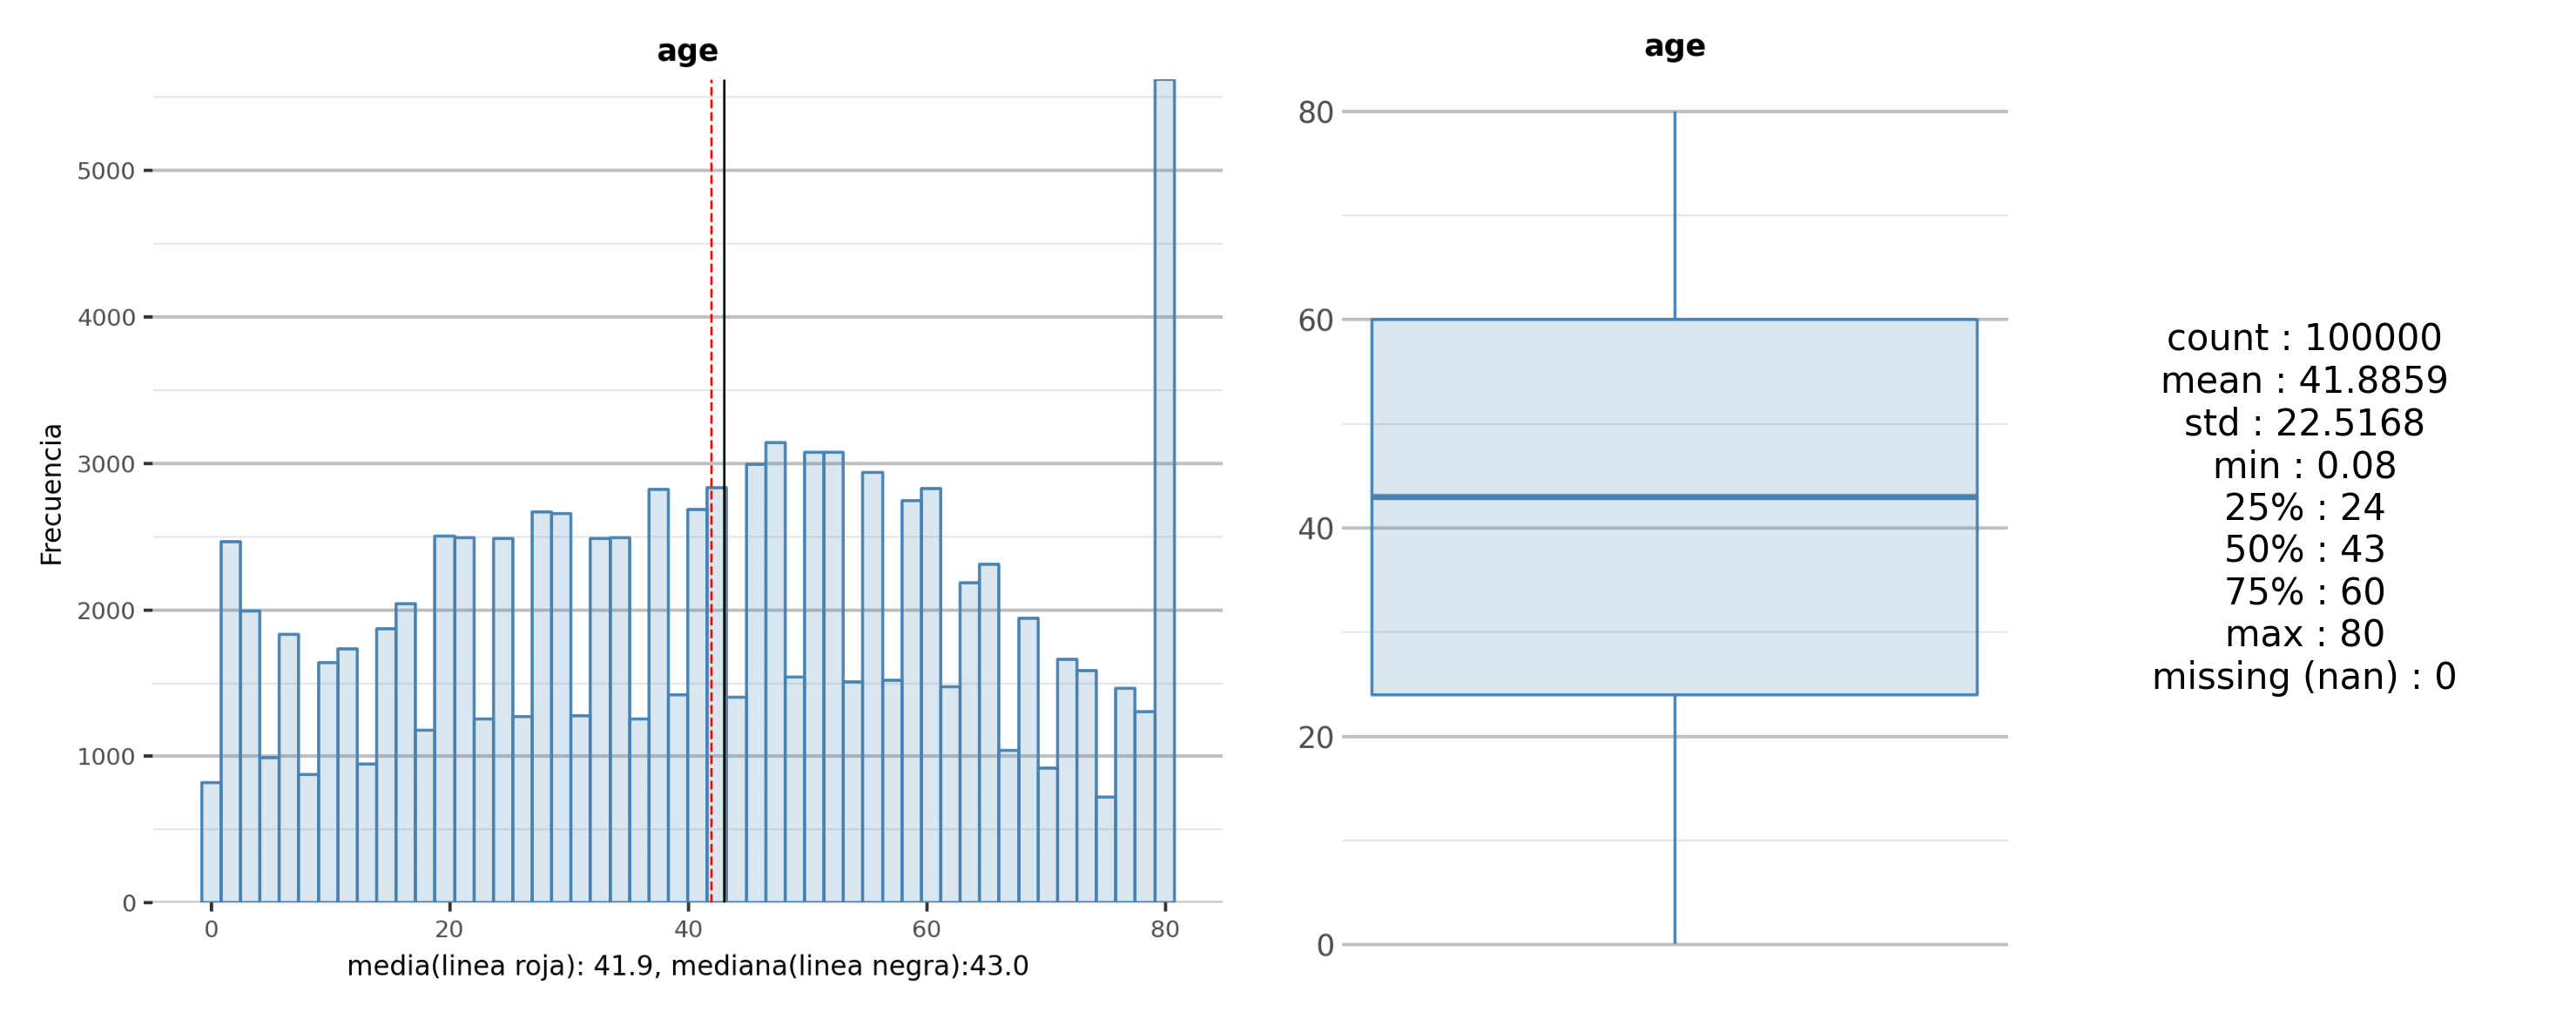

In [72]:
col = numeric_var[0]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

Observamos con estas gráficas cómo la distribución de la variable edad, aunque en el *boxplot* no se observa ningún *outlier*, sí que podemos observar como el número de cuentas del rango de edad con $80$ años es muy grande, mucho myor que el de cualquier otro grupo de edad. Esto puede ser importante a la hora de hacer un modelo ya que al tener tantas observaciones de ese grupo, las conclusiones estarán sesgadas para predecir especialmente bien en dicho grupo.


- La edad presenta un rango amplio (0.08–80 años), coherente con una población general que incluye desde recién nacidos hasta adultos mayores.
- La media (≈41.8) y la mediana (43) son muy próximas, lo que indica ausencia de asimetrías extremas.
- La distribución es relativamente homogénea, sin picos anómalos ni concentraciones artificiales.
- No se detectan outliers extremos ni valores clínicamente imposibles.
- La variabilidad observada es elevada (std ≈22.5), esperable dada la heterogeneidad de edades.
- La variable no requiere tratamiento previo para el análisis bi-variante

### hypertension

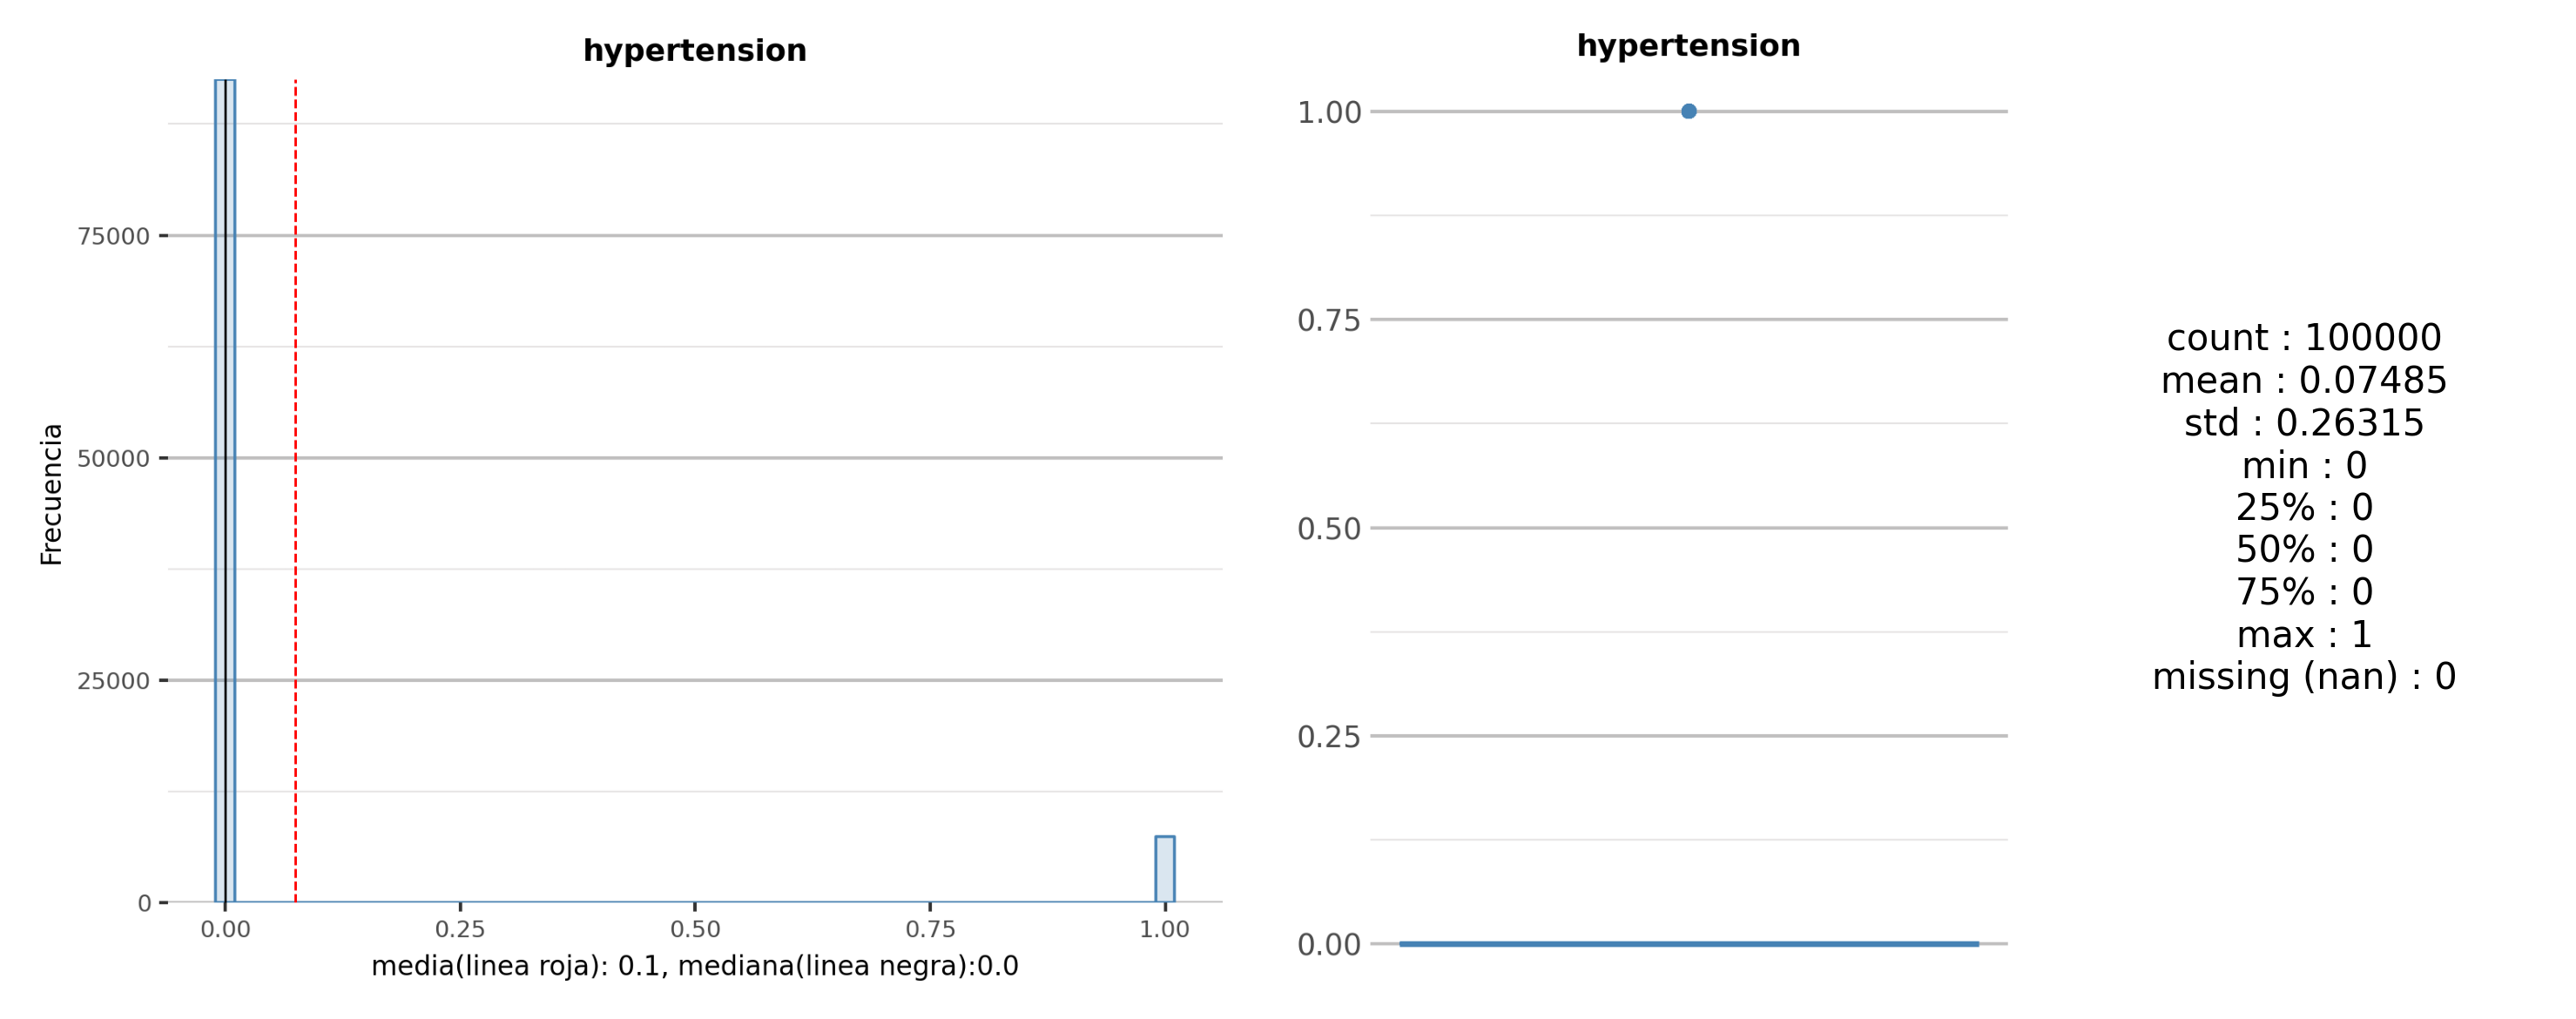

In [73]:
col = numeric_var[1]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

_hypertension_ es numérica pero solo toma los valores de $(0,1)$,  o `False`/`True`, en consecuencia de ahora en adelante se tratara como una variable categórica.

### heart_disease

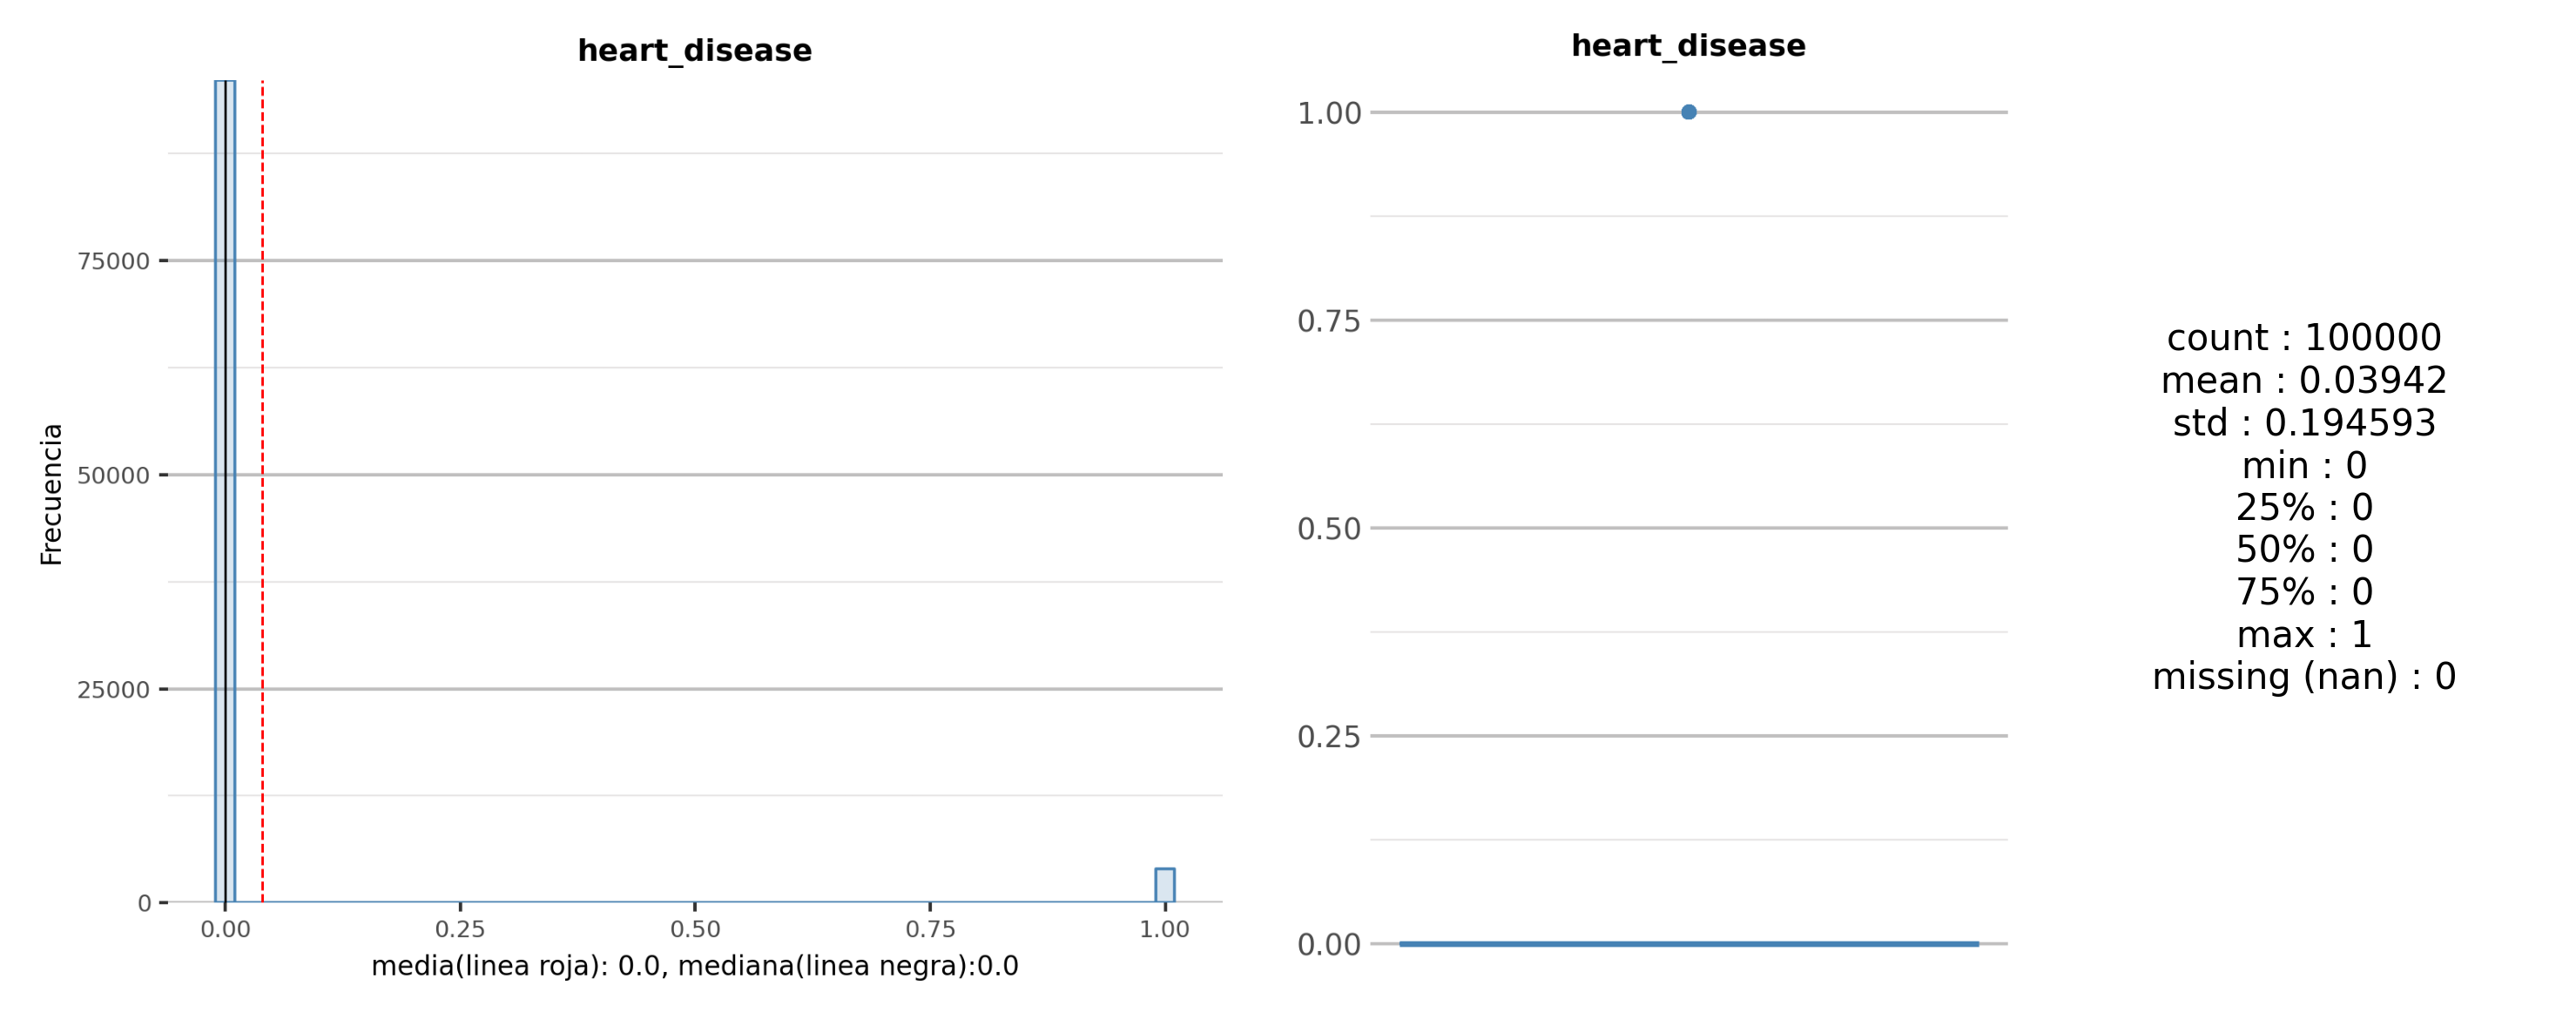

In [74]:
col = numeric_var[2]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

_heart_disease_ es numérica pero solo toma los valores de $(0,1)$,  o `False`/`True`, en consecuencia de ahora en adelante de tratara como una variable categórica.

### bmi

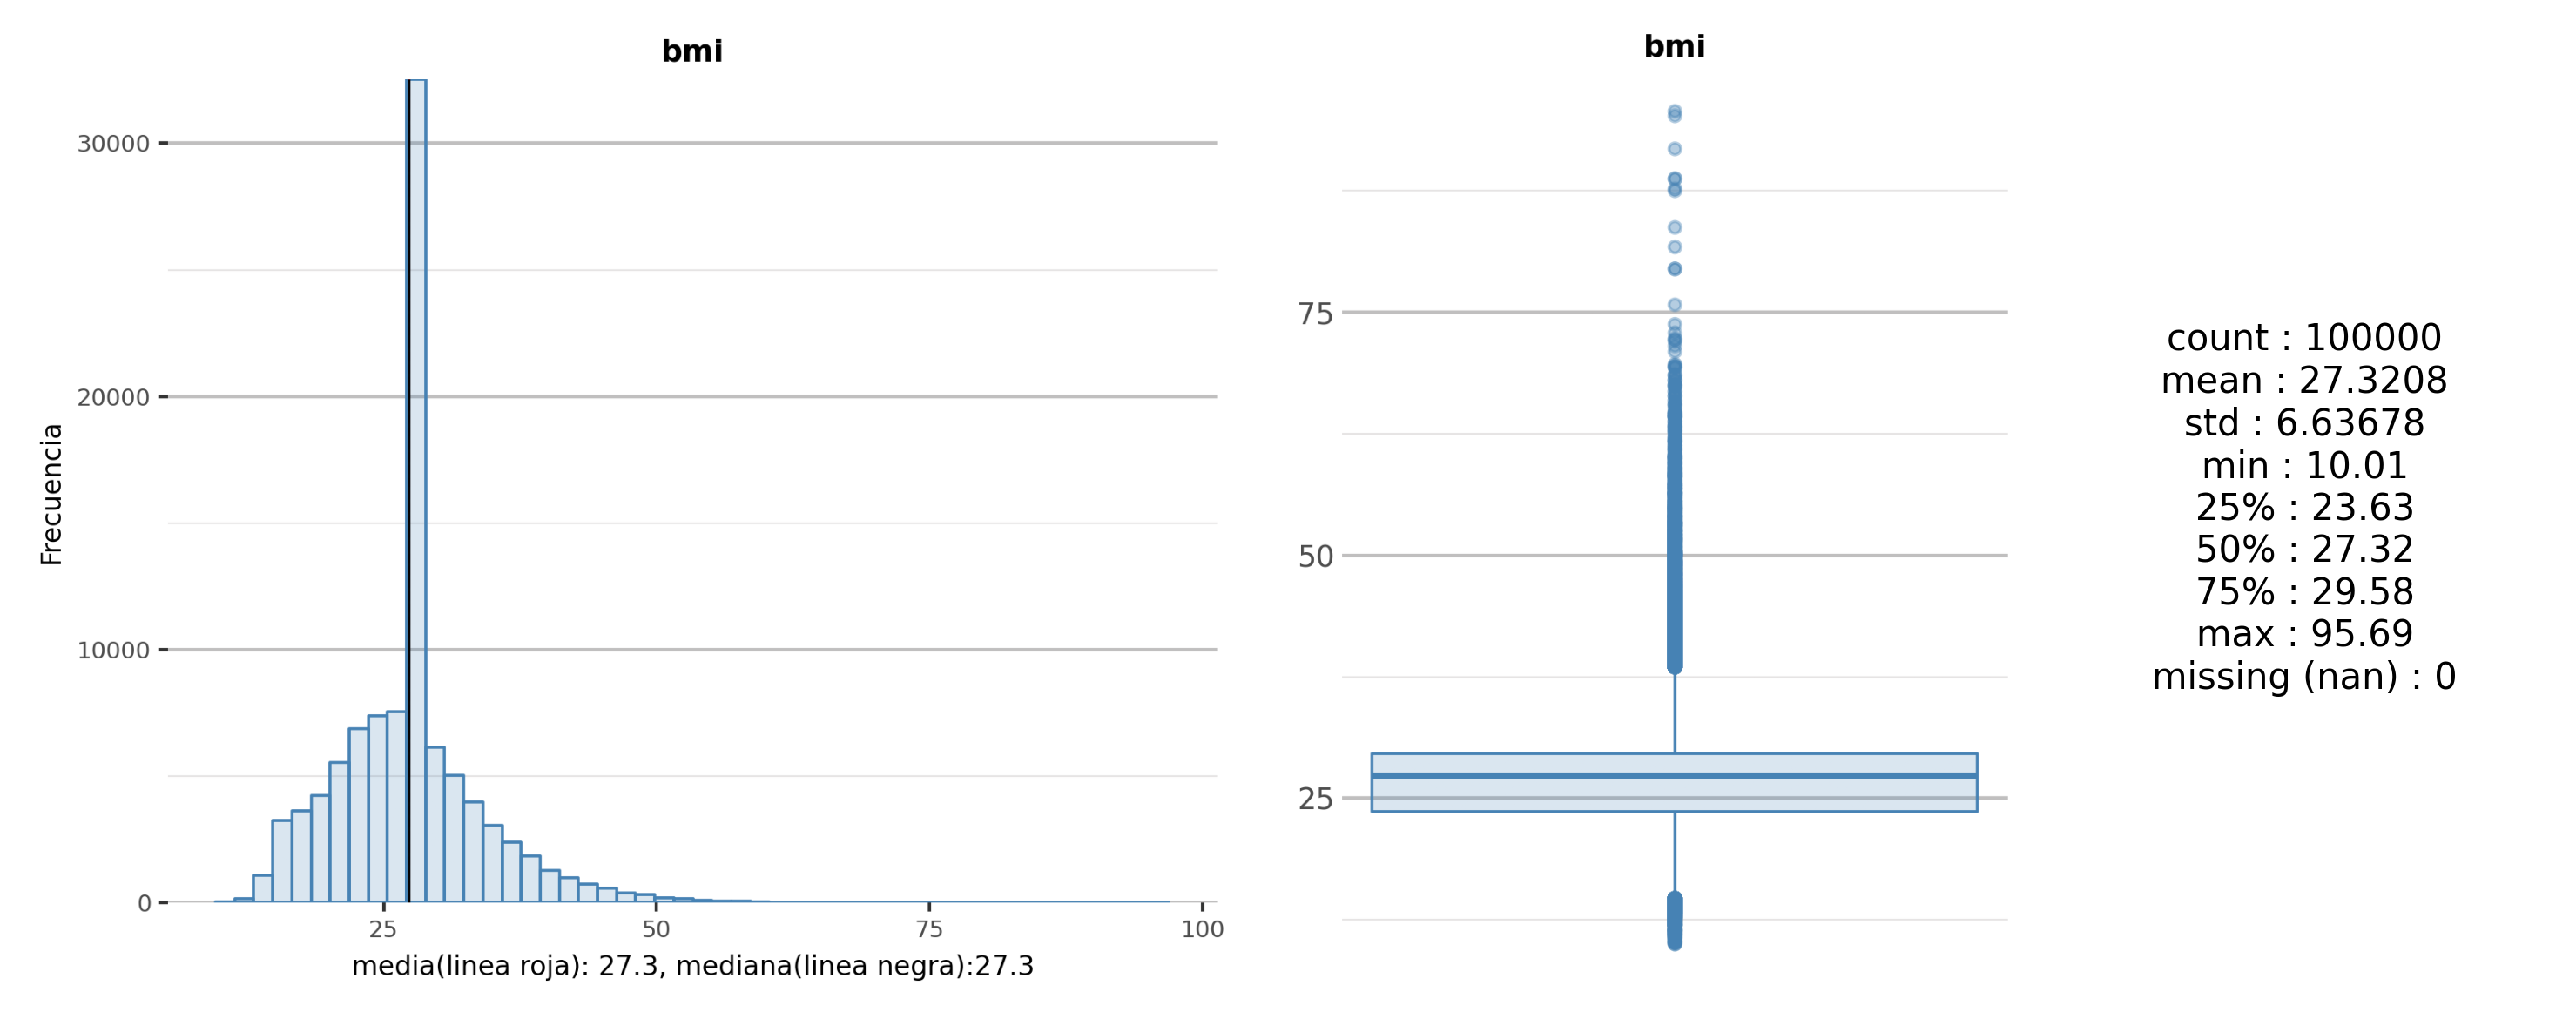

In [75]:
col = numeric_var[3]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La variable sigue una distribución normal en su histograma,alrededor de 27.3 hay una explosión en el conteo, quizás porque es un valor típico de esta variable en la población general. Existen una serie de *outliers* tanto por encima de la distribución como por debajo.

BMI presenta una distribución concentrada en valores clínicamente plausibles, pero con una cola derecha pronunciada y outliers extremos, que deberán ser tratados en fases posteriores para evitar distorsiones en el análisis.

### HbA1c_level

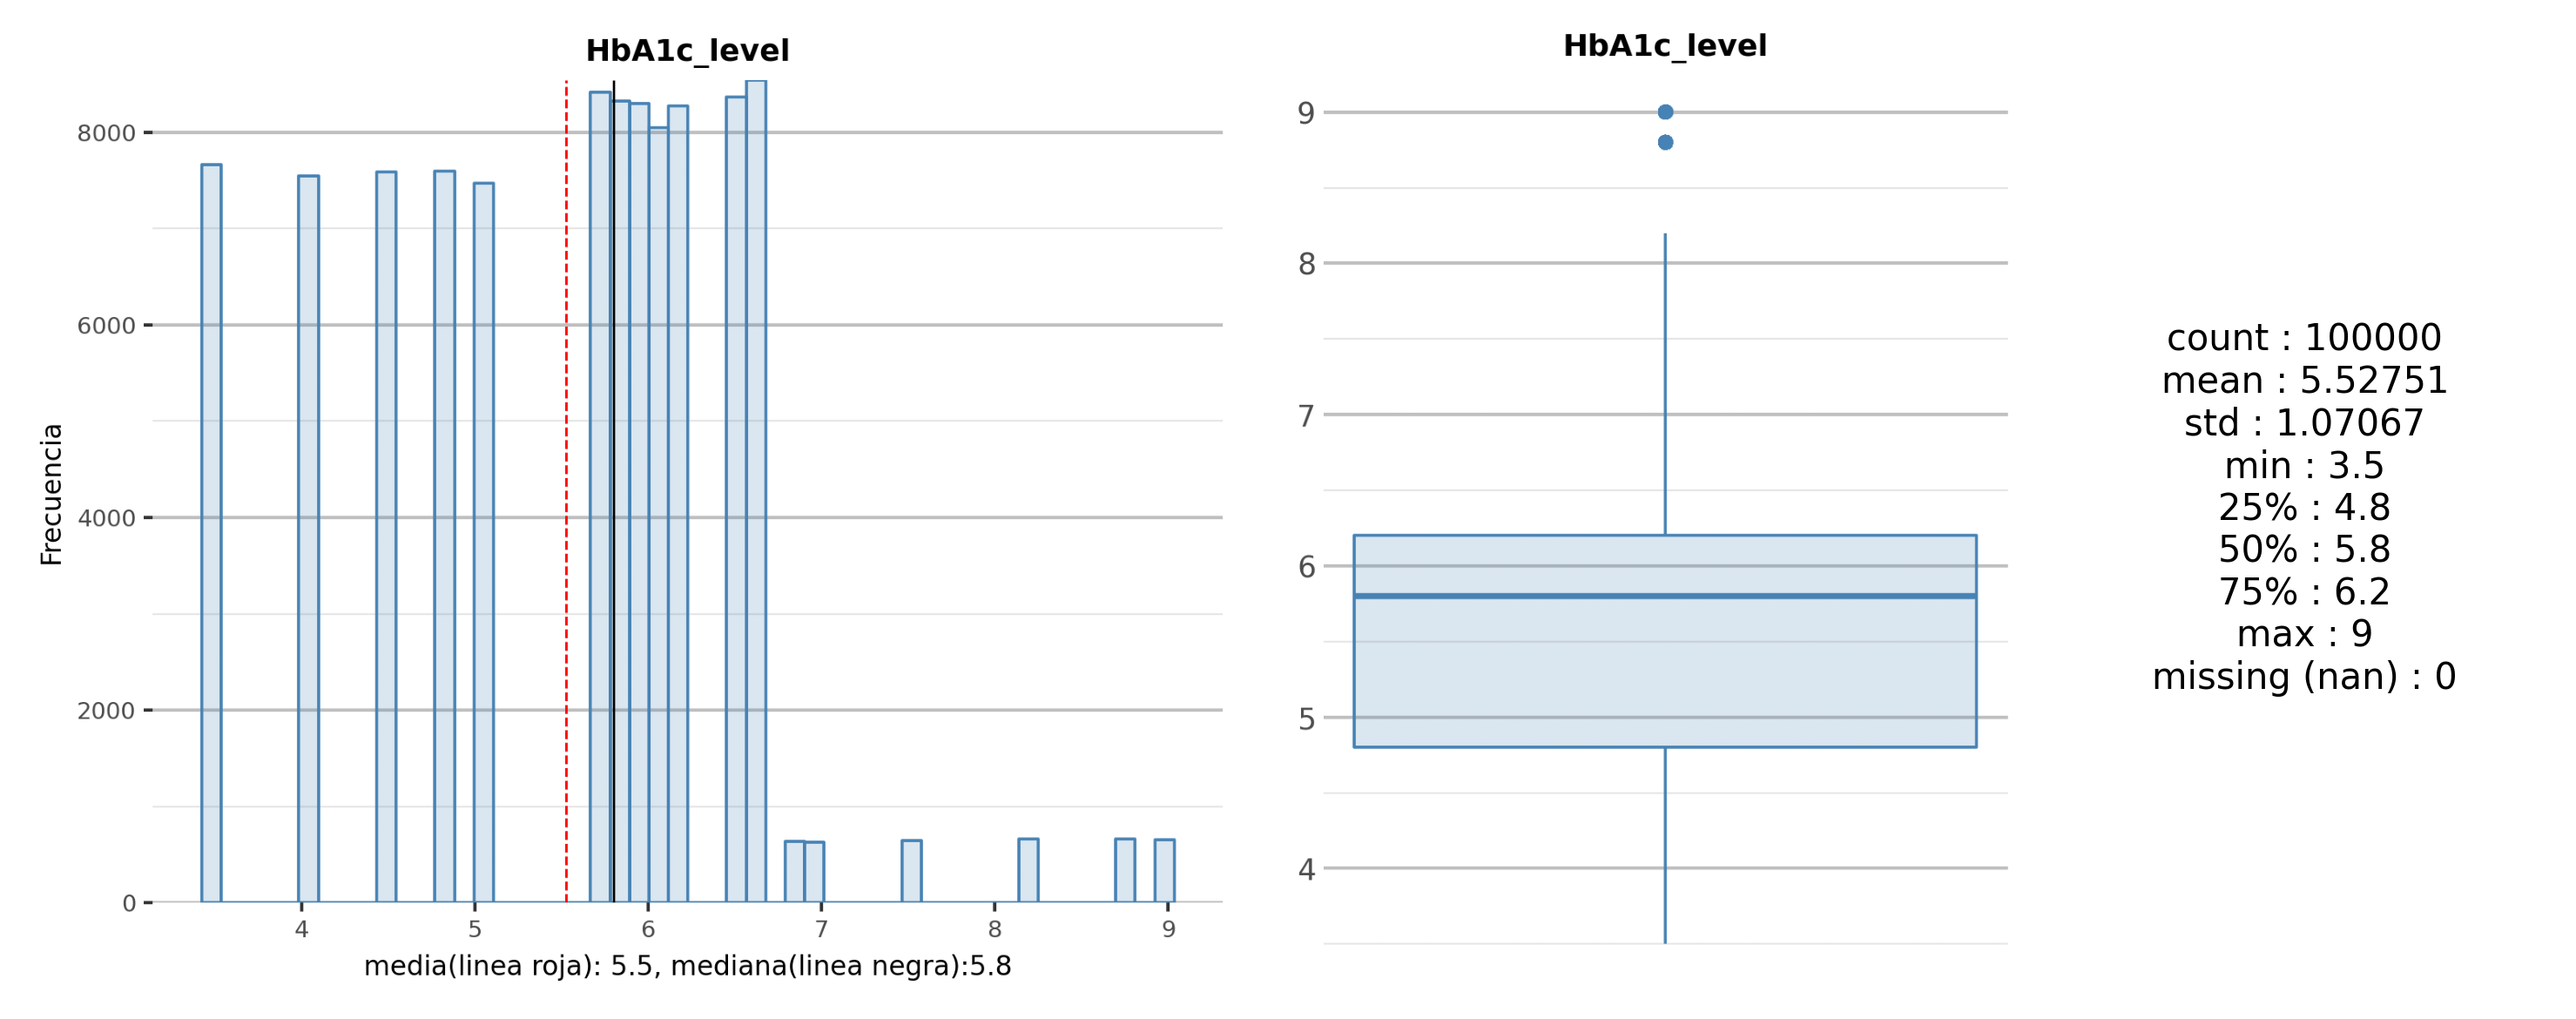

In [76]:
col = numeric_var[4]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La distribución de esta variable no es continua, ya que solo toma ciertos valores puntuales.

- La variable presenta un rango 3.5–9.0, plenamente coherente con valores clínicos reales.
- La mediana (5.8) es superior a la media (≈5.53), indicando una ligera asimetría a la izquierda.
- La mayor concentración de observaciones se sitúa entre 4.8 y 6.2, rango compatible con población no diabética y prediabética.
- Existen valores altos (≥7) poco frecuentes, compatibles con perfiles diabéticos, sin considerarse outliers erróneos.
- La dispersión es moderada (std ≈1.07), lo que sugiere buena capacidad discriminativa.
- Como consecuencia de que solo toma valores puntuales, procederemos a discretizar la variable, utilizando arboles de decisión.

### blood_glucose_level

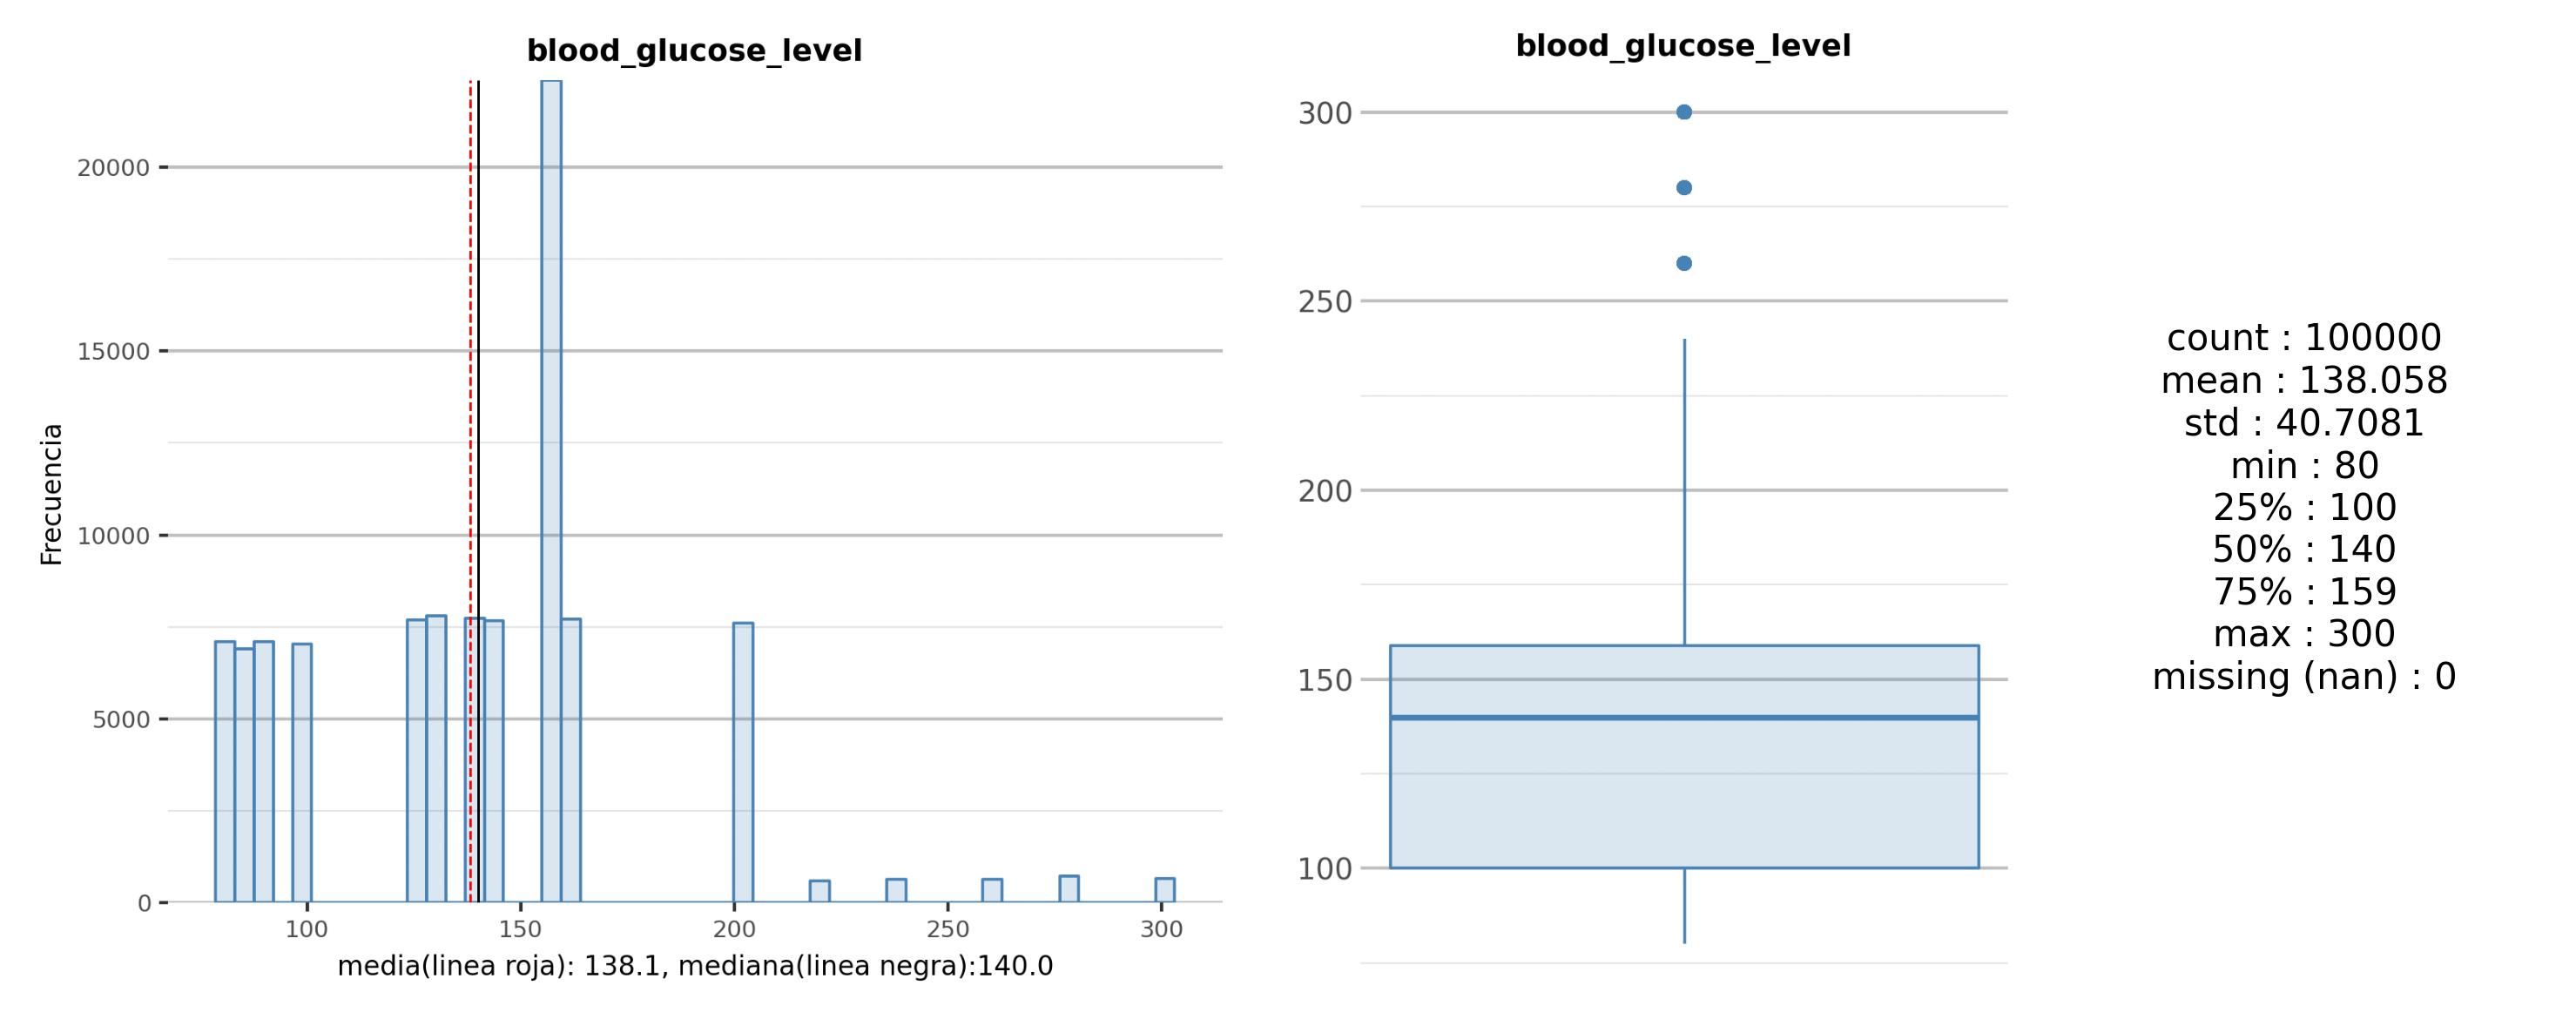

In [77]:
col = numeric_var[5]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La distribución de esta variable no es continua, ya que solo toma ciertos valores puntuales.

- La variable presenta un rango 80–300, compatible con valores clínicos reales en mediciones puntuales de glucosa.
- La mediana (140) es ligeramente superior a la media (≈138), indicando ligera asimetría a la izquierda.
- La mayor concentración de observaciones se sitúa entre 100 y 160, rango típico de población general y prediabética.
- Existen valores altos (≥200) poco frecuentes, coherentes con episodios hiperglucémicos y perfiles diabéticos.
- La dispersión es elevada (std ≈40.9), lo que sugiere heterogeneidad metabólica en la muestra.
- No se detectan valores imposibles; los extremos observados no se consideran errores, sino casos clínicamente plausibles.

### 2.1.1 Decisiones posterior al análisis univariante de variables continuas.
- hypertension y heart_disease, serán tratadas de ahora en adelante como variables categóricas binarias (0,1).

In [78]:
categoric_var.append('hypertension')
numeric_var.remove('hypertension')
categoric_var.append('heart_disease')
numeric_var.remove('heart_disease')

### 2.1.2 Detección de valores atípicos

In [79]:
desc_num = (
    data[numeric_var]
    .describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    .T
)
desc_num

count        mean        std    min     1%     5%  \
age                  100000.0   41.885856  22.516840   0.08   1.08   4.00   
bmi                  100000.0   27.320767   6.636783  10.01  14.60  16.82   
HbA1c_level          100000.0    5.527507   1.070672   3.50   3.50   3.50   
blood_glucose_level  100000.0  138.058060  40.708136  80.00  80.00  80.00   

                        25%     50%     75%     95%       99%     max  
age                   24.00   43.00   60.00   80.00   80.0000   80.00  
bmi                   23.63   27.32   29.58   39.49   48.7901   95.69  
HbA1c_level            4.80    5.80    6.20    6.60    8.8000    9.00  
blood_glucose_level  100.00  140.00  159.00  200.00  280.0000  300.00

- En la variable edad, los percentiles superiores coinciden con el valor máximo (80 años), situándose dentro de un rango plausible y mostrando una distribución acotada sin valores extremos aislados.
- En BMI, aunque el percentil 99 se sitúa en torno a 48.8, el valor máximo alcanza 95.7, superando claramente los rangos habitualmente considerados plausibles en población adulta (aprox. 10–65) y sugiriendo la presencia de casos extremos que requieren validación contextual.
- En HbA1c_level, la distribución se concentra en rangos clínicamente plausibles, con una cola derecha limitada.
- En blood_glucose_level, se observa una cola derecha marcada, con valores elevados que, aunque extremos, se mantienen dentro de rangos clínicamente plausibles.

#### Validación contextual de valores extremos en BMI

In [80]:
bmi_extreme = data['bmi'] >= 65
data.loc[bmi_extreme, numeric_var].describe().T

count        mean        std    min      25%     50%  \
age                   47.0   42.744681  15.895676   7.00   36.000   41.00   
bmi                   47.0   72.920851   8.750708  65.11   67.075   69.32   
HbA1c_level           47.0    6.042553   1.040640   3.50    5.700    6.10   
blood_glucose_level   47.0  155.446809  58.911802  85.00  126.000  145.00   

                         75%     max  
age                   53.000   80.00  
bmi                   74.775   95.69  
HbA1c_level            6.600    9.00  
blood_glucose_level  180.000  300.00

In [81]:
tab = pd.DataFrame({
    'global': data[['diabetes','hypertension','heart_disease']].mean(),
    'bmi_ge_65': data.loc[bmi_extreme, ['diabetes','hypertension','heart_disease']].mean()
})

display((tab*100).round(2).rename_axis('variable').rename(index=lambda v: f'{v}=1 (%)'))

global  bmi_ge_65
variable                              
diabetes=1 (%)         8.50      31.91
hypertension=1 (%)     7.48      17.02
heart_disease=1 (%)    3.94       6.38

#### Decisión sobre el tratamiento de valores extremos en BMI

El análisis de los valores extremos de BMI (≥ 65) identifica un subconjunto muy reducido de observaciones (47 casos sobre 100.000), claramente separado del resto de la distribución (p99 ≈ 48.8). Estos valores no forman una cola continua, sino casos altamente aislados con potencial influencia desproporcionada en el análisis.

Este grupo presenta una elevada heterogeneidad en edad (entre 7 y 80 años), lo que dificulta la interpretación directa del BMI, especialmente en población infantil. Además, aunque la proporción de diabetes es notablemente superior a la del conjunto global (≈32% frente a 8.5%), el tamaño muestral extremadamente limitado impide extraer conclusiones robustas y generalizables.

Adicionalmente, no se observa una coherencia clínica uniforme, ya que algunos individuos con BMI muy elevado muestran valores de HbA1c y glucosa dentro de rangos moderados. En conjunto, su carácter excepcional y la elevada incertidumbre asociada justifican la exclusión de estas observaciones del análisis posterior para preservar la estabilidad y capacidad de generalización de los modelos.

In [82]:
data = data[data['bmi'] < 65]

### Redondeo de la variable Age
Tenemos 2018 observaciones, donde la variable age no es un entero, al ser solo alrededor del 2% de todo el conjunto de datos y solo estar concentrado en personas menores a 2 años, redondearemos la edad.

In [83]:
data.loc[data['age']%1>0,'age'].describe().to_frame().T

count      mean       std   min   25%   50%   75%   max
age  2018.0  1.053816  0.535323  0.08  0.56  1.16  1.56  1.88

In [84]:
data['age'] = data['age'].round()

### 2.2 Análisis univariante, variables categóricas.

### gender

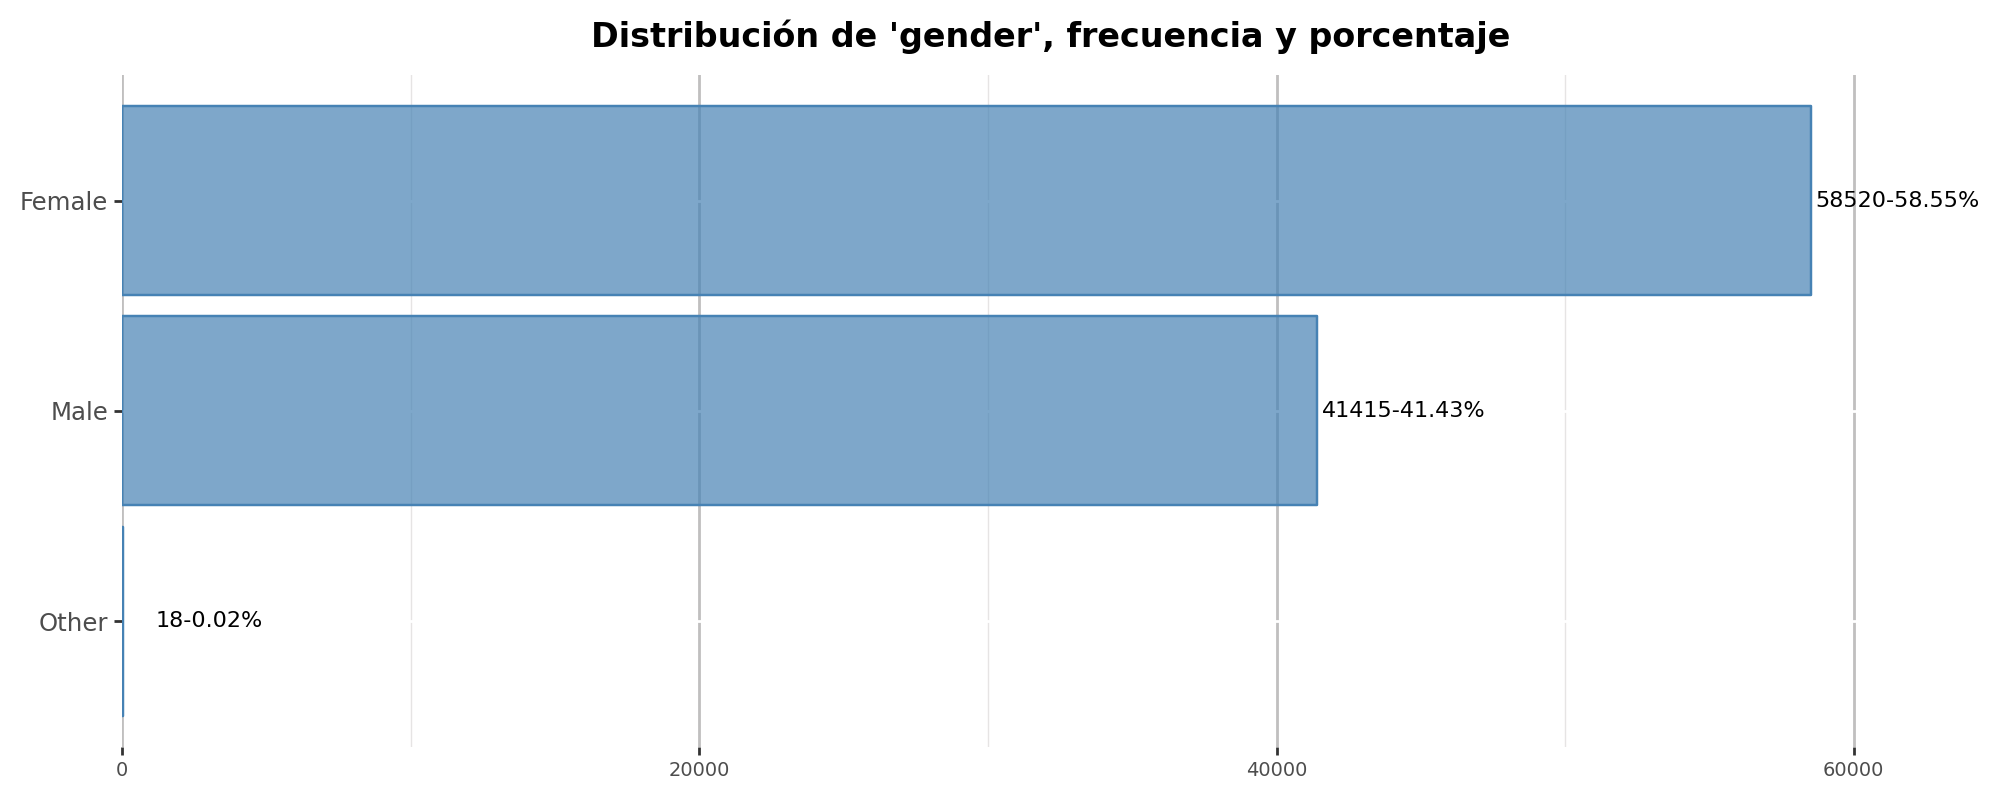

In [85]:
col = categoric_var[0]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=3000)
bar_plot.show()

Observamos la presencia de un género `Other` cuyas observaciones son irrisorias respecto a los géneros masculino y femenino y por esta razón eliminaremos estas observaciones.

### smoking_history

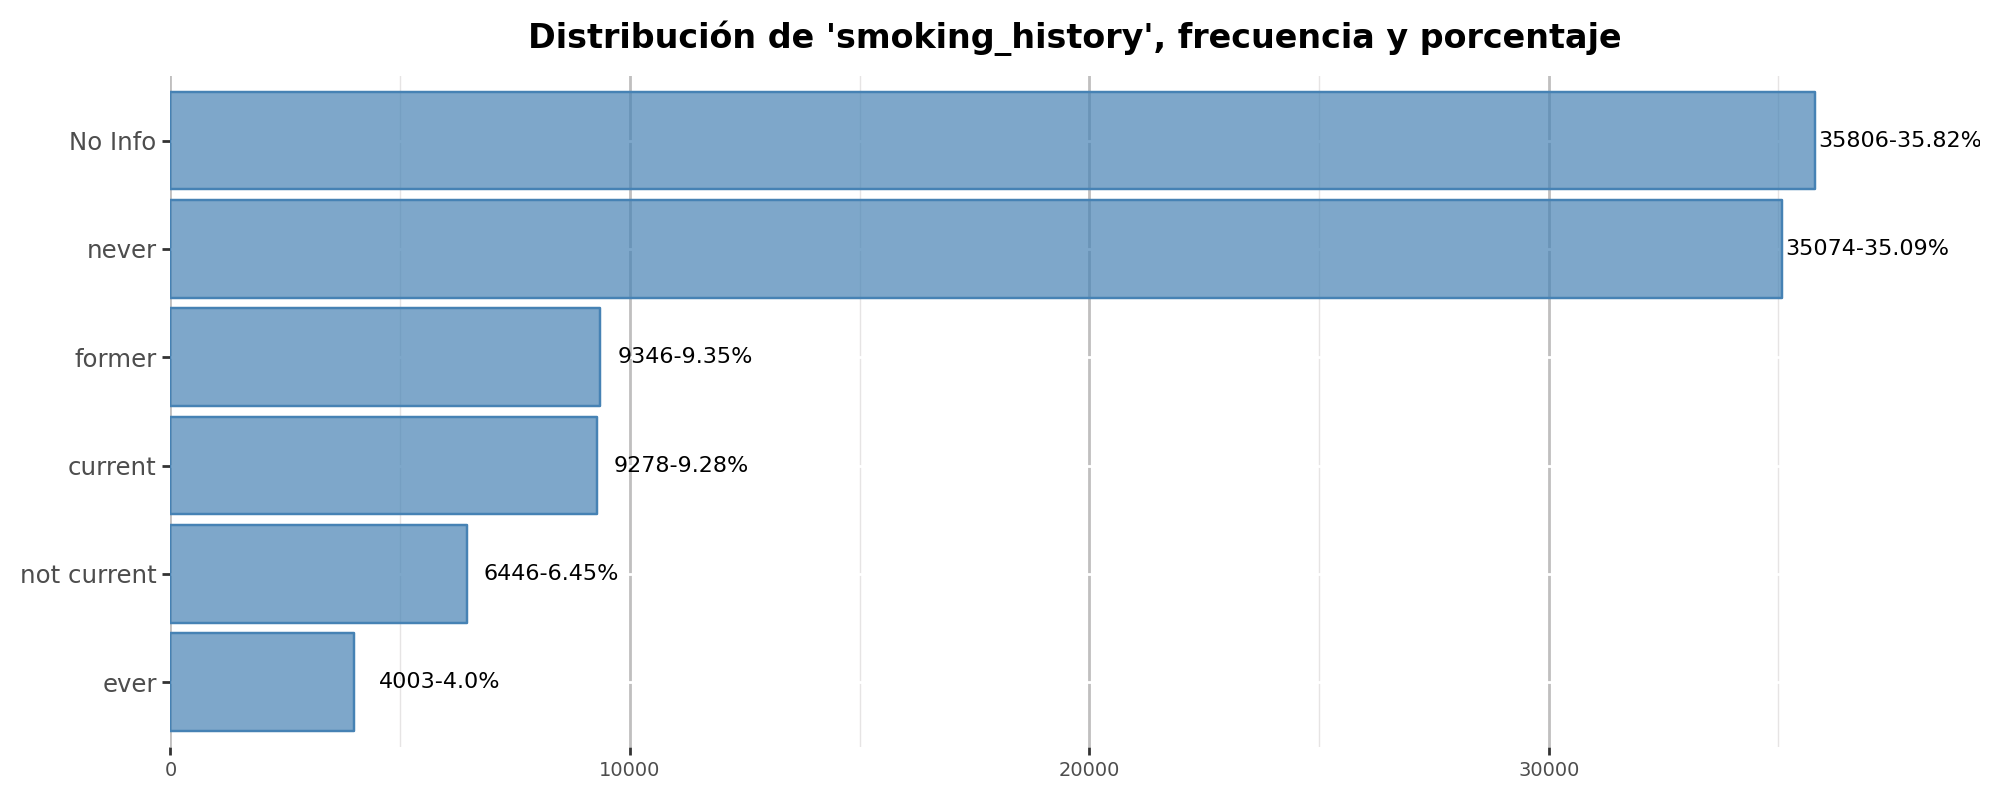

In [86]:
col = categoric_var[1]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=1850)
bar_plot.show()

La variable `smoking_history` recoge distintas categorías relacionadas con el historial de tabaquismo, cuyo significado puede presentar **solapamientos conceptuales**:

- **never**: personas que nunca han fumado.
- **current**: personas que fuman en la actualidad.
- **former**: personas que fumaron en el pasado, pero que ya no fuman.
- **ever**: personas que han fumado alguna vez en su vida; esta categoría puede incluir tanto a fumadores actuales como a posibles exfumadores.
- **not current**: personas que no fuman actualmente; puede incluir tanto a personas que nunca han fumado como a exfumadores.
- **No Info**: personas para las que no se dispone de información sobre su historial de tabaquismo.

Debido a estas definiciones, algunas categorías no son estrictamente mutuamente excluyentes desde un punto de vista conceptual (por ejemplo, `former` puede estar contenido dentro de `ever` o `not current`).

Podemos ver que hay una gran cantidad de falta de información. Un tercio de la información de esta variable es desconocida (No info). En cuanto a nuestras variables que son similares, vemos que hay una cierta homogeneidad en el conteo, dentro del mismo orden de magnitud. Sin embargo, sí que vemos claras diferencias entre aquellos que declaran ser fumadores ($\sim 9000$) y los que no han fumado nunca ($\sim 35,000$).

### diabetes (variable objetivo)

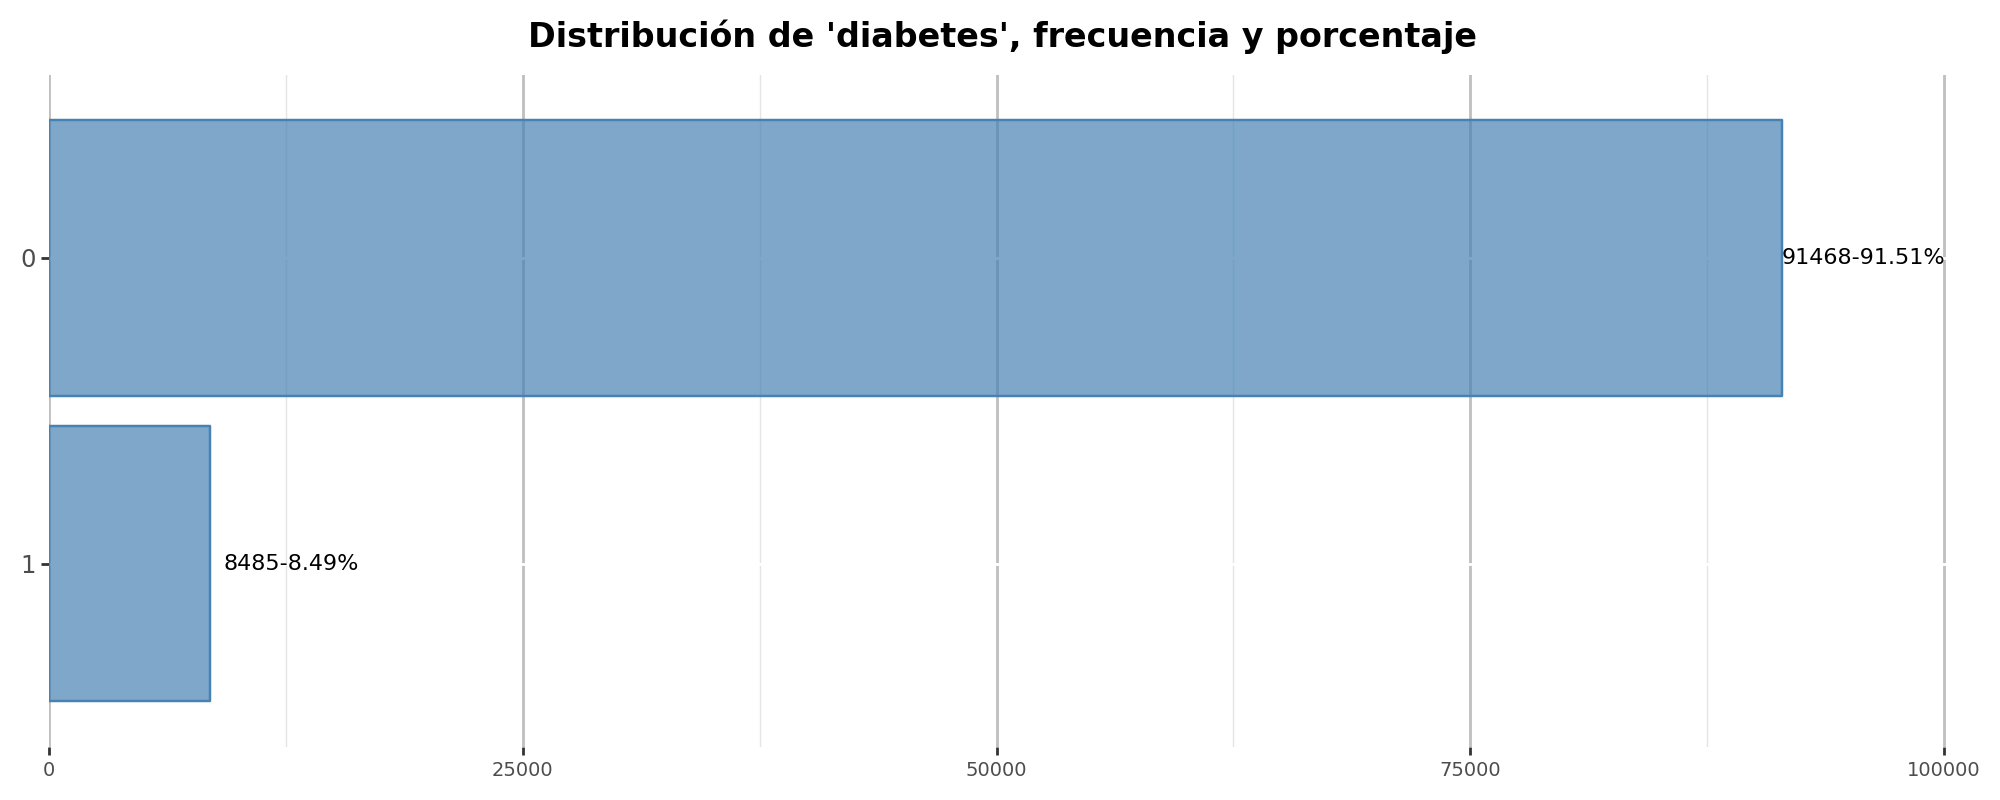

In [87]:
col = categoric_var[2]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4300)
bar_plot.show()

- La prevalencia de diabetes en el dataset es baja (~8.5%).
- La variable objetivo está claramente **desbalanceada**, con predominio de no diabéticos.
- La distribución es coherente con un escenario de cribado poblacional.

### hypertension

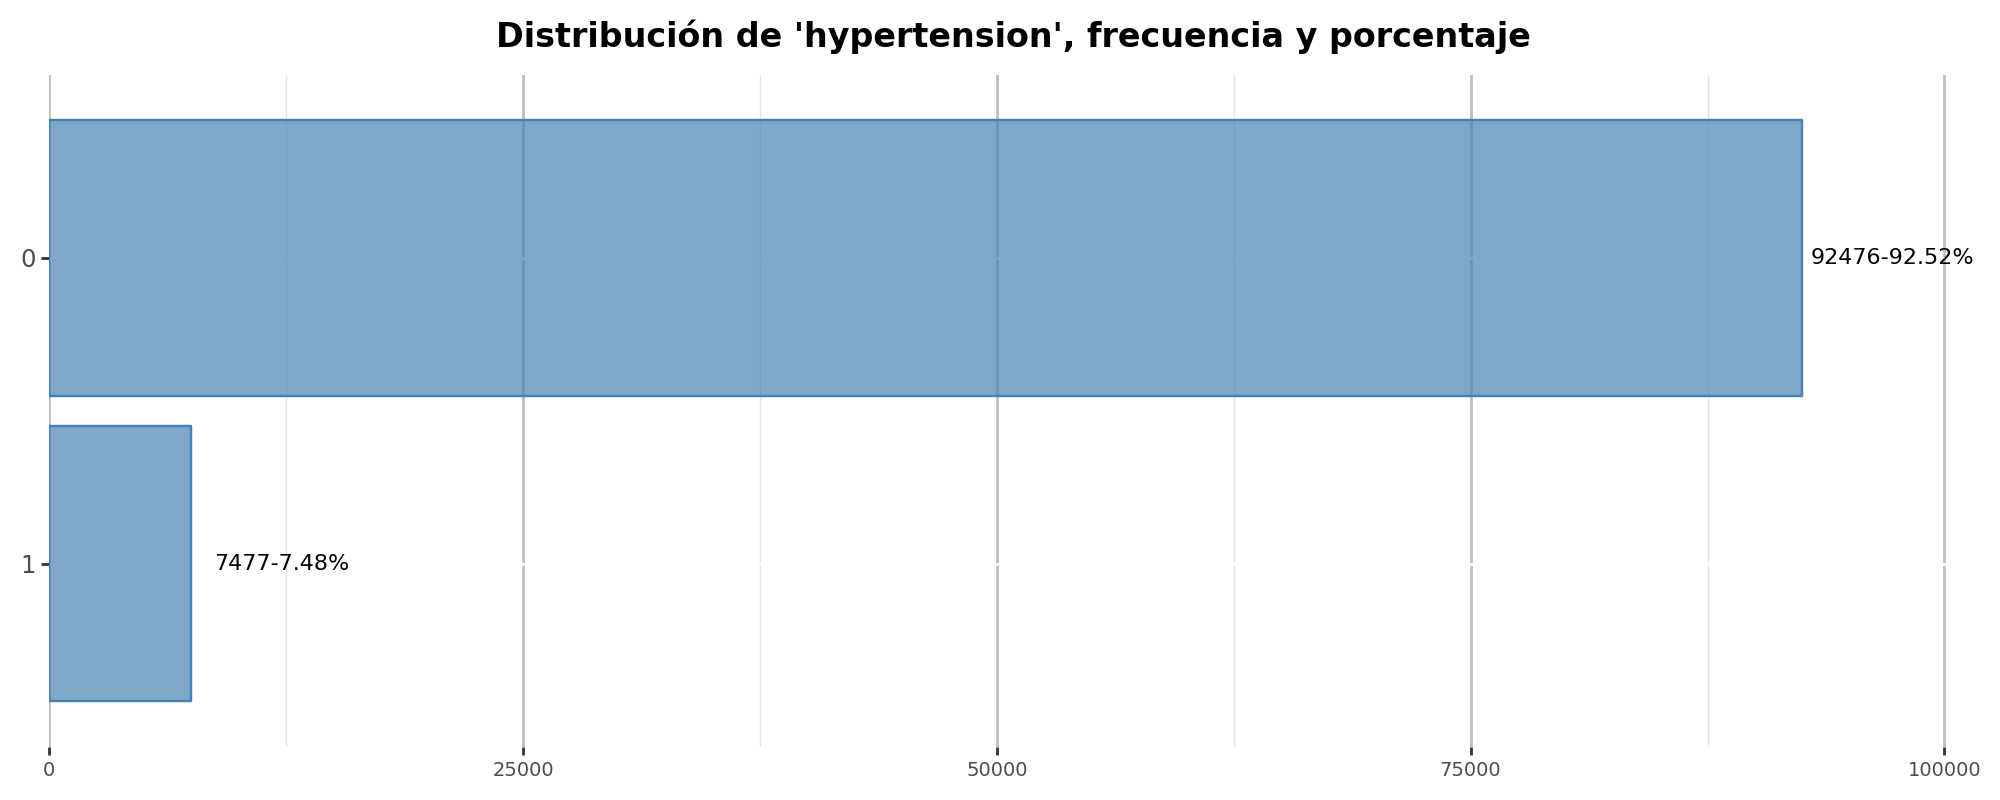

In [88]:
col = categoric_var[3]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4800)
bar_plot.show()

- La hipertensión presenta una prevalencia baja (~7.5%) en el dataset.
- La variable está **desbalanceada**, con clara mayoría de individuos sin hipertensión.
- La frecuencia observada es clínicamente plausible para una población general.
- La baja prevalencia sugiere que la hipertensión puede actuar como **factor de riesgo**, no como característica dominante.
- La variable es informativa, pero su efecto deberá evaluarse en combinación con otras variables en el análisis bi-variante.

### heart_disease

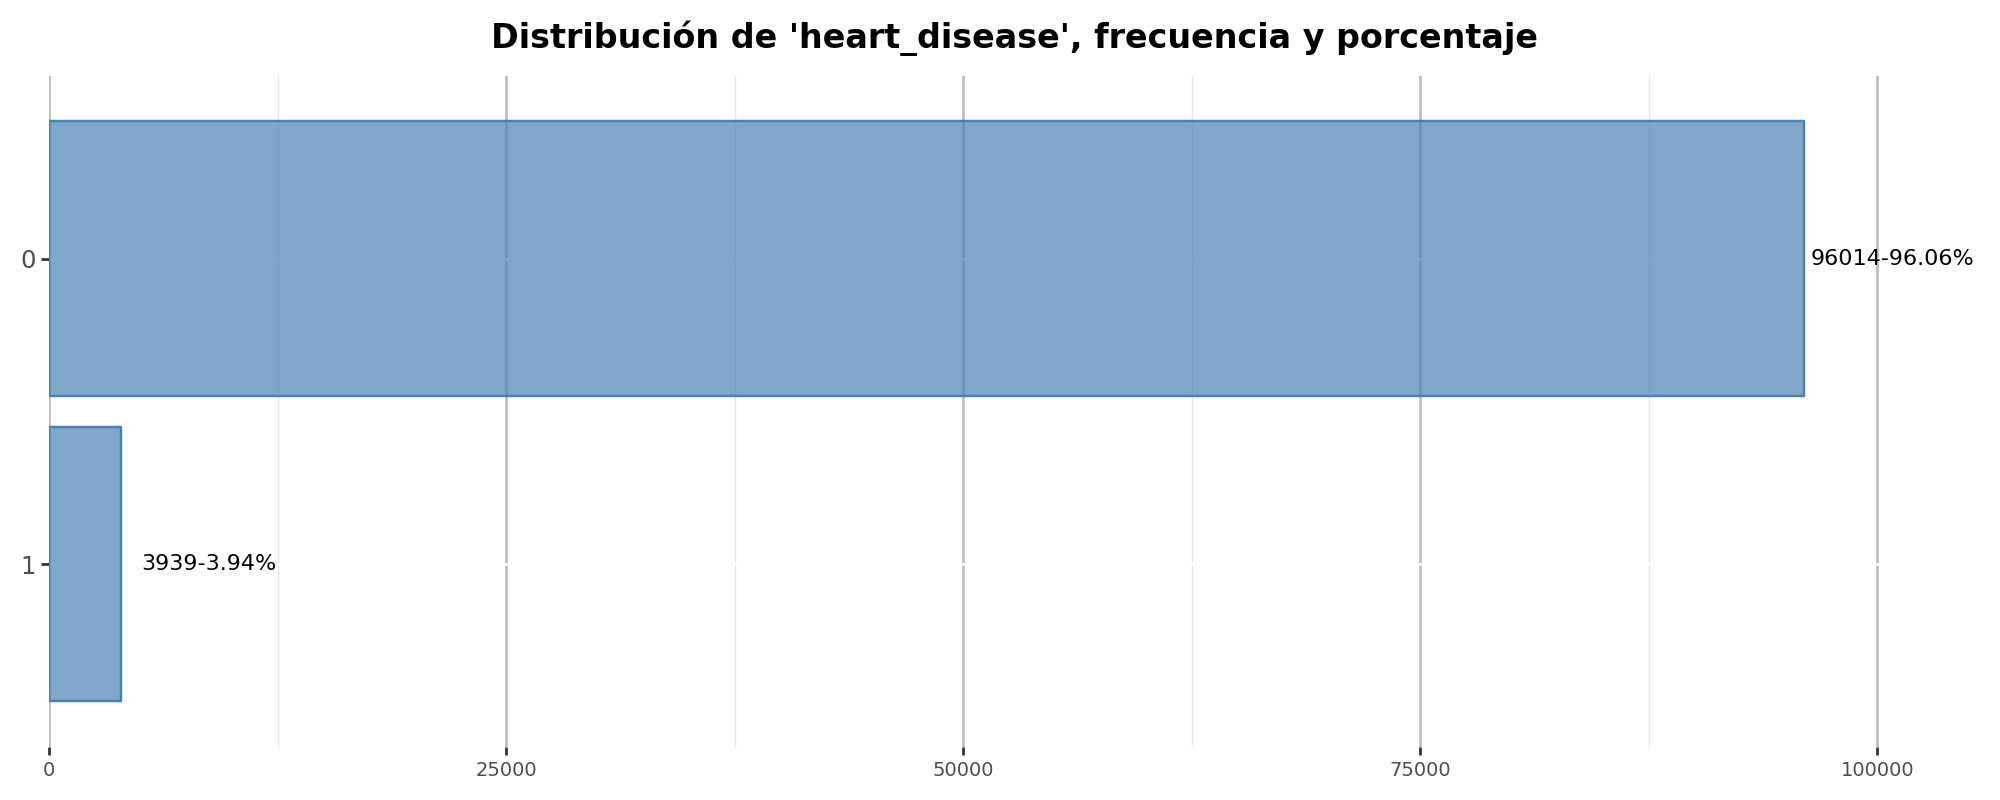

In [89]:
col = categoric_var[4]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4800)
bar_plot.show()

- La enfermedad cardíaca presenta una **prevalencia muy baja** (~3.9%) en el dataset.
- La variable está fuertemente **desbalanceada**, con una clara mayoría de individuos sin patología cardíaca.
- La frecuencia observada es coherente clínicamente para una población general.
- Al tratarse de una condición poco frecuente, su impacto aislado puede ser limitado, pero **puede aportar señal relevante en combinación con otras variables**.
- Será importante vigilar posibles celdas con baja frecuencia en análisis bivariantes y tests estadísticos.




### 2.3. Acciones a realizar posterior al análisis univariante de variables

En consecuencia de lo observado, se toman las siguientes decisiones
- Eliminar la clase **Other** en la variable de gender, ya que las observaciones son muy pocas 0.02%.
- Se discretizaran las variables HbA1c_level y blood_glucose_level utilizando optimal binning, ya que al no ser variables continuas y dada la cantidad de observaciones y considerando que el objetivo del modelo es la clasificación de individuos con y sin diabetes, esta transformación permite mejorar la interpretabilidad del modelo y capturar de forma más adecuada patrones clínicamente relevantes.
- Se discretizan Age y Bmi para evaluar su comportamiento en miras a un modelo de regresión logística.

Las discretizaciones se hacen solo con fines exploratorios, estamos al tanto de que hacer los modelos con la discretización sobre todo el dataset es inadecuado, y tiene como consecuencia el "dataleakage".

In [90]:
data = data[data['gender']!='Other'].copy()

#### Discretización blood_glucose_level

In [91]:
col = 'blood_glucose_level'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=4)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 128.00)  35827   0.358503      35192    635    0.017724   
1       [128.00, 159.50)  45539   0.455686      42300   3239    0.071126   
2       [159.50, 180.00)   7705   0.077100       7009    696    0.090331   
3          [180.00, inf)  10864   0.108711       6949   3915    0.360365   
4                Special      0   0.000000          0      0    0.000000   
5                Missing      0   0.000000          0      0    0.000000   
Totals                    99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0       1.637457  0.507586  0.057192   41.65  
1        0.19203  0.015519  0.001937    1.27  
2      -0.067892  0.000366  0.000046    0.03  
3       -1.80371  0.695178  0.076753   57.04  
4            0.0  0.000000  0.000000    0.00  
5            0.0  0.000000  0.000000    0.00  
Totals            1.218648  0.135927  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [92]:
data['blood_glucose_level_binned'] = optbin.transform(data['blood_glucose_level'], metric='bins')
categoric_var.append('blood_glucose_level_binned')

#### Discretización HbA1c_level

In [93]:
col = 'HbA1c_level'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=5)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 5.75)  46248   0.462781      45547    701    0.015157   
1       [5.75, 6.55)  41268   0.412948      38053   3215    0.077905   
2        [6.55, inf)  12419   0.124271       7850   4569    0.367904   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0         1.7965  0.746333  0.082476   47.21  
1        0.09366  0.003484  0.000435    0.22  
2      -1.836273  0.831172  0.091388   52.57  
3            0.0  0.000000  0.000000    0.00  
4            0.0  0.000000  0.000000    0.00  
Totals            1.580989  0.174299  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [94]:
data['HbA1c_level_binned'] = optbin.transform(data['HbA1c_level'], metric='bins')
categoric_var.append('HbA1c_level_binned')

#### Discretización age

In [95]:
col = 'age'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=8)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 5.50)   6271   0.062751       6263      8    0.001276   
1        [5.50, 12.50)   6079   0.060830       6051     28    0.004606   
2       [12.50, 27.50)  17331   0.173423      17157    174    0.010040   
3       [27.50, 38.50)  14355   0.143643      13935    420    0.029258   
4       [38.50, 46.50)  11319   0.113264      10631    688    0.060783   
5       [46.50, 53.50)  10825   0.108320       9819   1006    0.092933   
6       [53.50, 60.50)  10130   0.101366       8686   1444    0.142547   
7         [60.50, inf)  23625   0.236404      18908   4717    0.199661   
8              Special      0   0.000000          0      0    0.000000   
9              Missing      0   0.000000          0      0    0.000000   
Totals                  99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0       4.285481  0.289453  0.021567   21.18  
1       2.998282  0.188494  0.017438   13.79  
2       2.213614  0.369904  0.038637   27.07  
3       1.124412  0.115679  0.013743    8.47  
4       0.360248  0.012668  0.001575    0.93  
5      -0.099155  0.001110  0.000139    0.08  
6      -0.583197  0.043857  0.005406    3.21  
7       -0.98908  0.345352  0.041491   25.27  
8            0.0  0.000000  0.000000    0.00  
9            0.0  0.000000  0.000000    0.00  
Totals            1.366516  0.139995  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [96]:
data['age_binned'] = optbin.transform(data['age'], metric='bins')
categoric_var.append('age_binned')

#### Discretización bmi

In [97]:
col = 'bmi'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=8)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 16.96)   5279   0.052824       5246     33    0.006251   
1       [16.96, 19.30)   5010   0.050133       4957     53    0.010579   
2       [19.30, 21.62)   6823   0.068274       6637    186    0.027261   
3       [21.62, 24.05)   9685   0.096913       9284    401    0.041404   
4       [24.05, 27.77)  41250   0.412768      38571   2679    0.064945   
5       [27.77, 30.65)  10627   0.106339       9466   1161    0.109250   
6       [30.65, 37.95)  14755   0.147646      12371   2384    0.161572   
7         [37.95, inf)   6506   0.065102       4918   1588    0.244082   
8              Special      0   0.000000          0      0    0.000000   
9              Missing      0   0.000000          0      0    0.000000   
Totals                  99935   1.000000      91450   8485    0.084905   

             WoE        IV        JS    IV_%  
0       2.691221  0.143914  0.013987   21.72  
1       2.160772  0.103627  0.010906   15.64  
2       1.197176  0.060642  0.007158    9.15  
3       0.764594  0.041487  0.005063    6.26  
4       0.289565  0.030705  0.003825    4.63  
5      -0.279068  0.009298  0.001159    1.40  
6      -0.730917  0.106488  0.013022   16.07  
7      -1.247066  0.166328  0.019541   25.11  
8            0.0  0.000000  0.000000    0.00  
9            0.0  0.000000  0.000000    0.00  
Totals            0.662489  0.074659  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [98]:
data['bmi_binned'] = optbin.transform(data['bmi'], metric='bins')
categoric_var.append('bmi_binned')

### 2.4 Análisis bi-variantes, variables numéricas.

### age

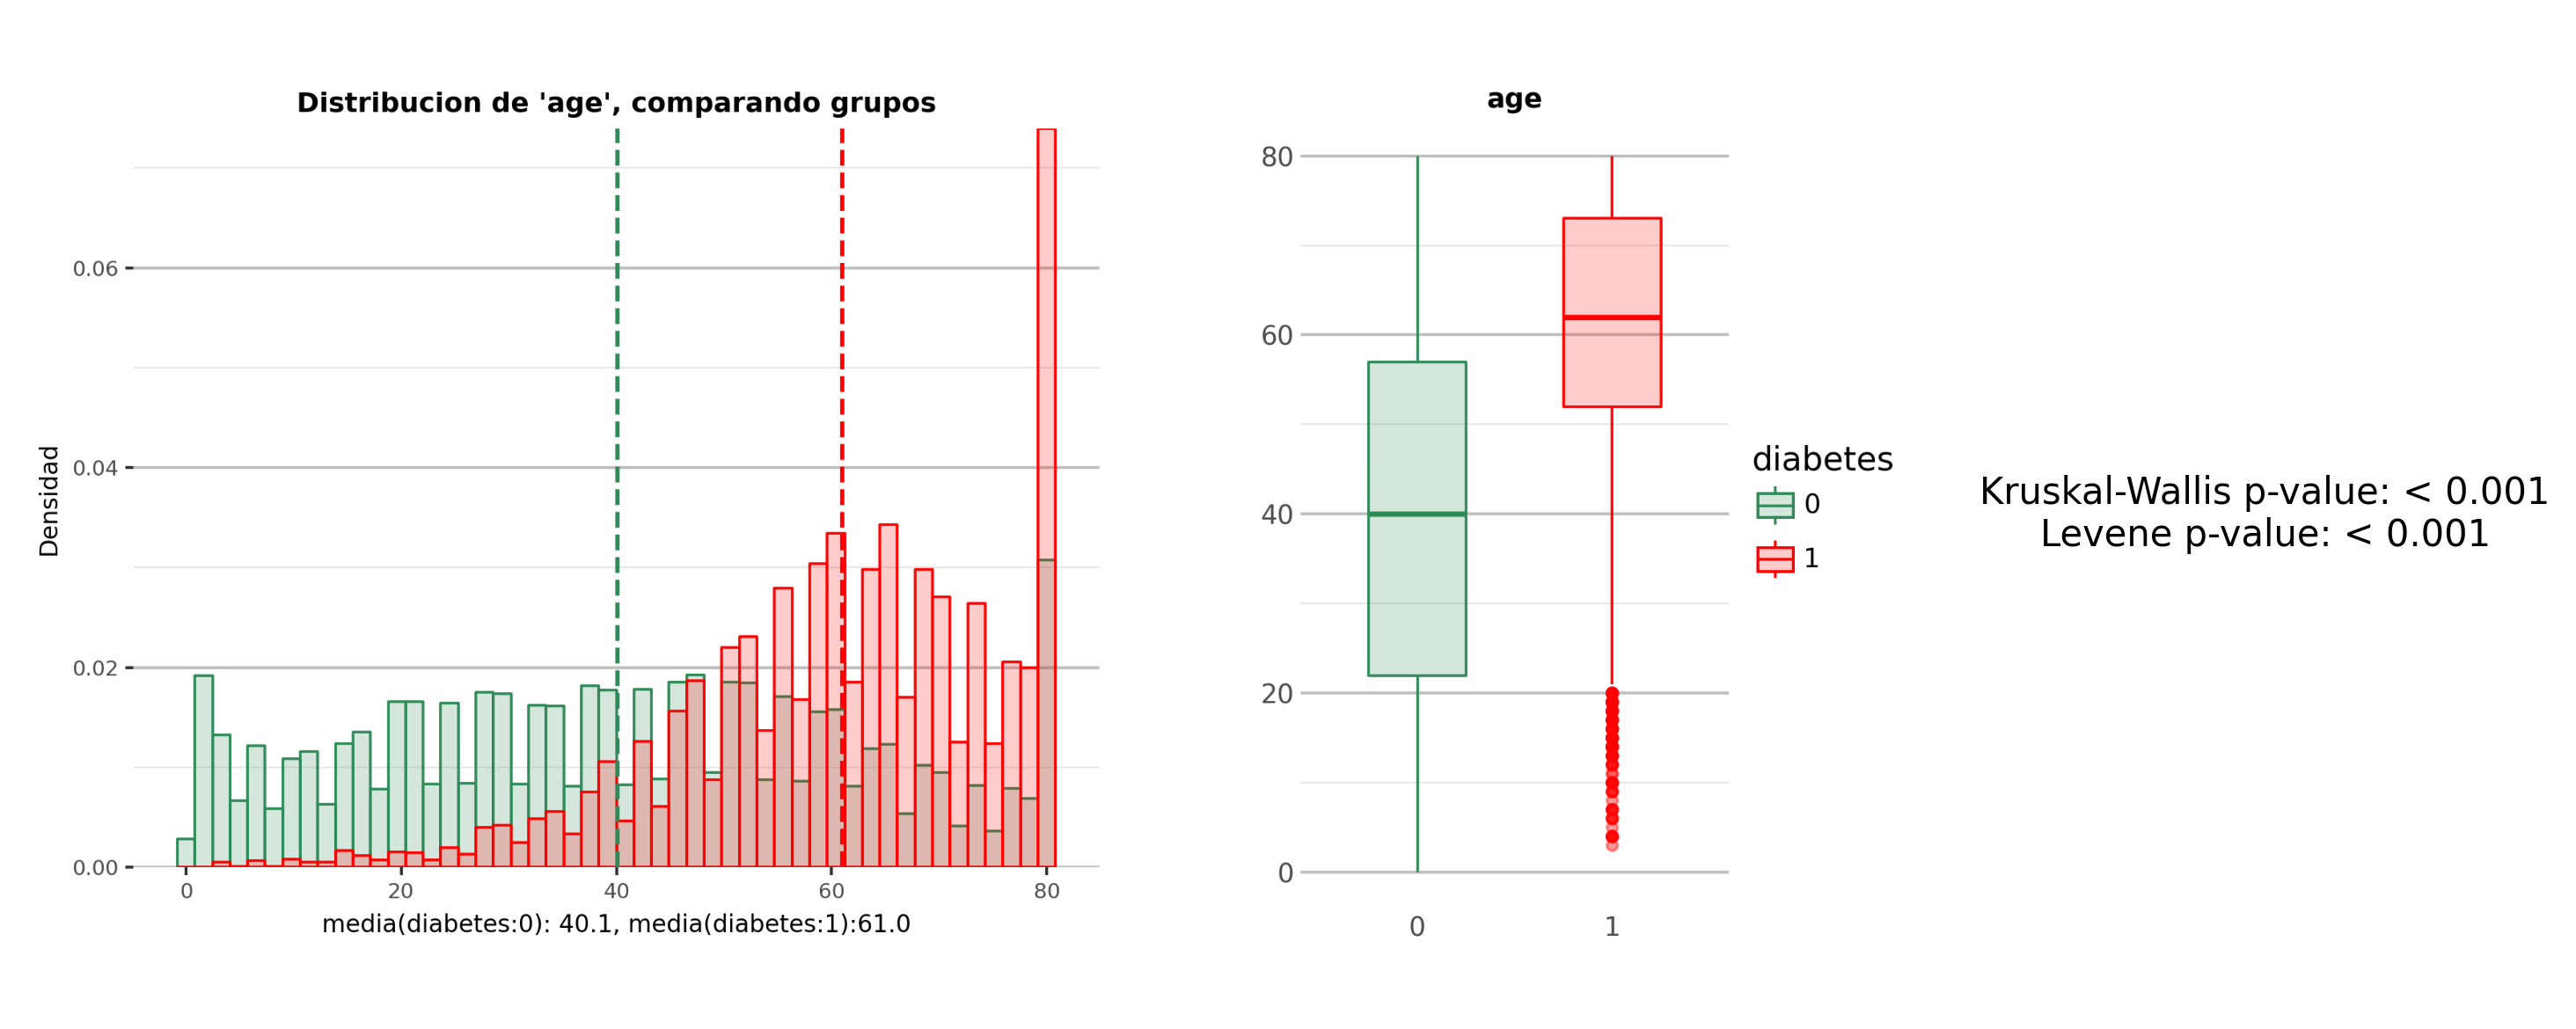

In [99]:
col=numeric_var[0]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### bmi

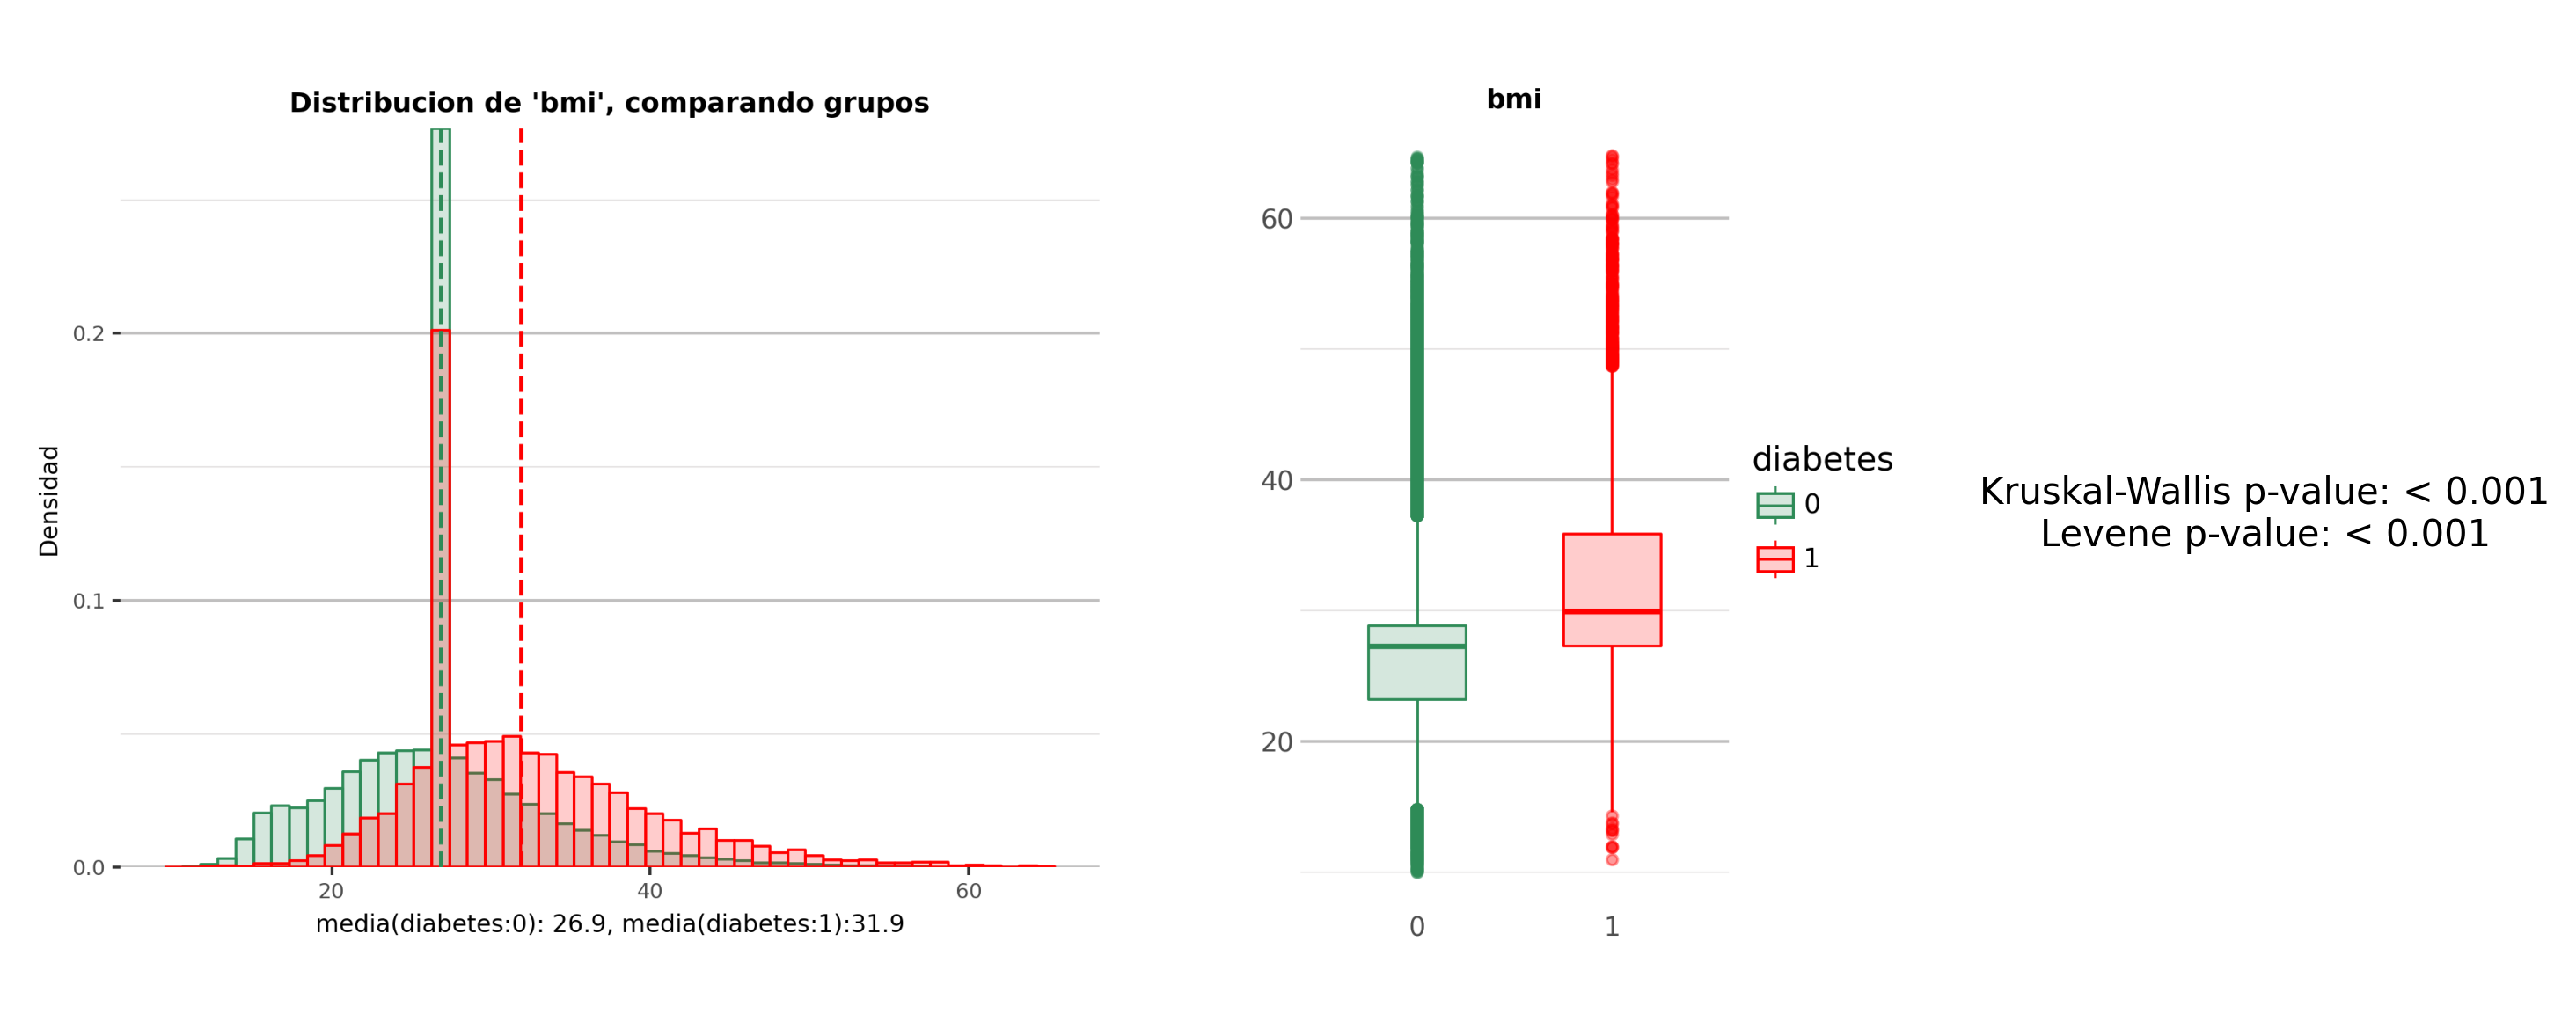

In [100]:
col=numeric_var[1]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### HbA1c_level

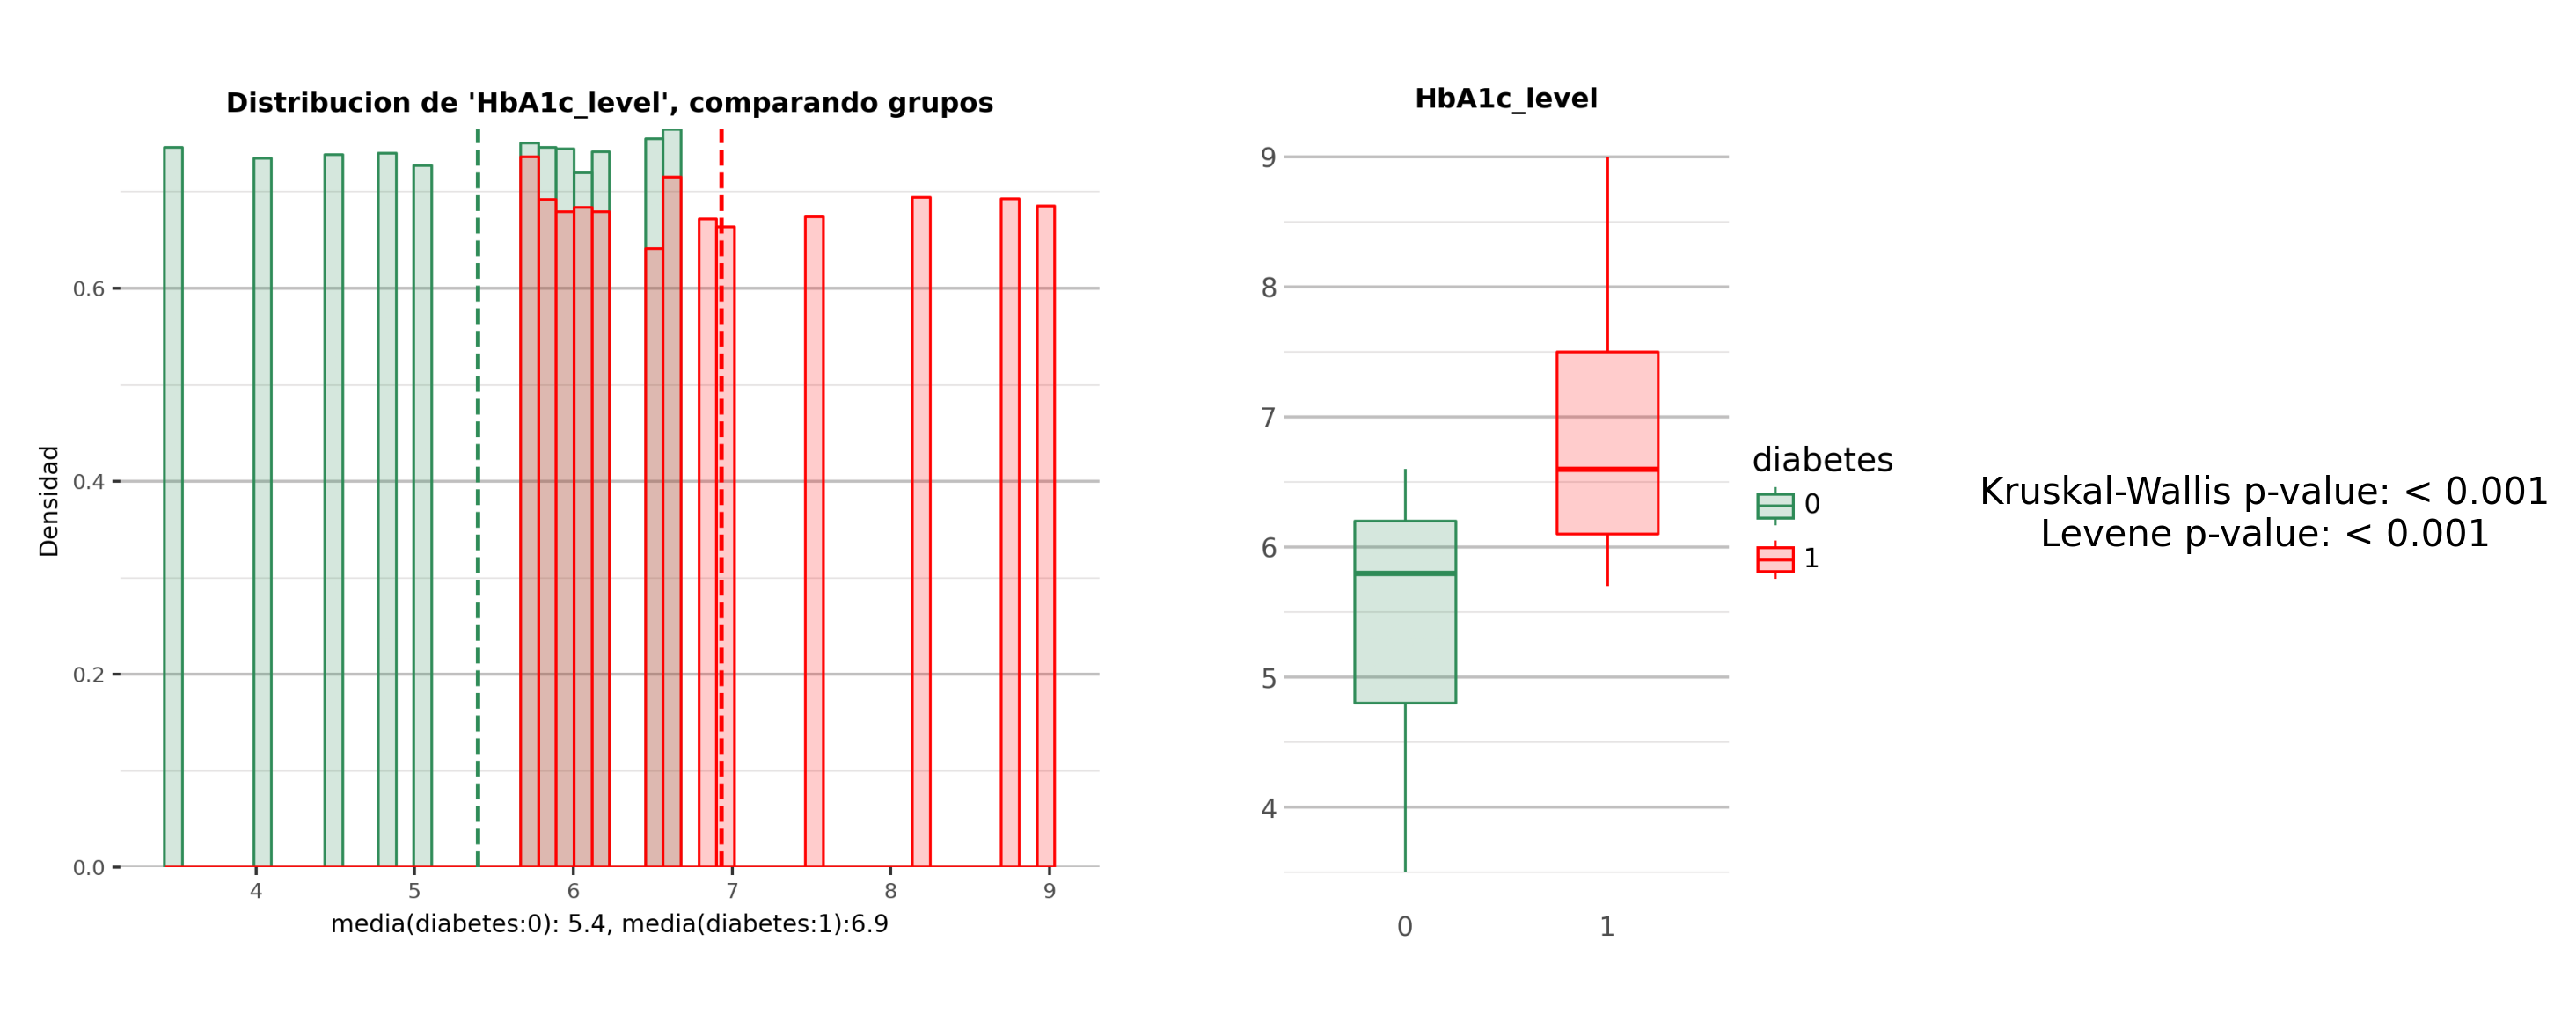

In [101]:
col=numeric_var[2]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### blood_glucose_level

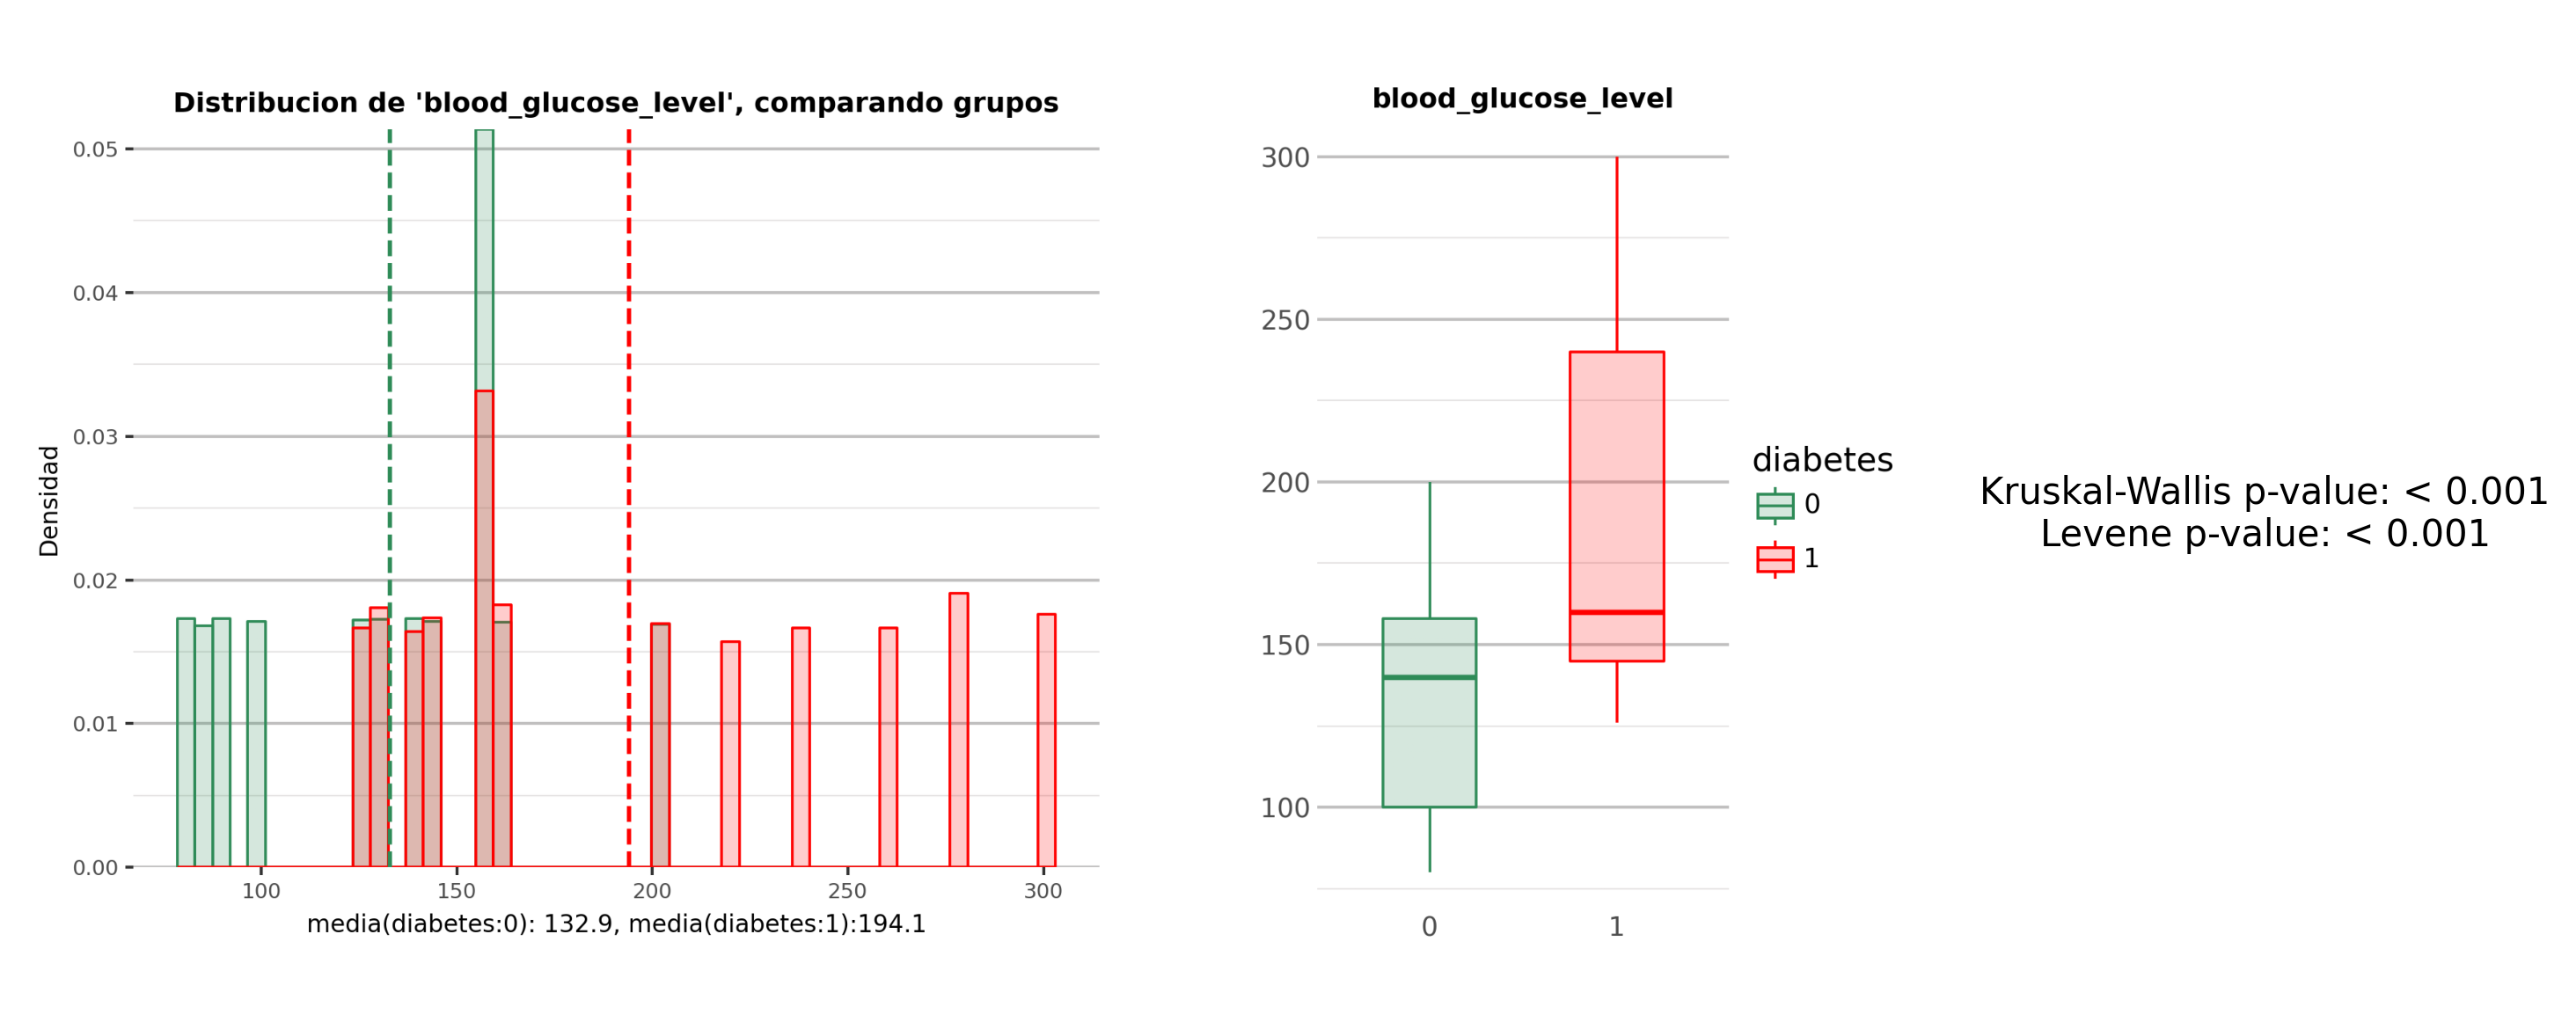

In [102]:
col=numeric_var[3]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

#### Contrastes estadísticos entre grupos (variables cuantitativas)

Para todas las variables cuantitativas analizadas (edad, BMI, HbA1c y nivel de glucosa), los contrastes estadísticos muestran resultados consistentes. El test de Kruskal–Wallis (p < 0.001) permite rechazar la hipótesis nula de igualdad de distribuciones, indicando diferencias estadísticamente significativas entre individuos con y sin diabetes. Asimismo, el test de Levene (p < 0.001) rechaza la hipótesis de homogeneidad de varianzas, evidenciando una dispersión distinta de estas variables entre ambos grupos.

#### Matriz de correlación variables continuas

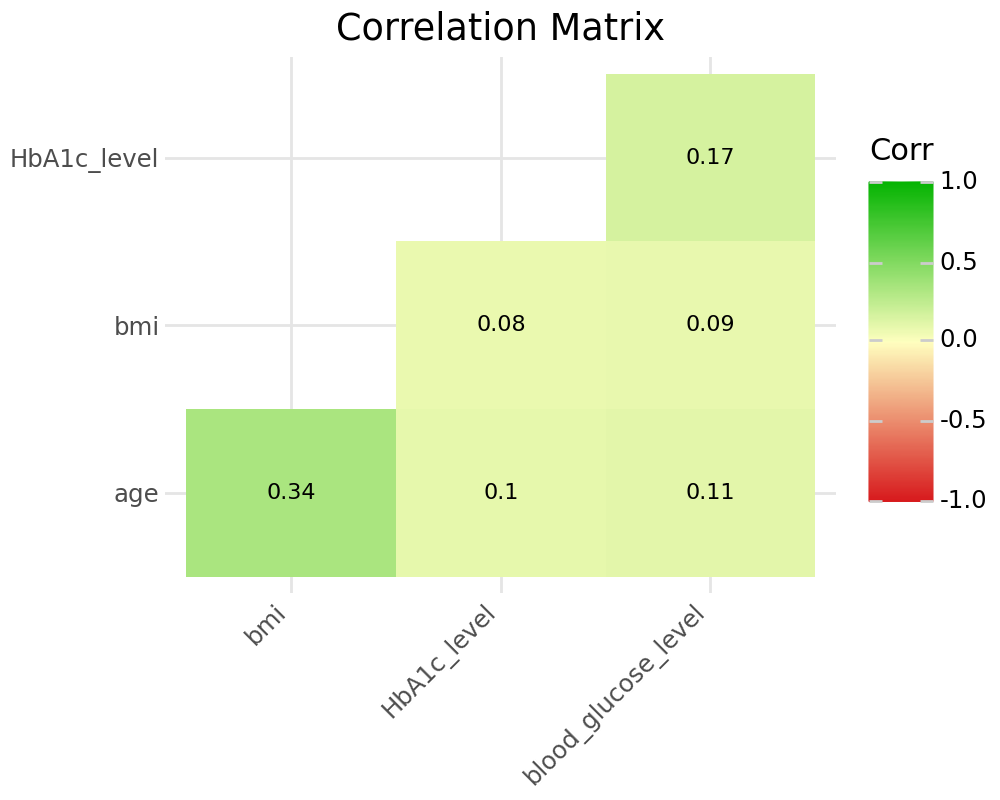

In [103]:
ut.corr_plot(data,numeric_var,(5,4)).show()

No se observan correlaciones relevantes entre variables continuas, se puede afirmar que son linealmente independientes

### 2.7. Análisis bi-variantes, variables categóricas.

In [104]:
# Eliminamos diabetes de las variables categoricas
categoric_var.remove('diabetes')

### gender

Frecuencia                        Porcentaje por clase             
diabetes          0     1 Total Frecuencia                    0     1  Total
gender                                                                      
Female        54071  4449            58520                92.40  7.60  100.0
Male          37379  4036            41415                90.25  9.75  100.0
Total         91450  8485            99935                91.51  8.49  100.0

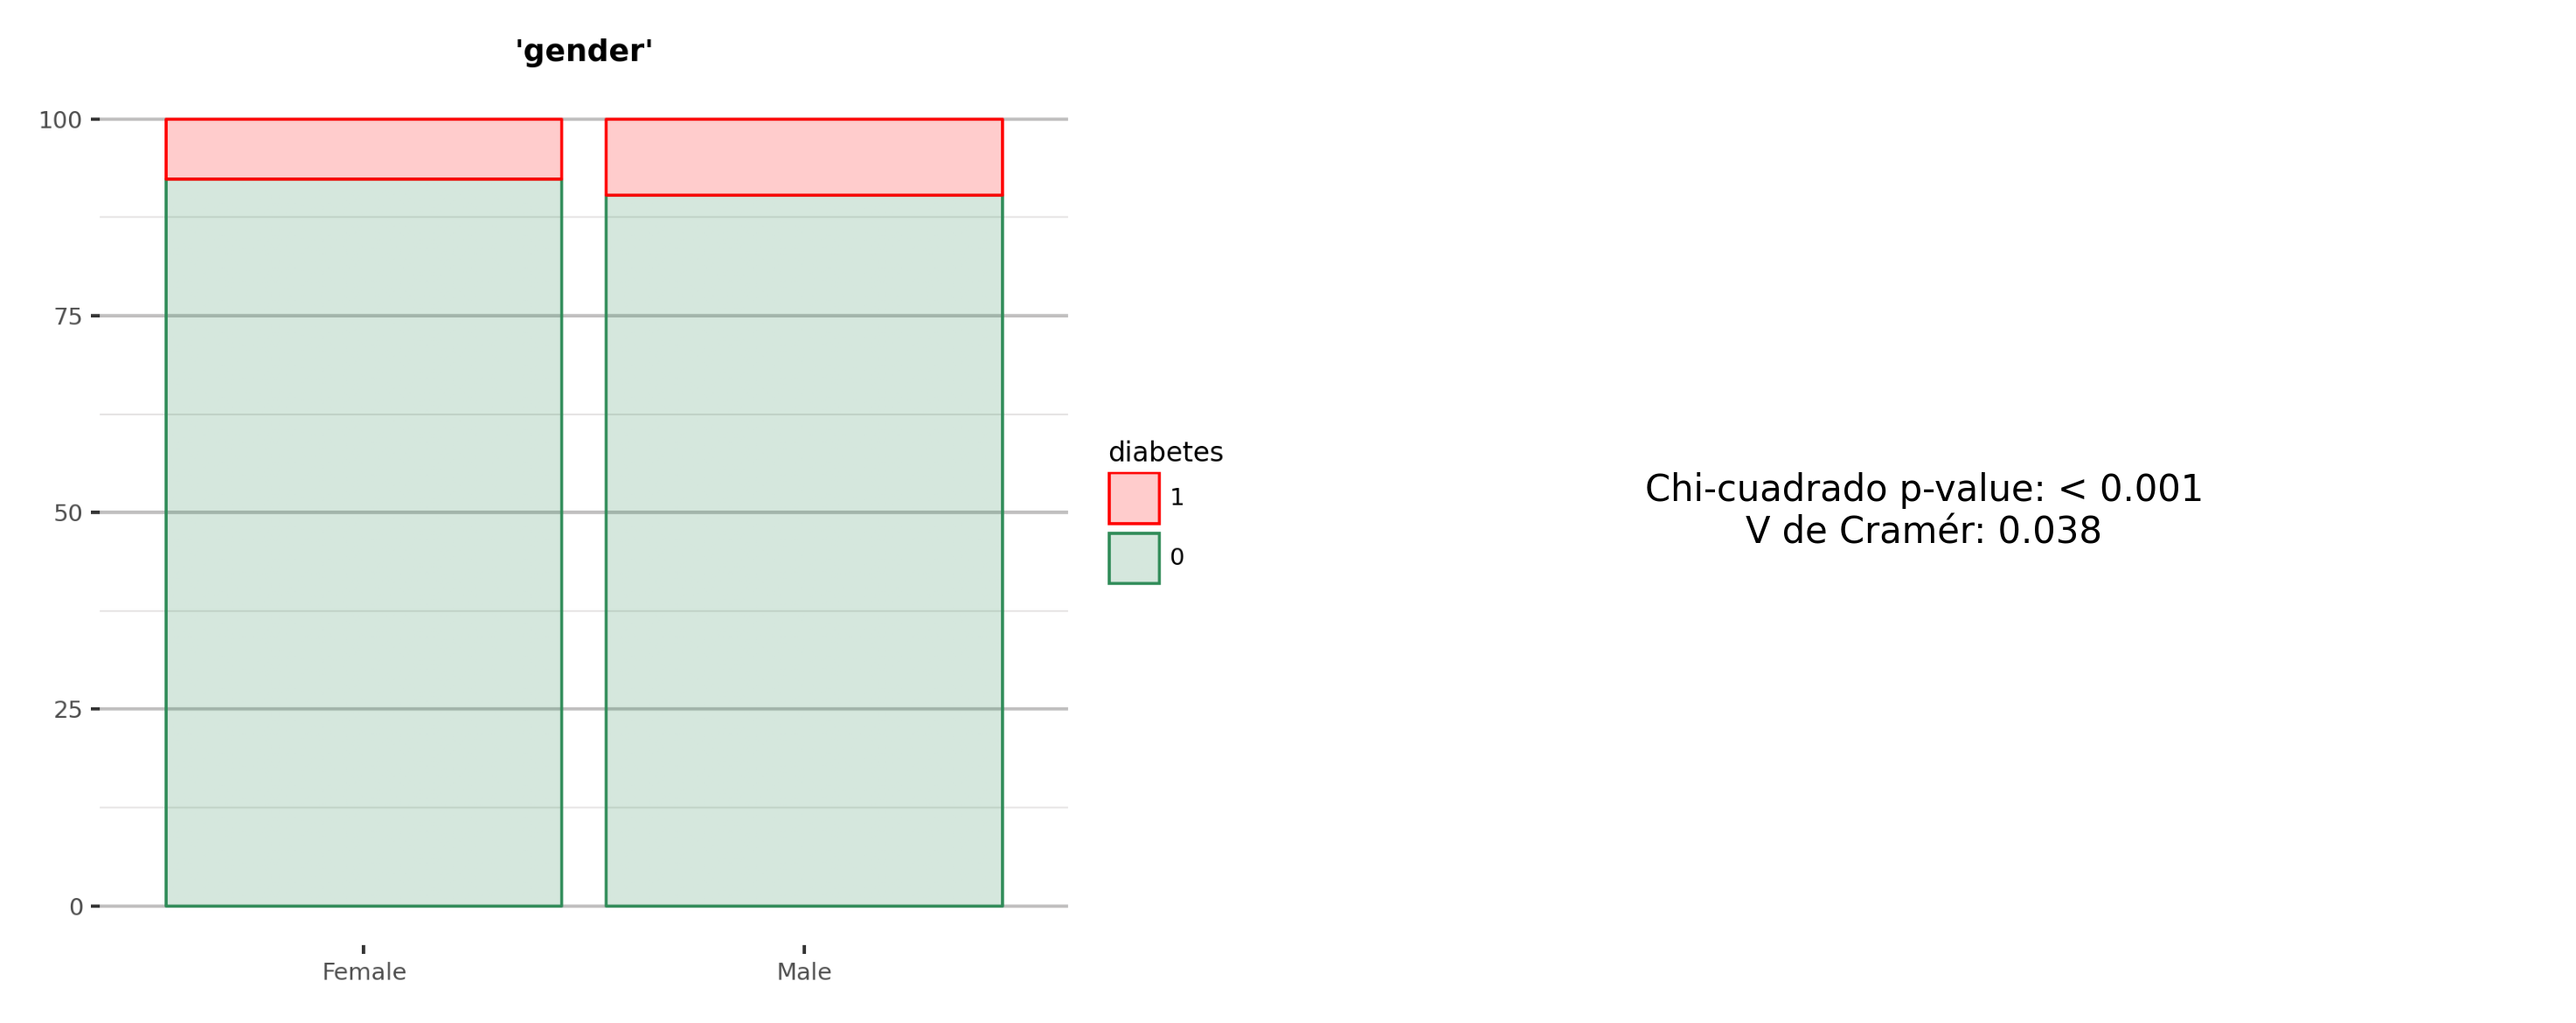

In [105]:
col = categoric_var[0]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### smoking_history

Frecuencia                        Porcentaje por clase         \
diabetes                 0     1 Total Frecuencia                    0      1   
smoking_history                                                                 
No Info              34347  1453            35800                95.94   4.06   
never                31735  3336            35071                90.49   9.51   
current               8333   945             9278                89.81  10.19   
not current           5748   690             6438                89.28  10.72   
ever                  3530   472             4002                88.21  11.79   
former                7757  1589             9346                83.00  17.00   
Total                91450  8485            99935                91.51   8.49   

                        
diabetes         Total  
smoking_history         
No Info          100.0  
never            100.0  
current          100.0  
not current      100.0  
ever             100.0  
former           100.0  
Total            100.0

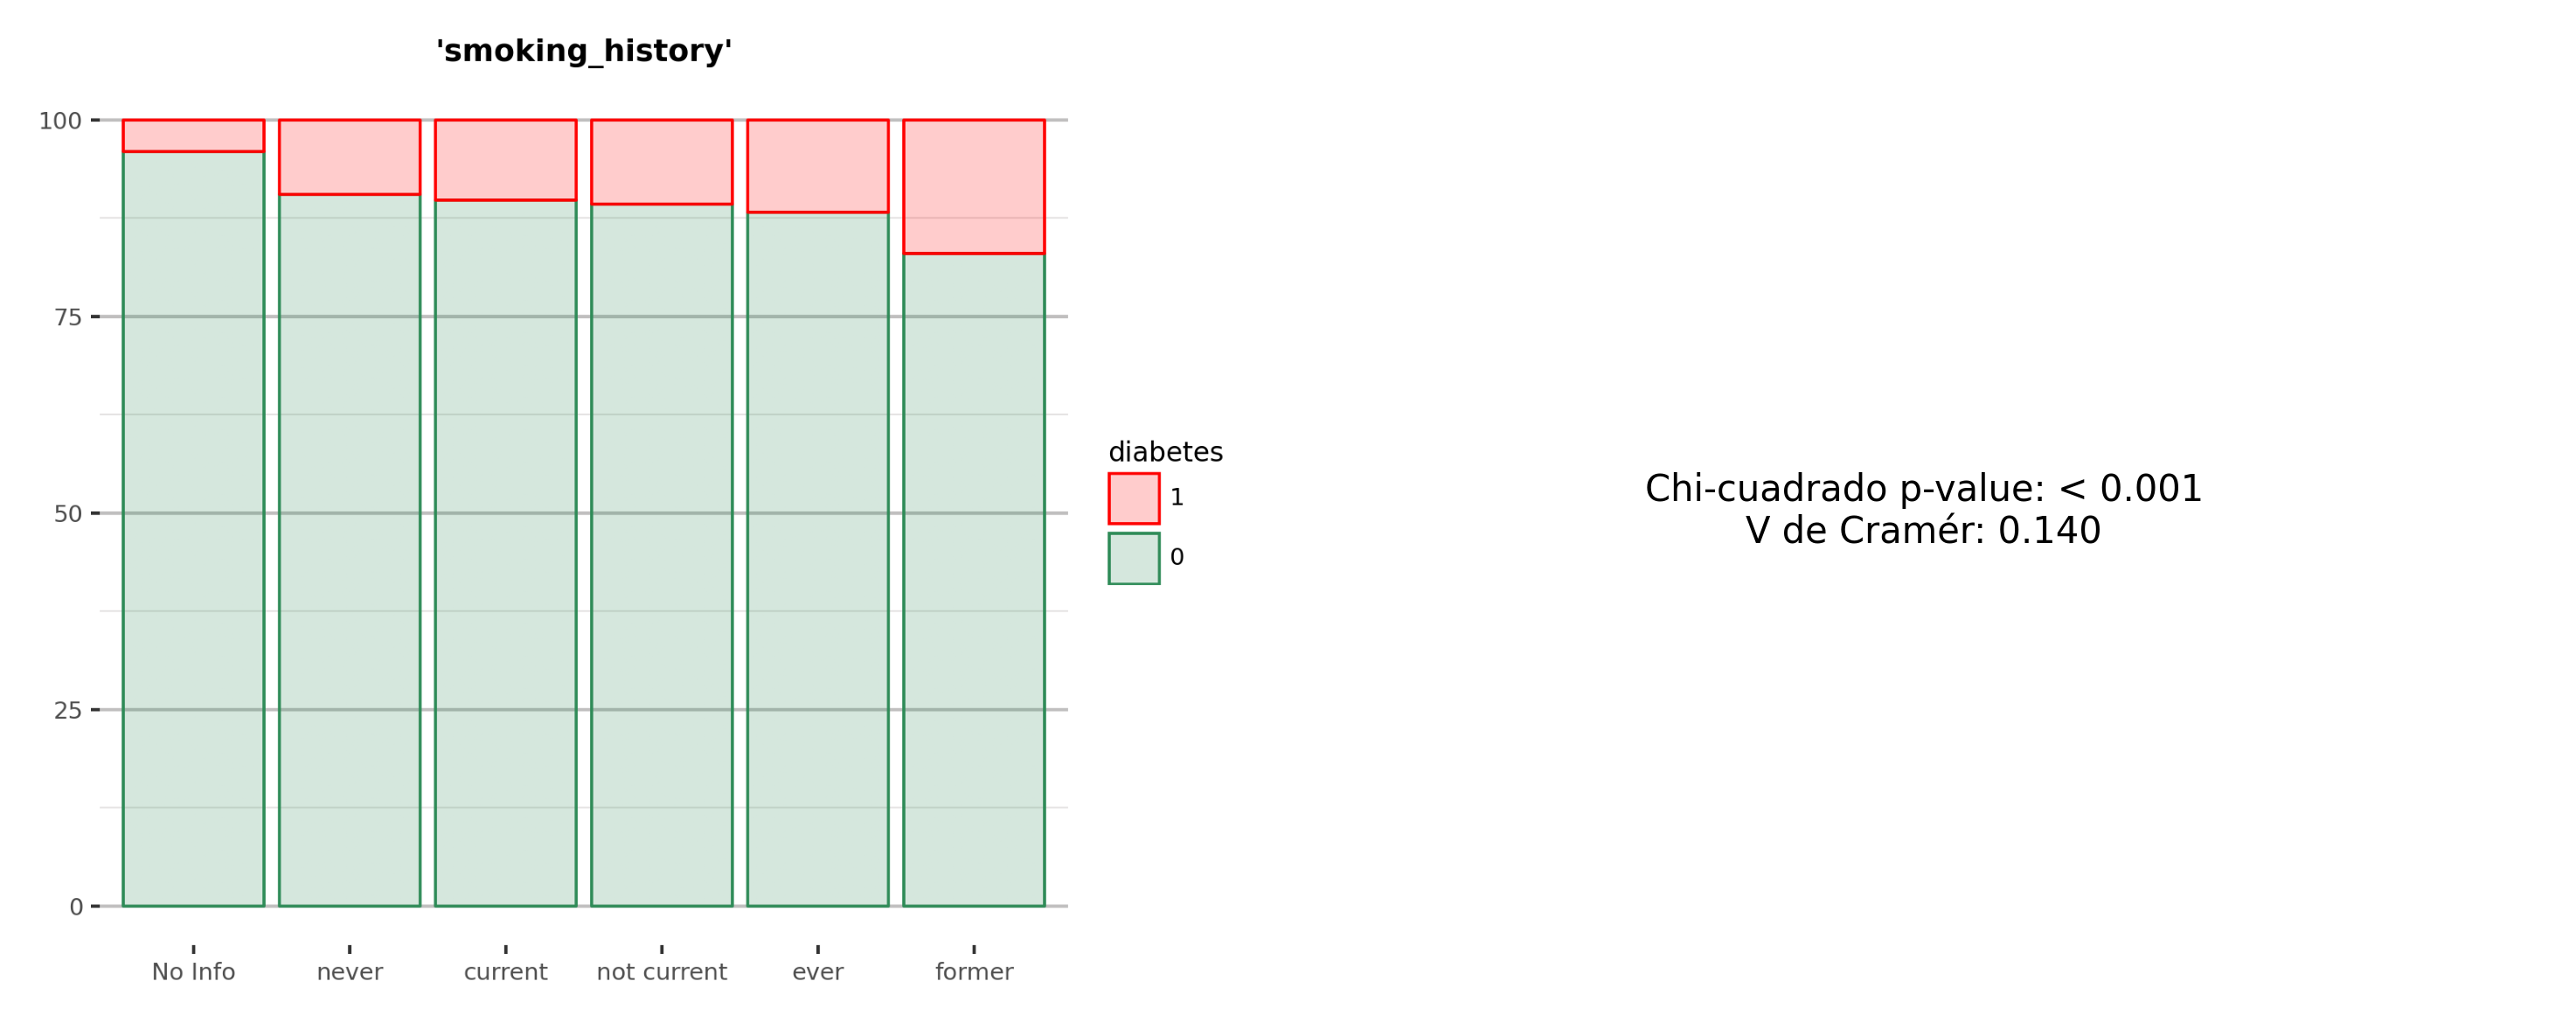

In [106]:
col = categoric_var[1]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

A nivel bivariante, las categorías `current`, `not current` y `ever` presentan prevalencias de diabetes similares (~10–12%), mientras que `former` muestra una prevalencia superior (~17%). Dado este patrón, y buscando un equilibrio entre coherencia interpretativa y simplicidad, se puede considerar la subcategoría `former` como un grupo con comportamiento diferenciado.

### hypertension

Frecuencia                        Porcentaje por clase         \
diabetes              0     1 Total Frecuencia                    0      1   
hypertension                                                                 
0                 86058  6400            92458                93.08   6.92   
1                  5392  2085             7477                72.11  27.89   
Total             91450  8485            99935                91.51   8.49   

                     
diabetes      Total  
hypertension         
0             100.0  
1             100.0  
Total         100.0

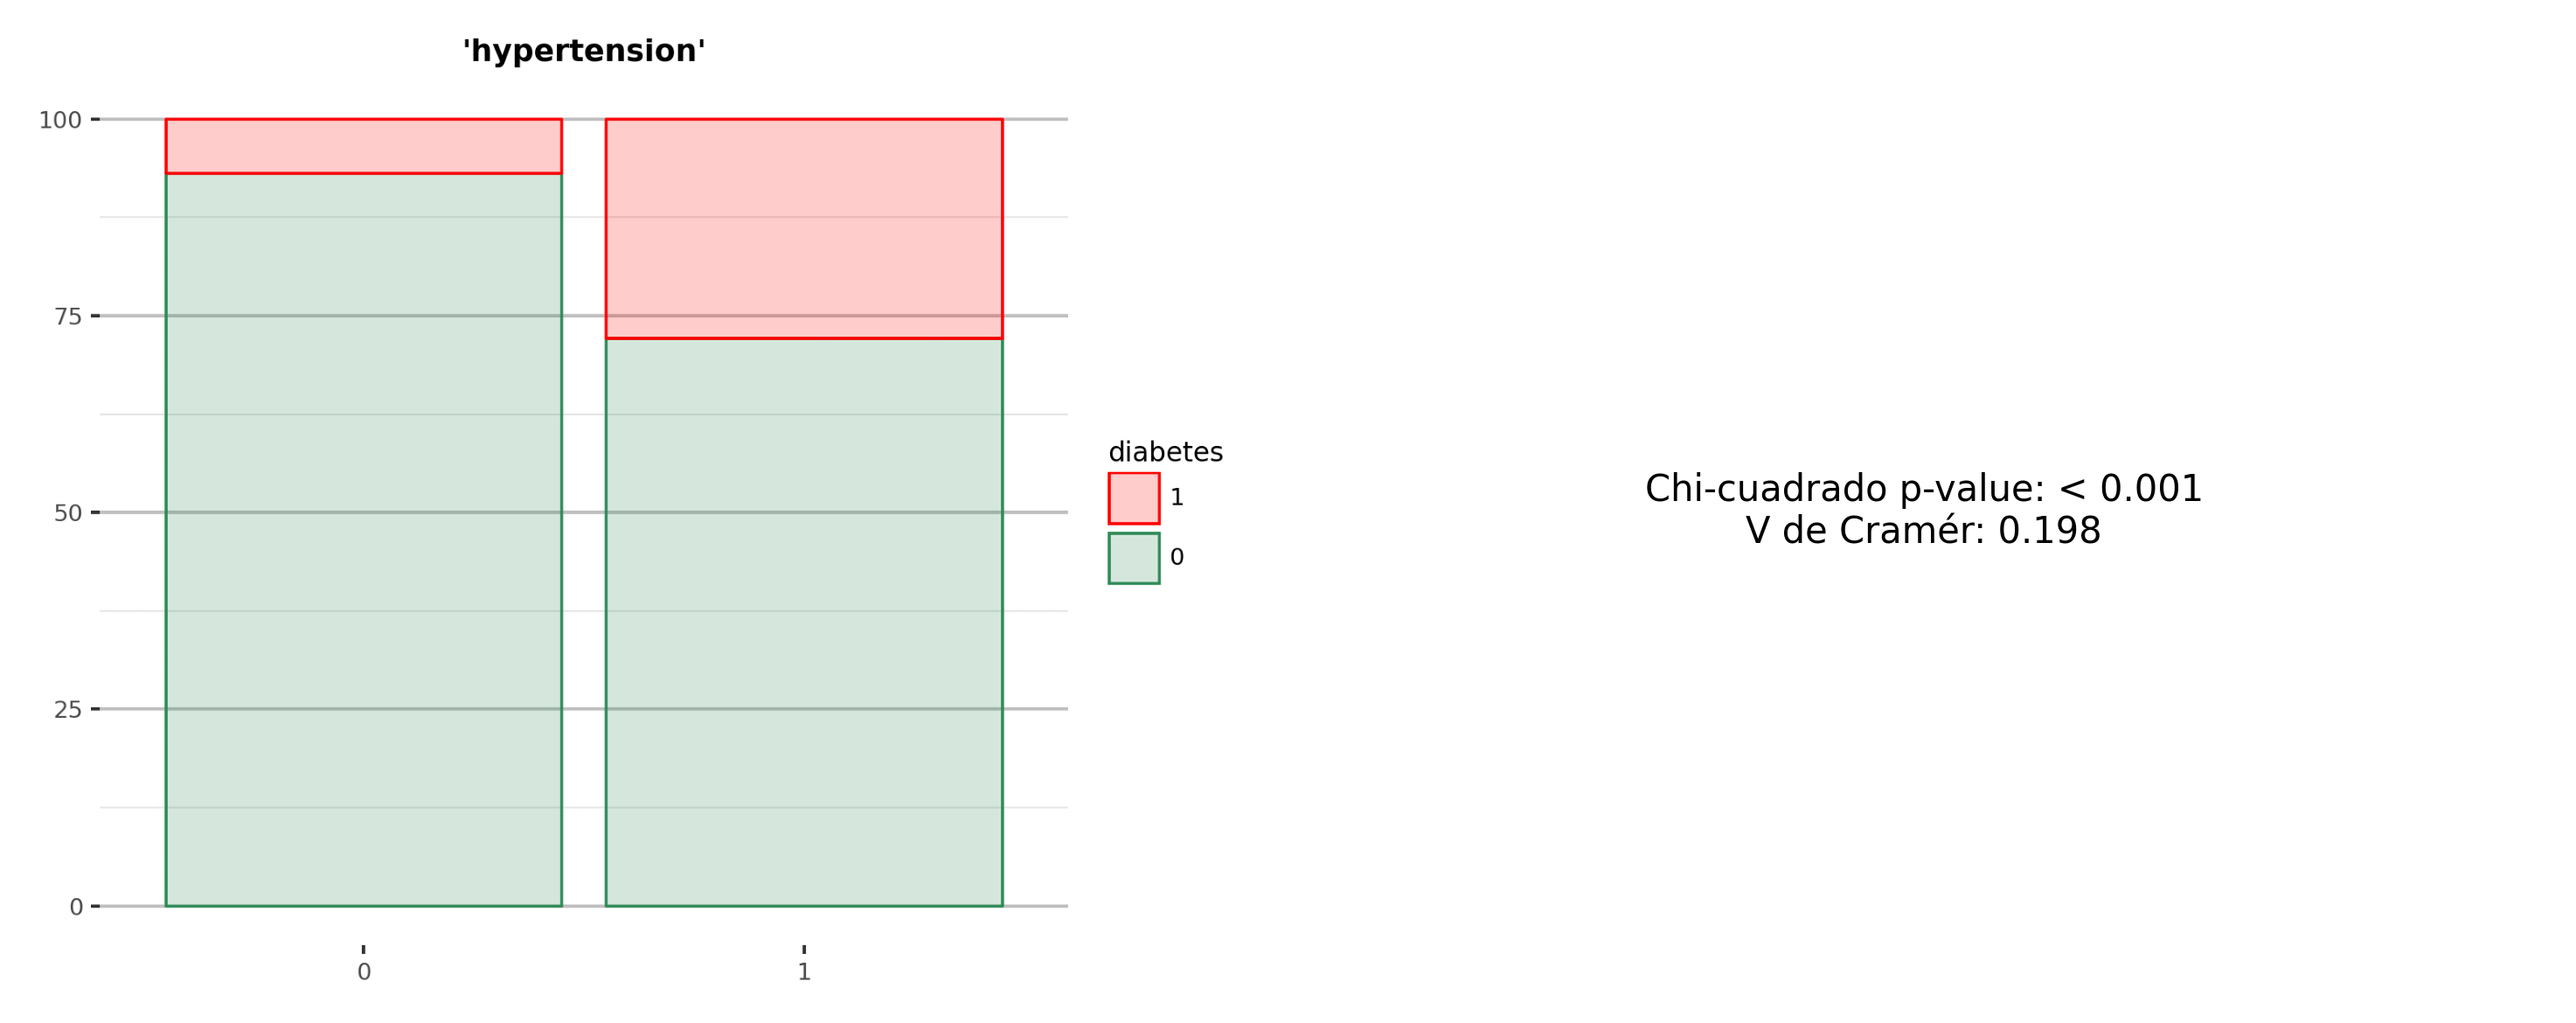

In [107]:
col = categoric_var[2]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### heart_disease

Frecuencia                        Porcentaje por clase         \
diabetes               0     1 Total Frecuencia                    0      1   
heart_disease                                                                 
0                  88778  7218            95996                92.48   7.52   
1                   2672  1267             3939                67.83  32.17   
Total              91450  8485            99935                91.51   8.49   

                      
diabetes       Total  
heart_disease         
0              100.0  
1              100.0  
Total          100.0

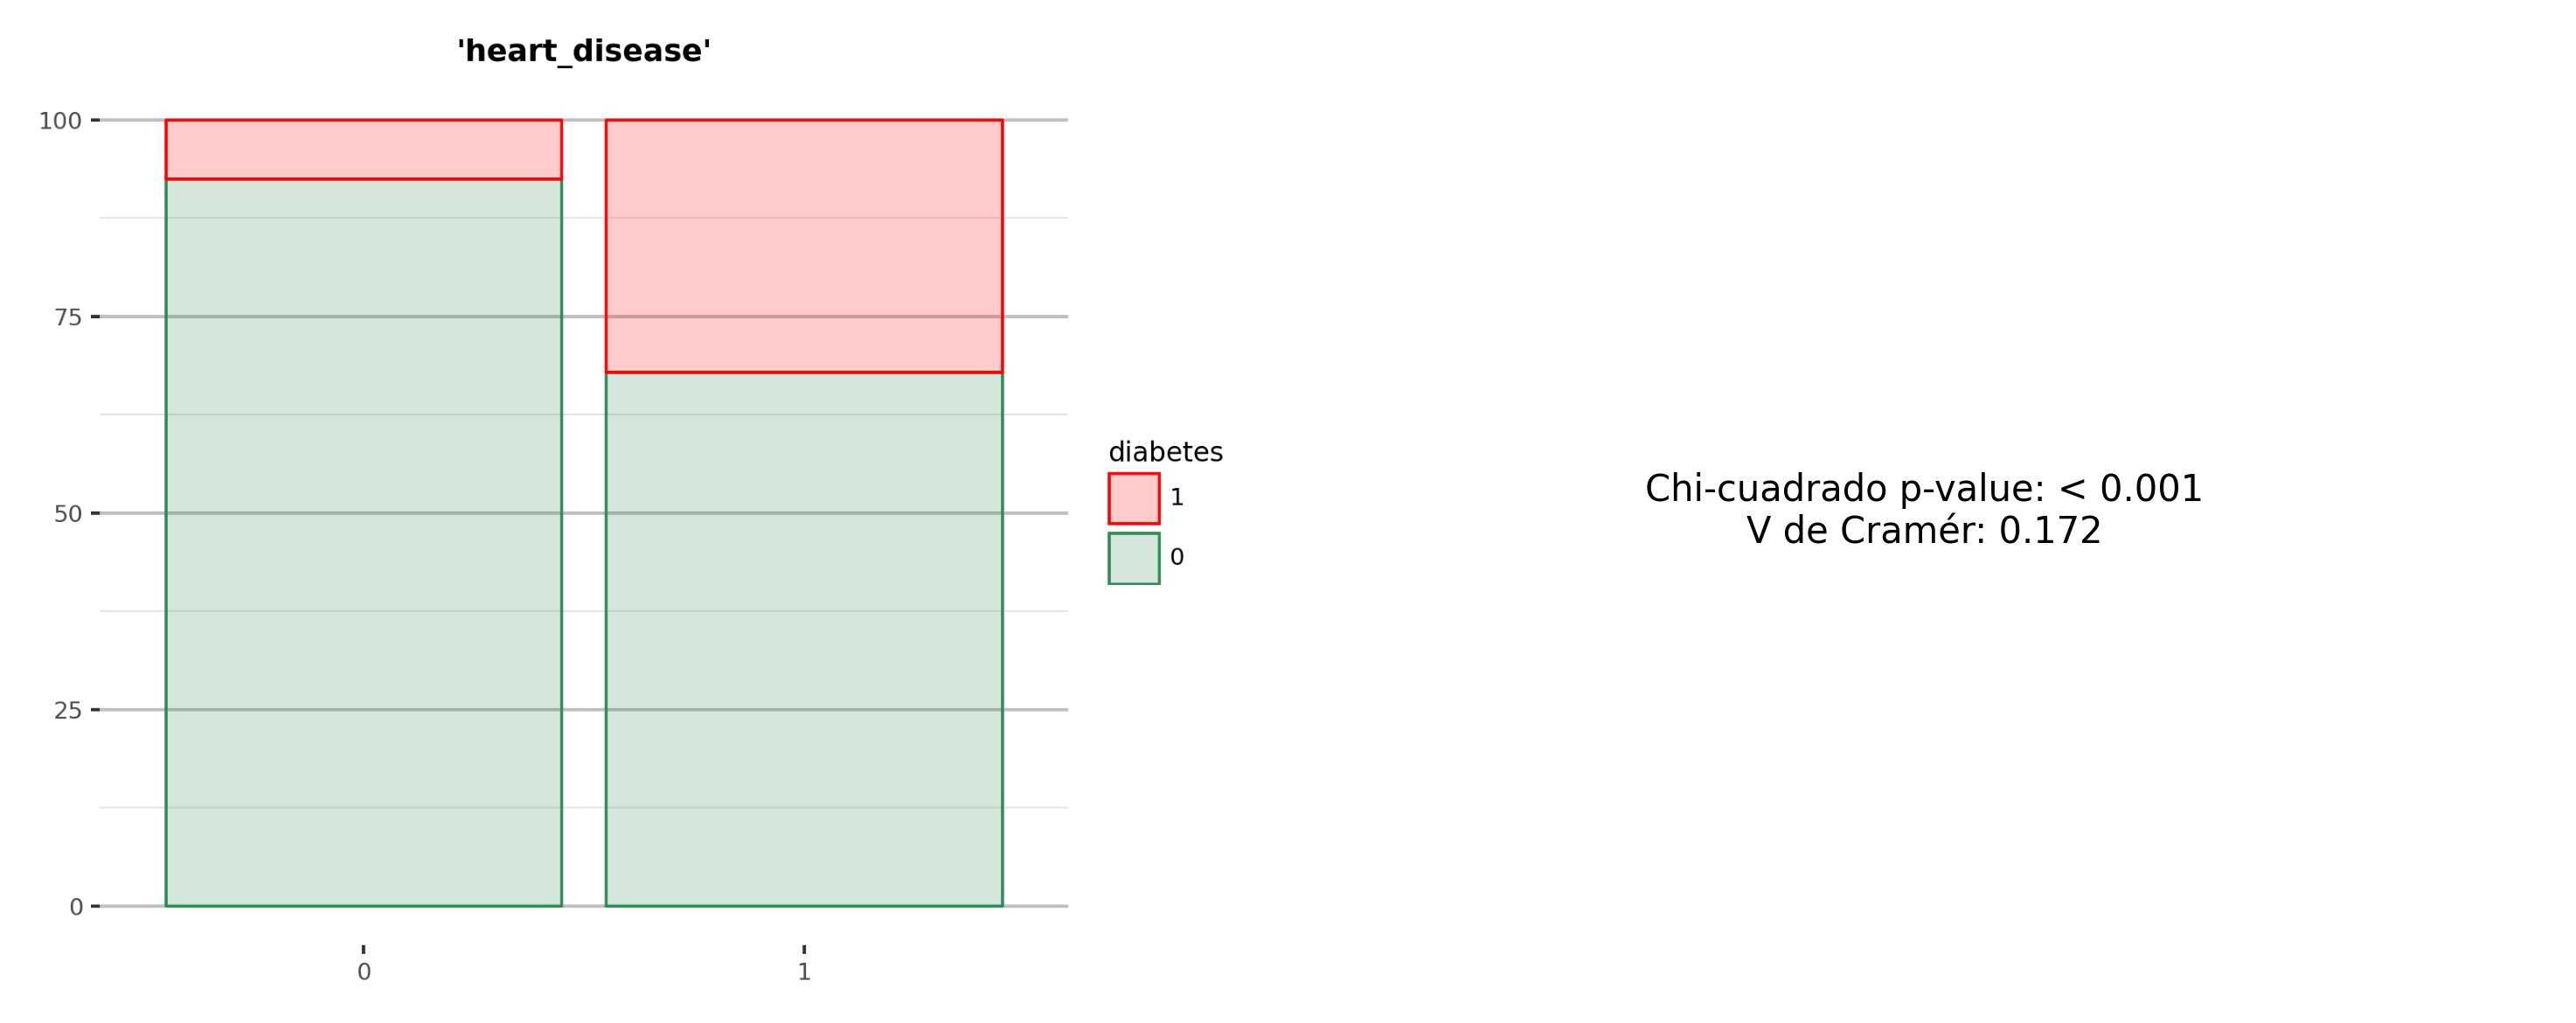

In [108]:
col = categoric_var[3]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### blood_glucose_level_binned

Frecuencia                         \
diabetes                            0     1 Total Frecuencia   
blood_glucose_level_binned                                     
(-inf, 128.00)                  35192   635            35827   
[128.00, 159.50)                42300  3239            45539   
[159.50, 180.00)                 7009   696             7705   
[180.00, inf)                    6949  3915            10864   
Total                           91450  8485            99935   

                           Porcentaje por clase                
diabetes                                      0      1  Total  
blood_glucose_level_binned                                     
(-inf, 128.00)                            98.23   1.77  100.0  
[128.00, 159.50)                          92.89   7.11  100.0  
[159.50, 180.00)                          90.97   9.03  100.0  
[180.00, inf)                             63.96  36.04  100.0  
Total                                     91.51   8.49  100.0

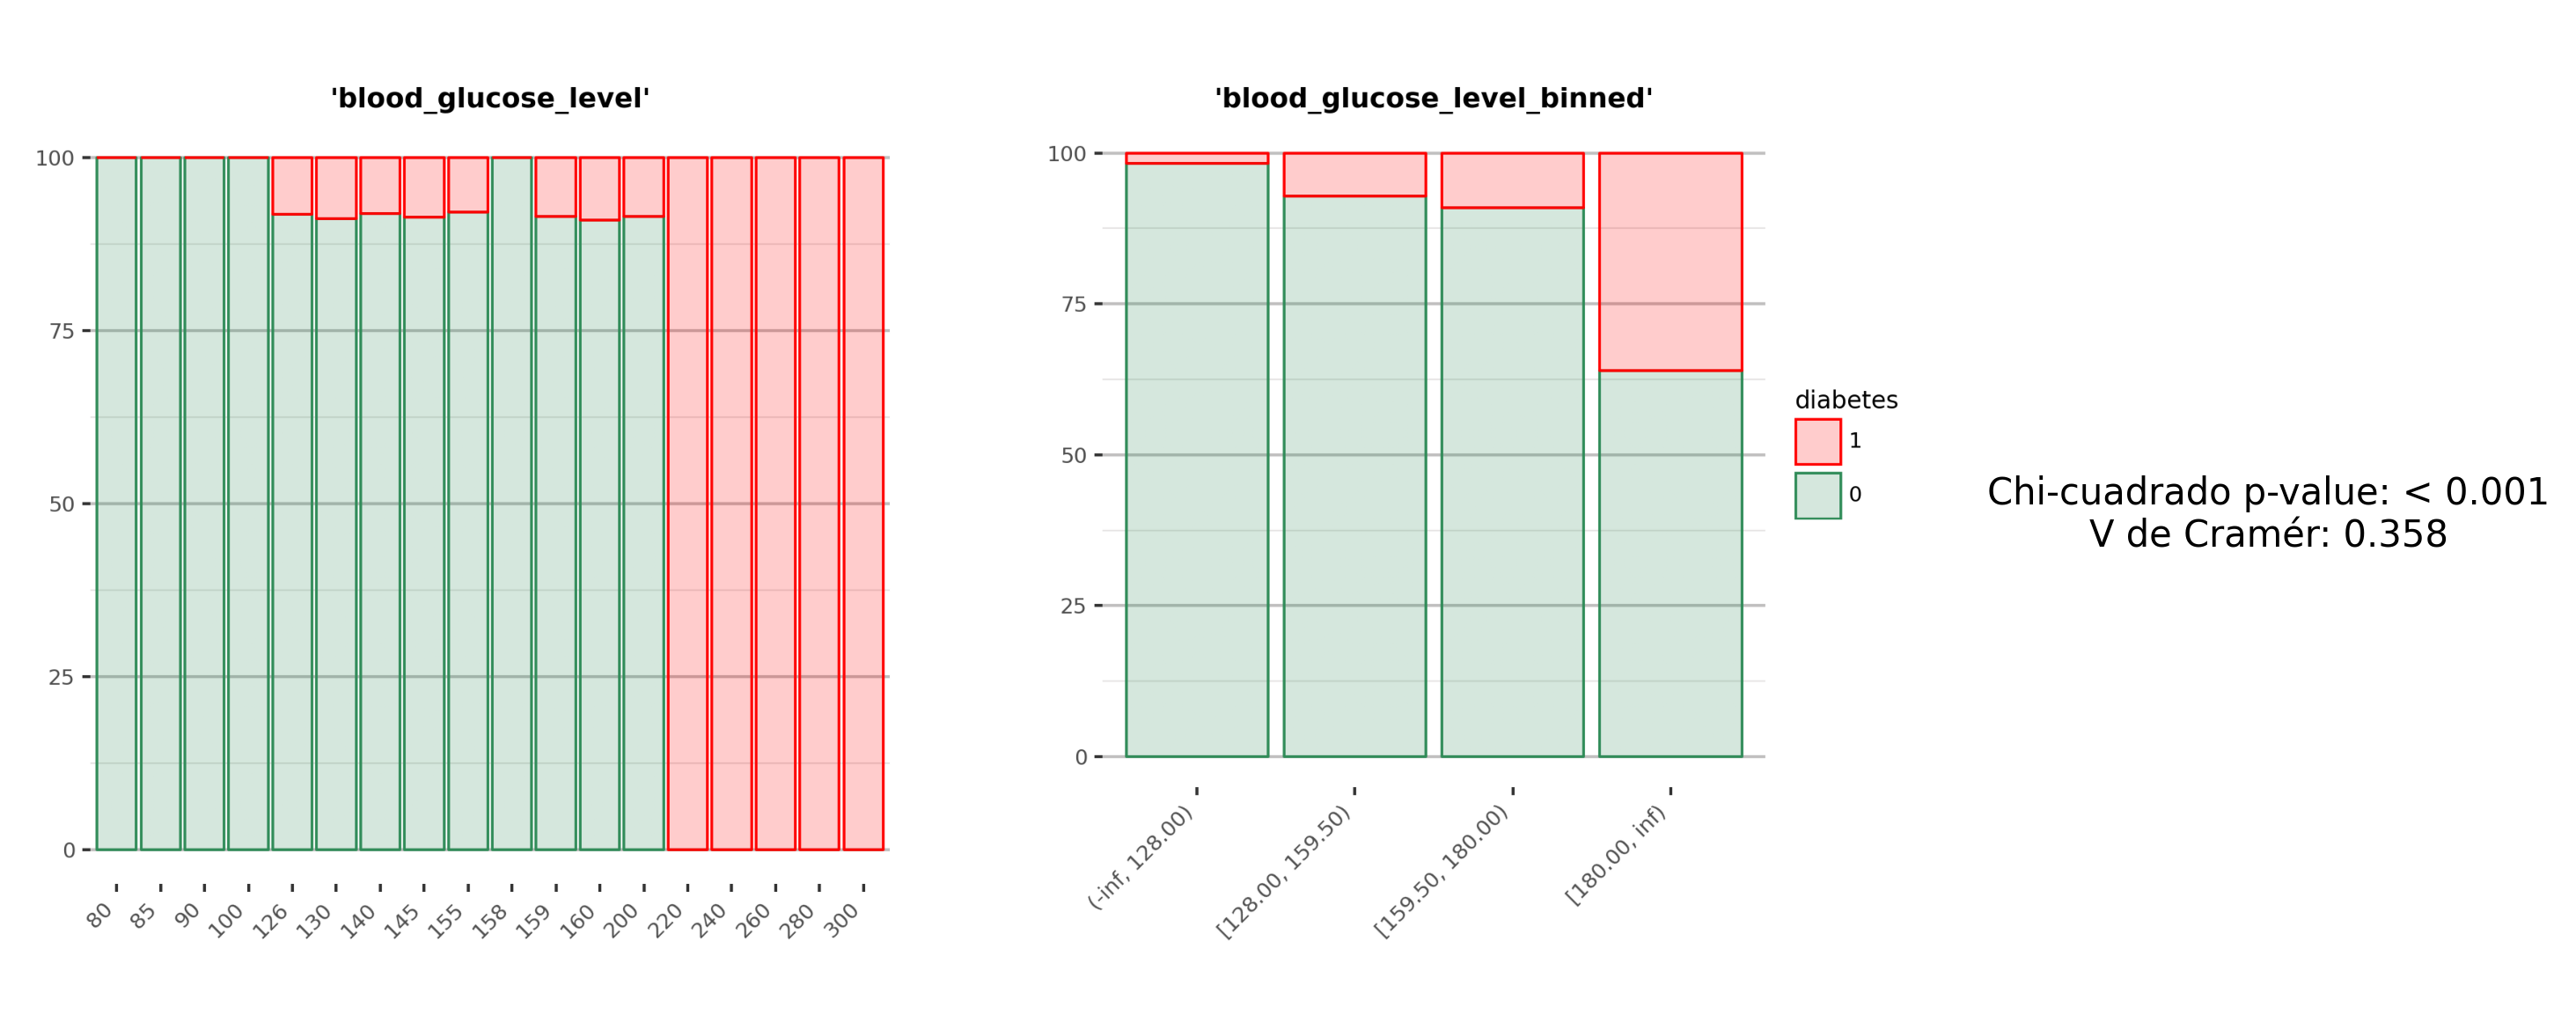

In [109]:
col = categoric_var[4]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)
cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### HbA1c_level_binned

Frecuencia                        Porcentaje por clase  \
diabetes                    0     1 Total Frecuencia                    0   
HbA1c_level_binned                                                          
(-inf, 5.75)            45547   701            46248                98.48   
[5.75, 6.55)            38053  3215            41268                92.21   
[6.55, inf)              7850  4569            12419                63.21   
Total                   91450  8485            99935                91.51   

                                  
diabetes                1  Total  
HbA1c_level_binned                
(-inf, 5.75)         1.52  100.0  
[5.75, 6.55)         7.79  100.0  
[6.55, inf)         36.79  100.0  
Total                8.49  100.0

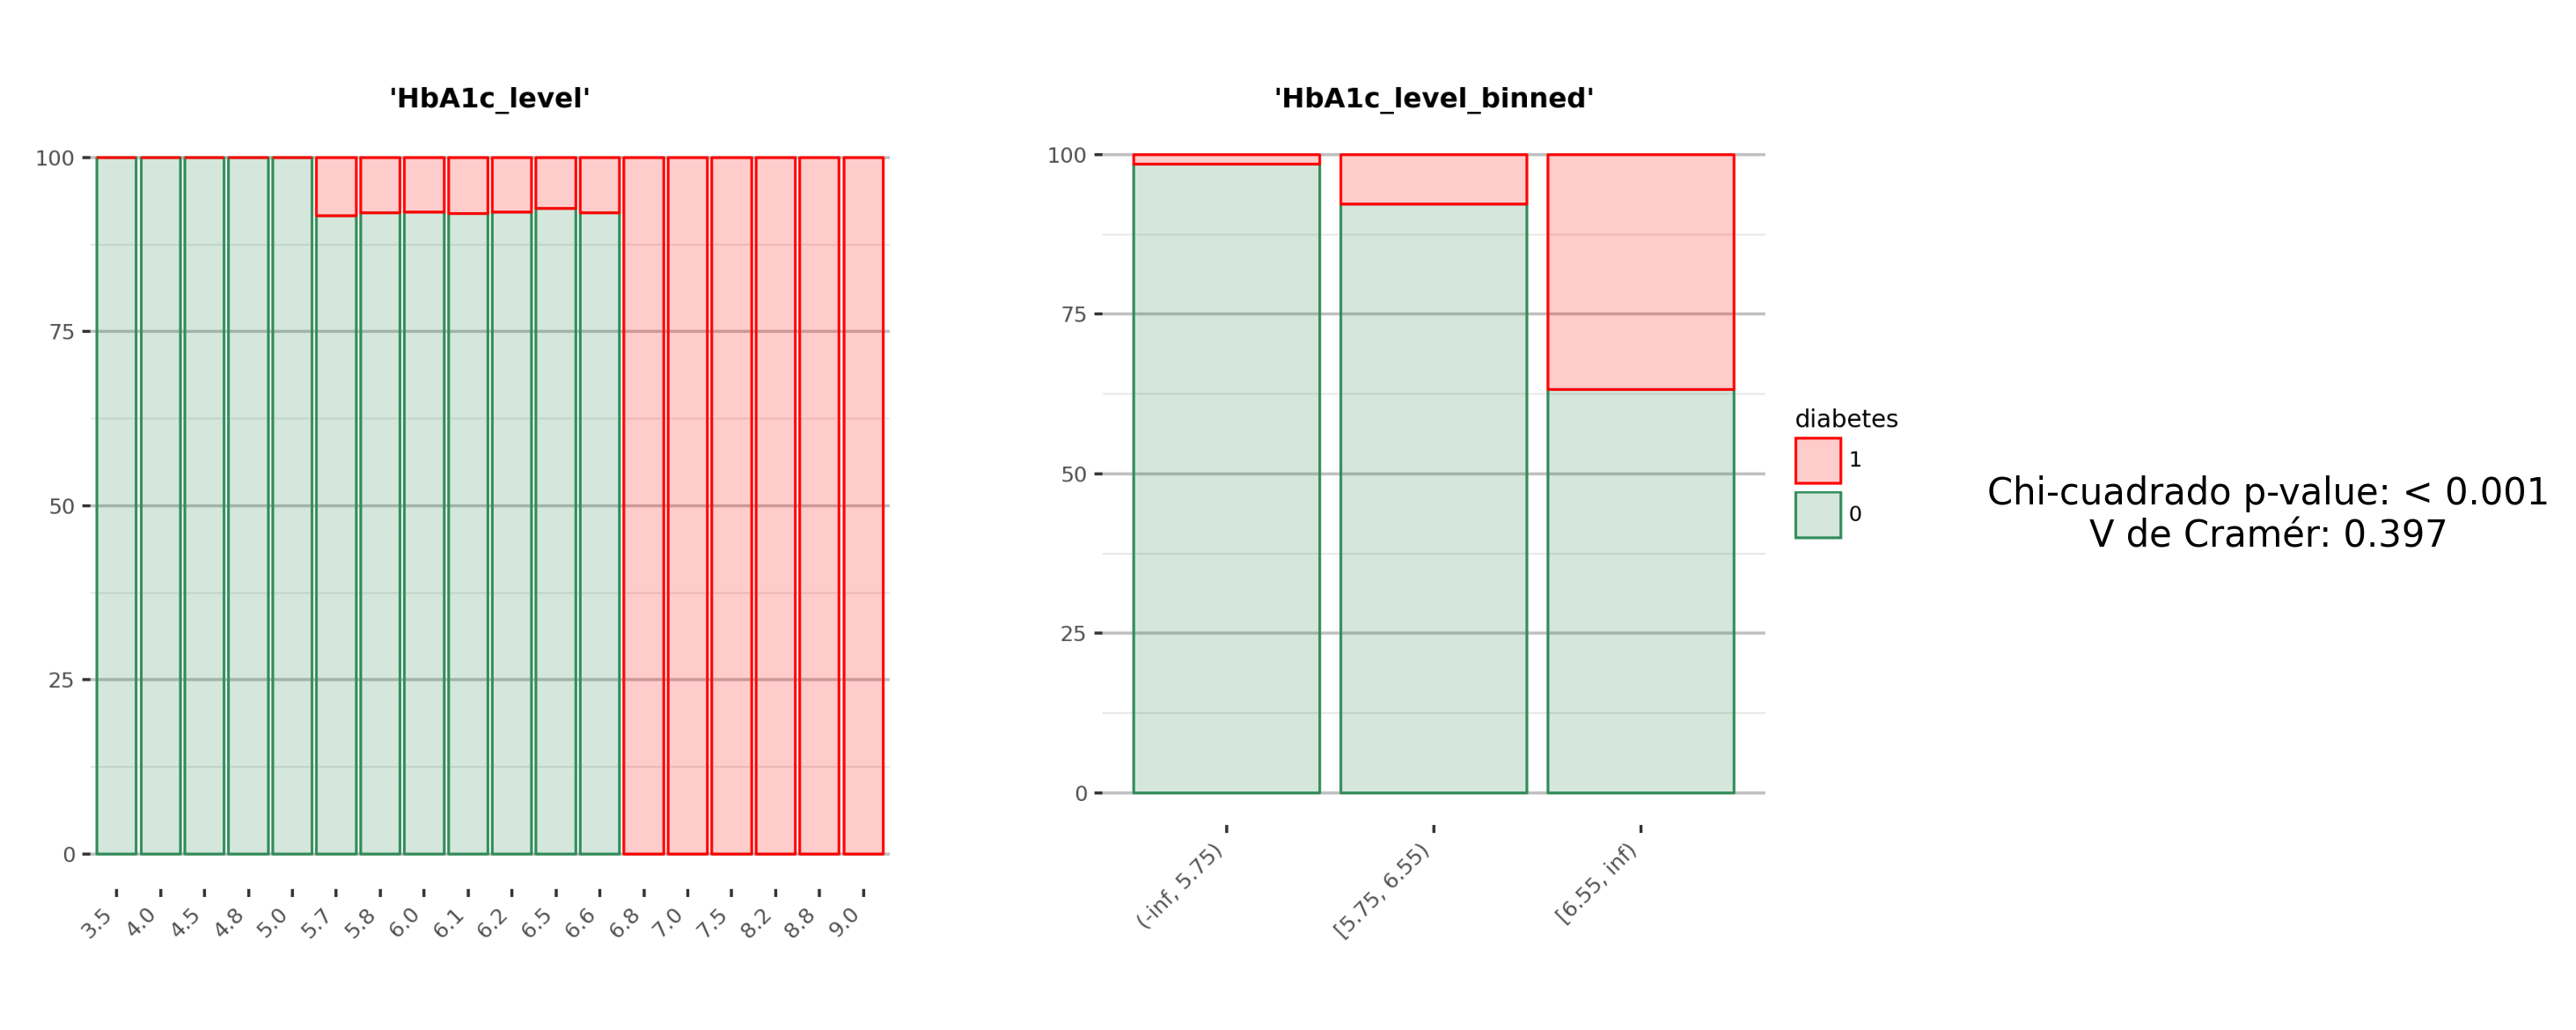

In [110]:
col = categoric_var[5]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)
cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### age_binned

Frecuencia                        Porcentaje por clase         \
diabetes                0     1 Total Frecuencia                    0      1   
bmi_binned                                                                     
(-inf, 16.96)        5246    33             5279                99.37   0.63   
[16.96, 19.30)       4957    53             5010                98.94   1.06   
[19.30, 21.62)       6637   186             6823                97.27   2.73   
[21.62, 24.05)       9284   401             9685                95.86   4.14   
[24.05, 27.77)      38571  2679            41250                93.51   6.49   
[27.77, 30.65)       9466  1161            10627                89.07  10.93   
[30.65, 37.95)      12371  2384            14755                83.84  16.16   
[37.95, inf)         4918  1588             6506                75.59  24.41   
Total               91450  8485            99935                91.51   8.49   

                       
diabetes        Total  
bmi_binned             
(-inf, 16.96)   100.0  
[16.96, 19.30)  100.0  
[19.30, 21.62)  100.0  
[21.62, 24.05)  100.0  
[24.05, 27.77)  100.0  
[27.77, 30.65)  100.0  
[30.65, 37.95)  100.0  
[37.95, inf)    100.0  
Total           100.0

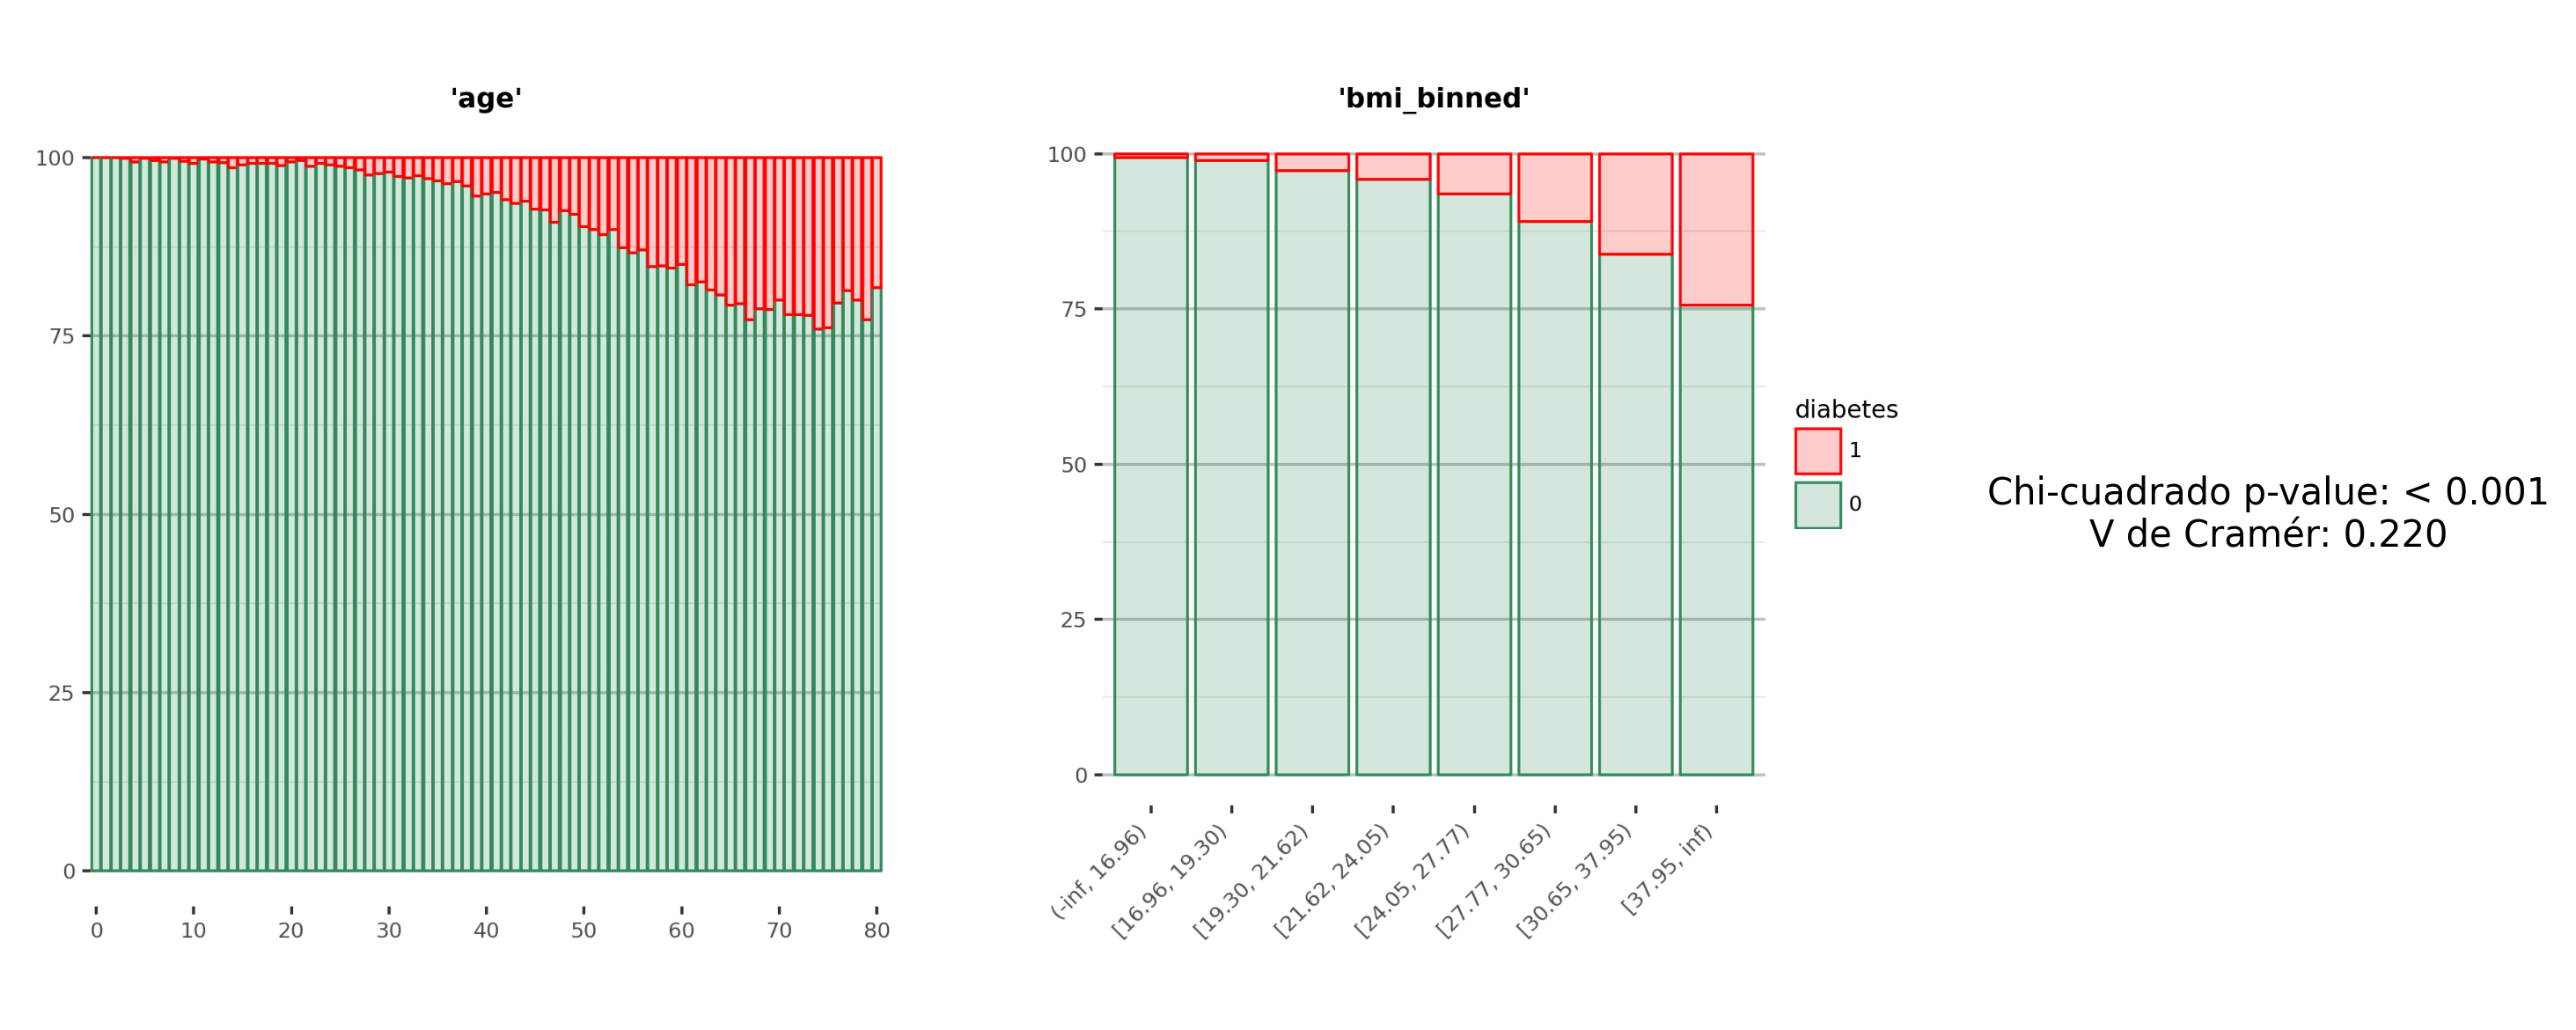

In [111]:
col = categoric_var[7]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)

cat_var_per_group_unbinned = ut.cat_plot_num_unbinned(data, 'age', 'diabetes',
                                                      step=1.0, tick_every=10,
                                                       alt_title="age")

cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### bmi_binned

Frecuencia                        Porcentaje por clase         \
diabetes                0     1 Total Frecuencia                    0      1   
bmi_binned                                                                     
(-inf, 16.96)        5246    33             5279                99.37   0.63   
[16.96, 19.30)       4957    53             5010                98.94   1.06   
[19.30, 21.62)       6637   186             6823                97.27   2.73   
[21.62, 24.05)       9284   401             9685                95.86   4.14   
[24.05, 27.77)      38571  2679            41250                93.51   6.49   
[27.77, 30.65)       9466  1161            10627                89.07  10.93   
[30.65, 37.95)      12371  2384            14755                83.84  16.16   
[37.95, inf)         4918  1588             6506                75.59  24.41   
Total               91450  8485            99935                91.51   8.49   

                       
diabetes        Total  
bmi_binned             
(-inf, 16.96)   100.0  
[16.96, 19.30)  100.0  
[19.30, 21.62)  100.0  
[21.62, 24.05)  100.0  
[24.05, 27.77)  100.0  
[27.77, 30.65)  100.0  
[30.65, 37.95)  100.0  
[37.95, inf)    100.0  
Total           100.0

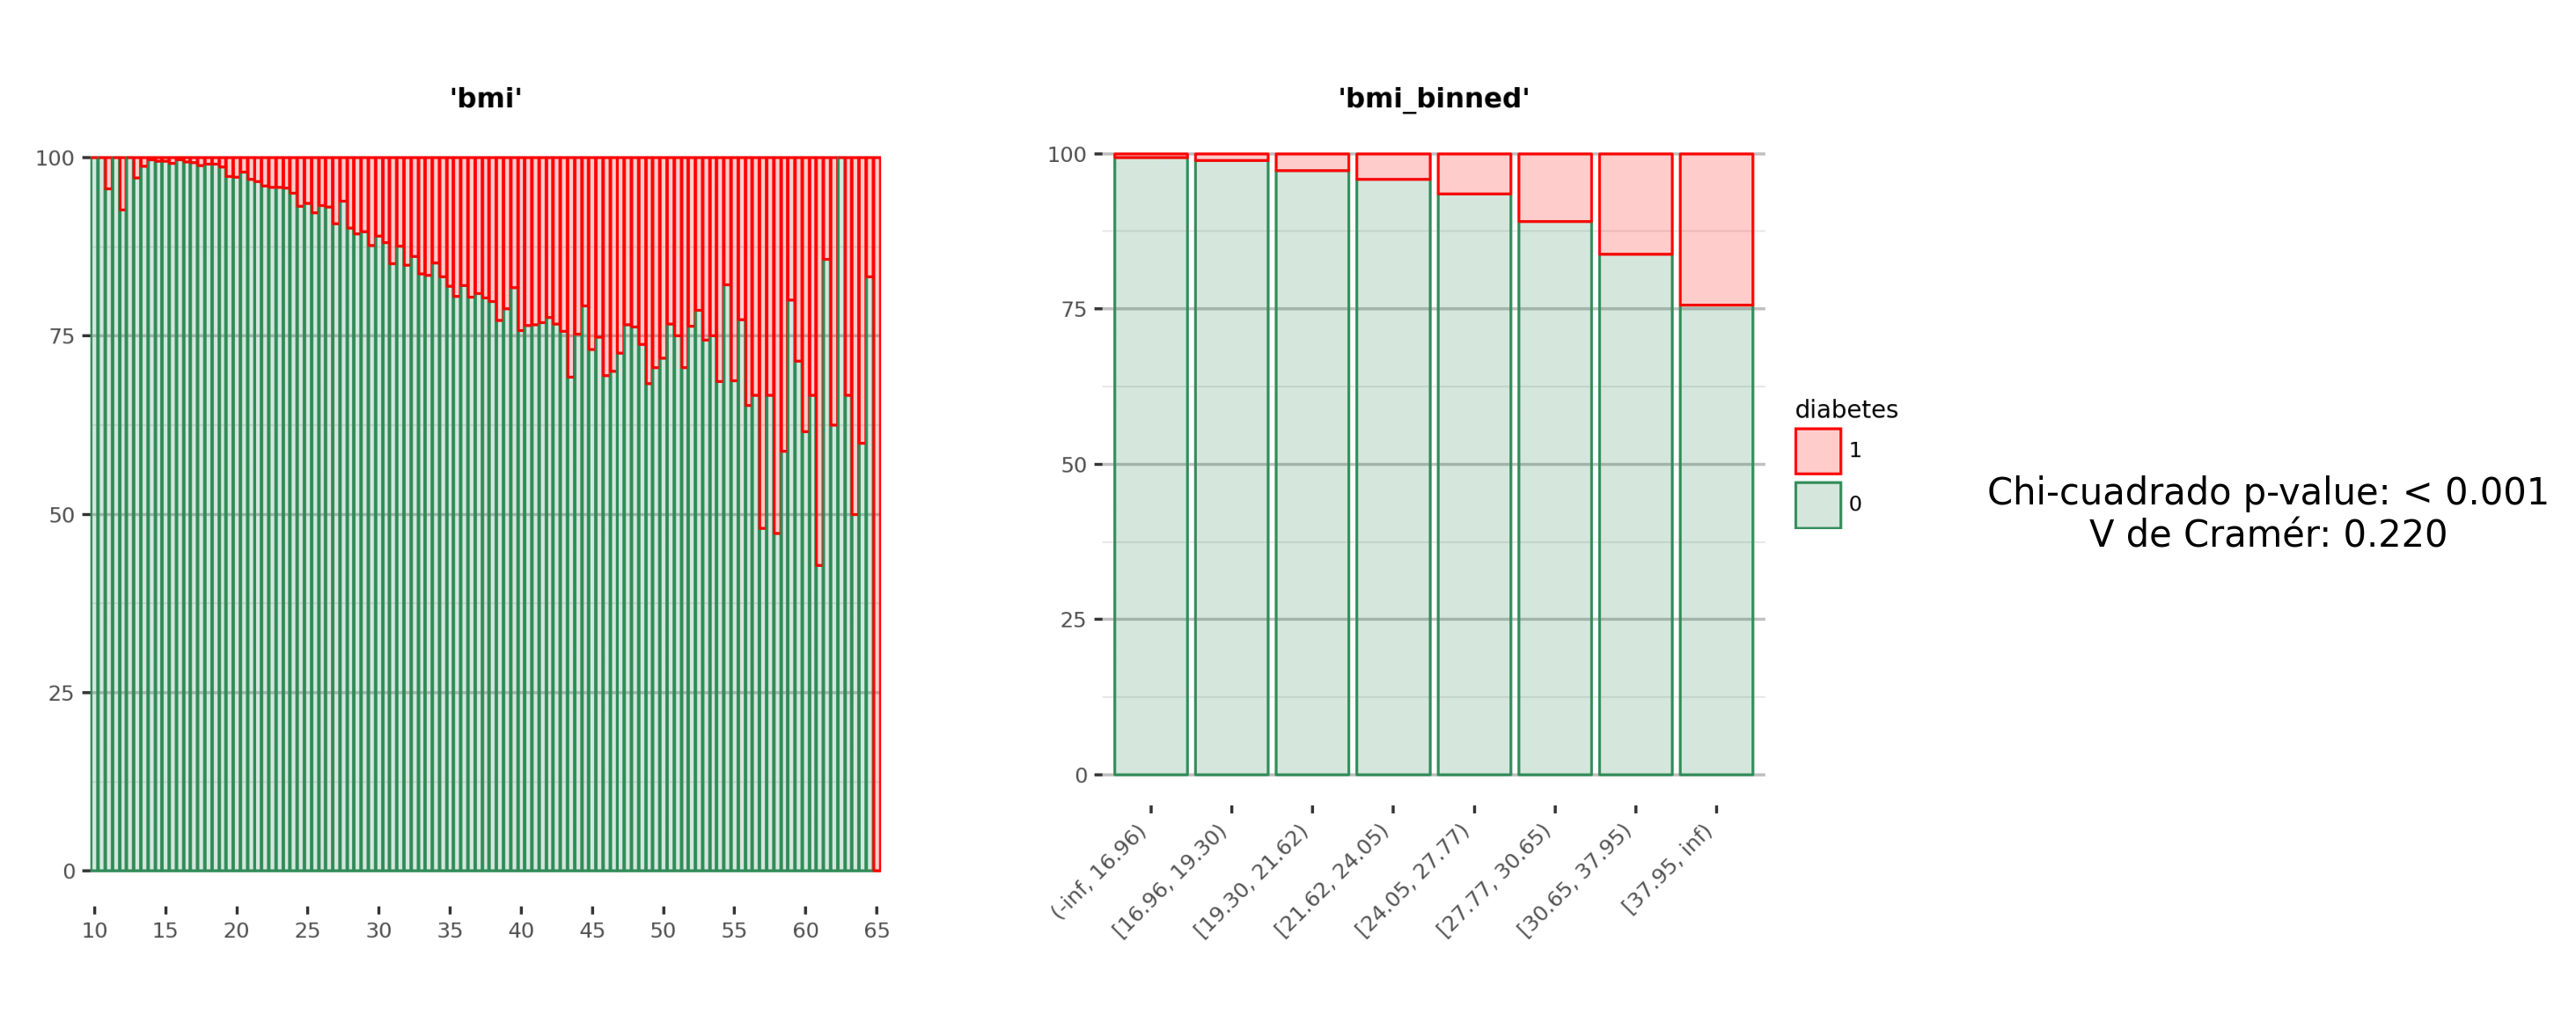

In [112]:
col = categoric_var[7]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)

cat_var_per_group_unbinned = ut.cat_plot_num_unbinned(data, 'bmi', 'diabetes',
                                                      step=0.5, tick_every=5,
                                                       alt_title="bmi")

cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

#### Contrastes estadísticos entre grupos (variables categóricas)

Para las variables categóricas analizadas se ha aplicado el test Chi-cuadrado de independencia, utilizando el V de Cramér como medida del tamaño del efecto. En todos los casos, el contraste resulta estadísticamente significativo (p < 0.001), lo que indica la existencia de asociación entre las variables consideradas y el estado de diabetes. Sin embargo, la intensidad de dicha asociación difiere entre variables: el género presenta una asociación muy débil (V = 0.038), mientras que el historial de tabaquismo, la hipertensión y la enfermedad cardíaca muestran asociaciones débiles o débil–moderadas (V entre 0.14 y 0.20). Por el contrario, las variables clínicas discretizadas, HbA1c_level_binned y blood_glucose_level_binned, presentan asociaciones fuertes (V = 0.397 y V = 0.358, respectivamente), lo que sugiere que la discretización captura umbrales clínicamente relevantes y refuerza su utilidad para el modelado predictivo posterior.

---

### 2.8. Análisis multivariante

#### Distribución de las enfermedades según el historial de tabaquismo.

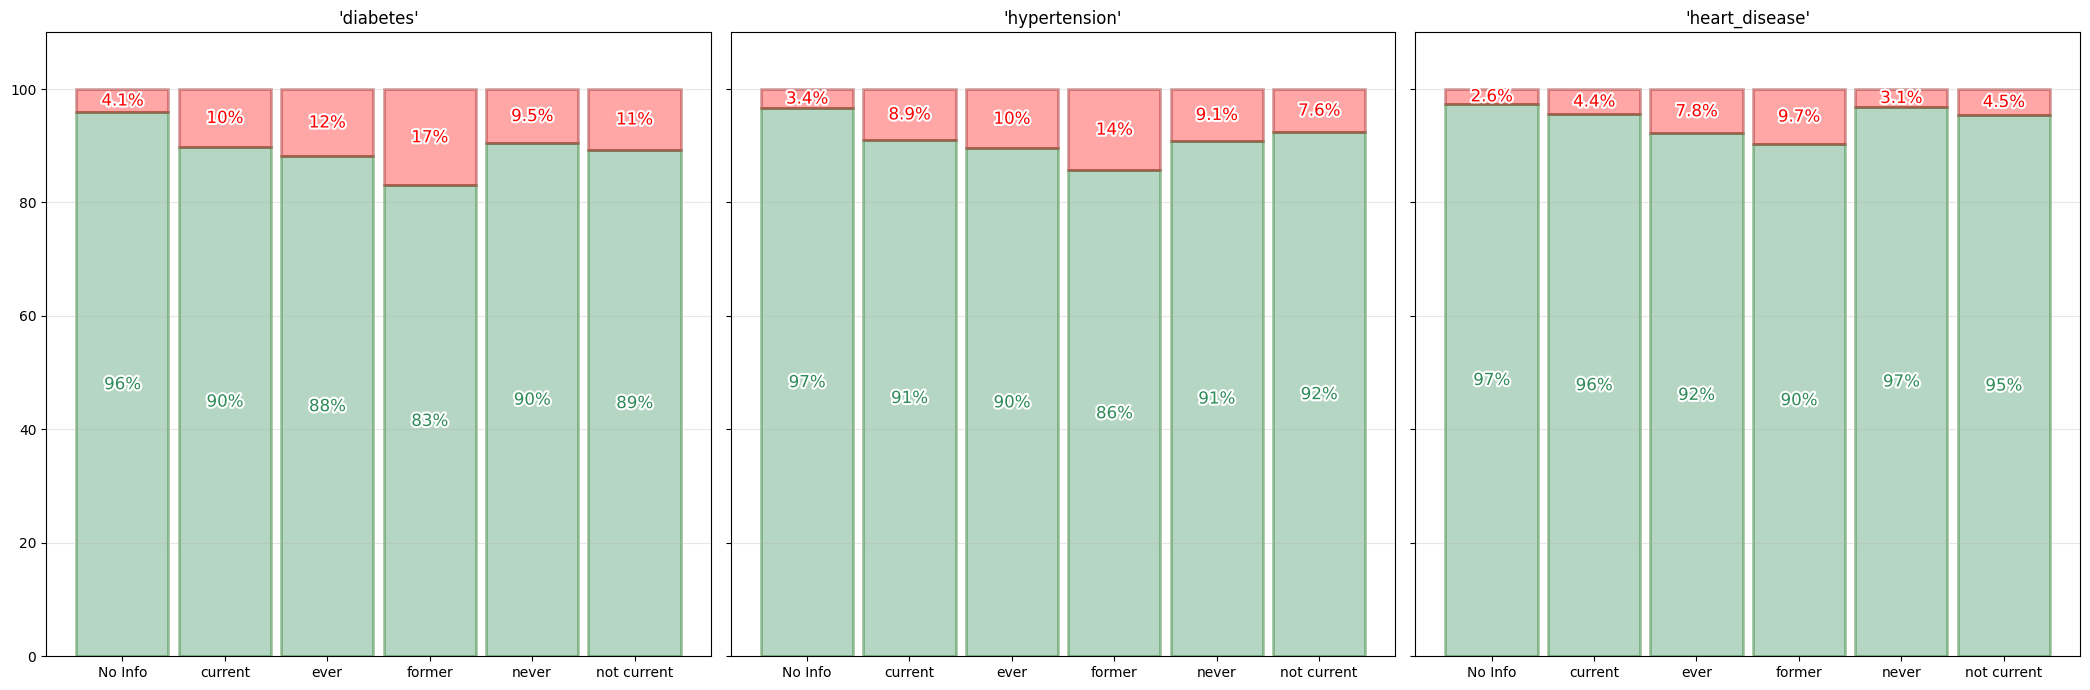

In [113]:
order = ['No Info', 'current', 'ever', 'former', 'never', 'not current']
colors = {'0': 'seagreen', '1': 'red'}

ut.plot_stacked_percent_panels(data, group_col='smoking_history',
                               target_cols=['diabetes', 'hypertension', 'heart_disease'], 
                               order=order, colors=colors, min_show=2.0, 
                               fontsize=12, figsize=(21, 7), sharey=True)

plt.show()

El análisis de los recuentos y proporciones de individuos que presentan las distintas patologías incluidas en el conjunto de datos revela resultados que, en una primera aproximación, pueden resultar poco intuitivos.

En particular, se observa que los individuos que fuman actualmente y aquellos que nunca han fumado presentan proporciones de diabetes, hipertensión y enfermedad cardíaca relativamente similares. En estos grupos, la prevalencia de las patologías analizadas difiere solo de forma marginal, lo que sugiere que la condición de fumador actual, por sí sola, no explica de manera concluyente las diferencias observadas en la incidencia de estas enfermedades.

Por el contrario, la categoría `former` destaca de forma consistente por presentar las **mayores prevalencias en las tres patologías consideradas**, incluso en comparación con grupos que podrían considerarse conceptualmente próximos, como `ever` o `not current`. Este patrón sugiere la existencia de un perfil clínico diferenciado en el grupo de exfumadores.

Una posible explicación de este comportamiento es que el impacto del tabaquismo sobre la salud no dependa únicamente del estado actual del hábito, sino también de su persistencia y acumulación a lo largo del tiempo. En este sentido, variables como la edad podrían estar actuando como factores de confusión o mediadores en la relación observada entre el historial de tabaquismo y la presencia de patologías.

Con el objetivo de explorar esta hipótesis, en el punto 3.1. se analiza la distribución de la edad en cada una de las subcategorías de smoking_history, con el fin de evaluar si las diferencias observadas en la prevalencia de enfermedades pueden estar parcialmente explicadas por diferencias en la estructura etaria de los grupos.

#### Edad de los sujetos segregados por su historial de tabaquismo. 

smoking_history  never  No Info  current  former  not current   ever
mean             43.89    33.54    44.07   57.06        47.72  49.14

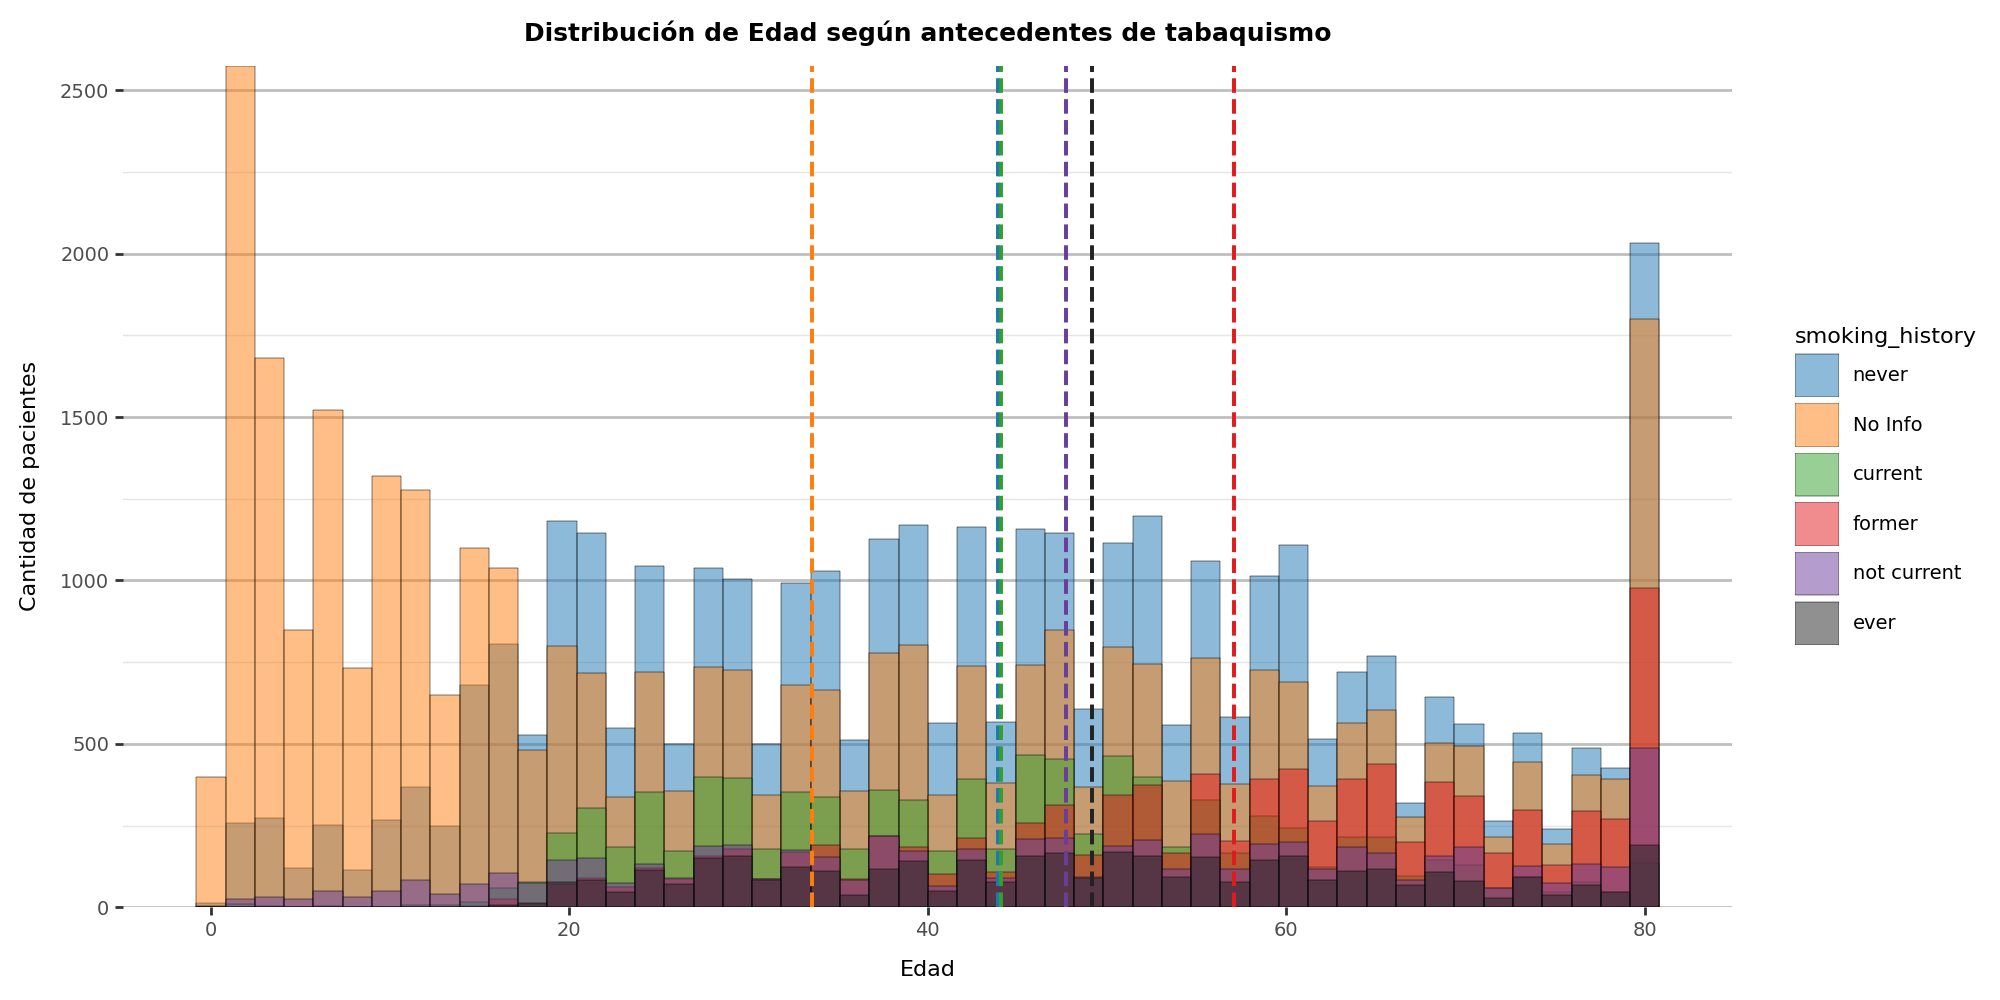

In [114]:
colors = {
    'never'       : '#1F77B4',
    'No Info'     : '#FF7F0E',
    'current'     : '#33A02C',
    'former'      : '#E31A1C',
    'not current' : '#6A3D9A',
    'ever'        : '#222222',
}

order_categories = ['never', 'No Info', 'current', 'former', 'not current', 'ever']
plot,means = ut.hist_comparative(
    data,'age','smoking_history',
    order_categories=order_categories,
    colors_per_group=colors,
    fig_size=(10,5)
)

display(means)
plot.show()

Como habíamos intuido, los grupos de distintos tipos de historiales no tienen las mismas medias. Aunque para determinar de manera definitiva esto sería necesario un test estadístico que lo confirmase, a simple vista, podemos ver que los grupos de ``fumadores'' de mayor edad son los *former*, coincidiendo justamente con aquellos que sufren en mayor proporción las patologías estudiadas. 

Por otro lado, a medida que la edad de estos grupos baja, también baja la proporción de sujetos afectados. Esto es un claro indicador de que **la edad es un factor fundamental a la hora de determinar cuán probable es que un individuo sufra alguna de las patologías**. Quizás sería interesante estudiar el efecto combinado de las variables edad con la variable categórica del historial fumador. Esto se puede hacer mediante una serie de cortes artificiales en la edad.

#### `blood_glucose_level` y `HbA1c_level` en relación a la diabetes.

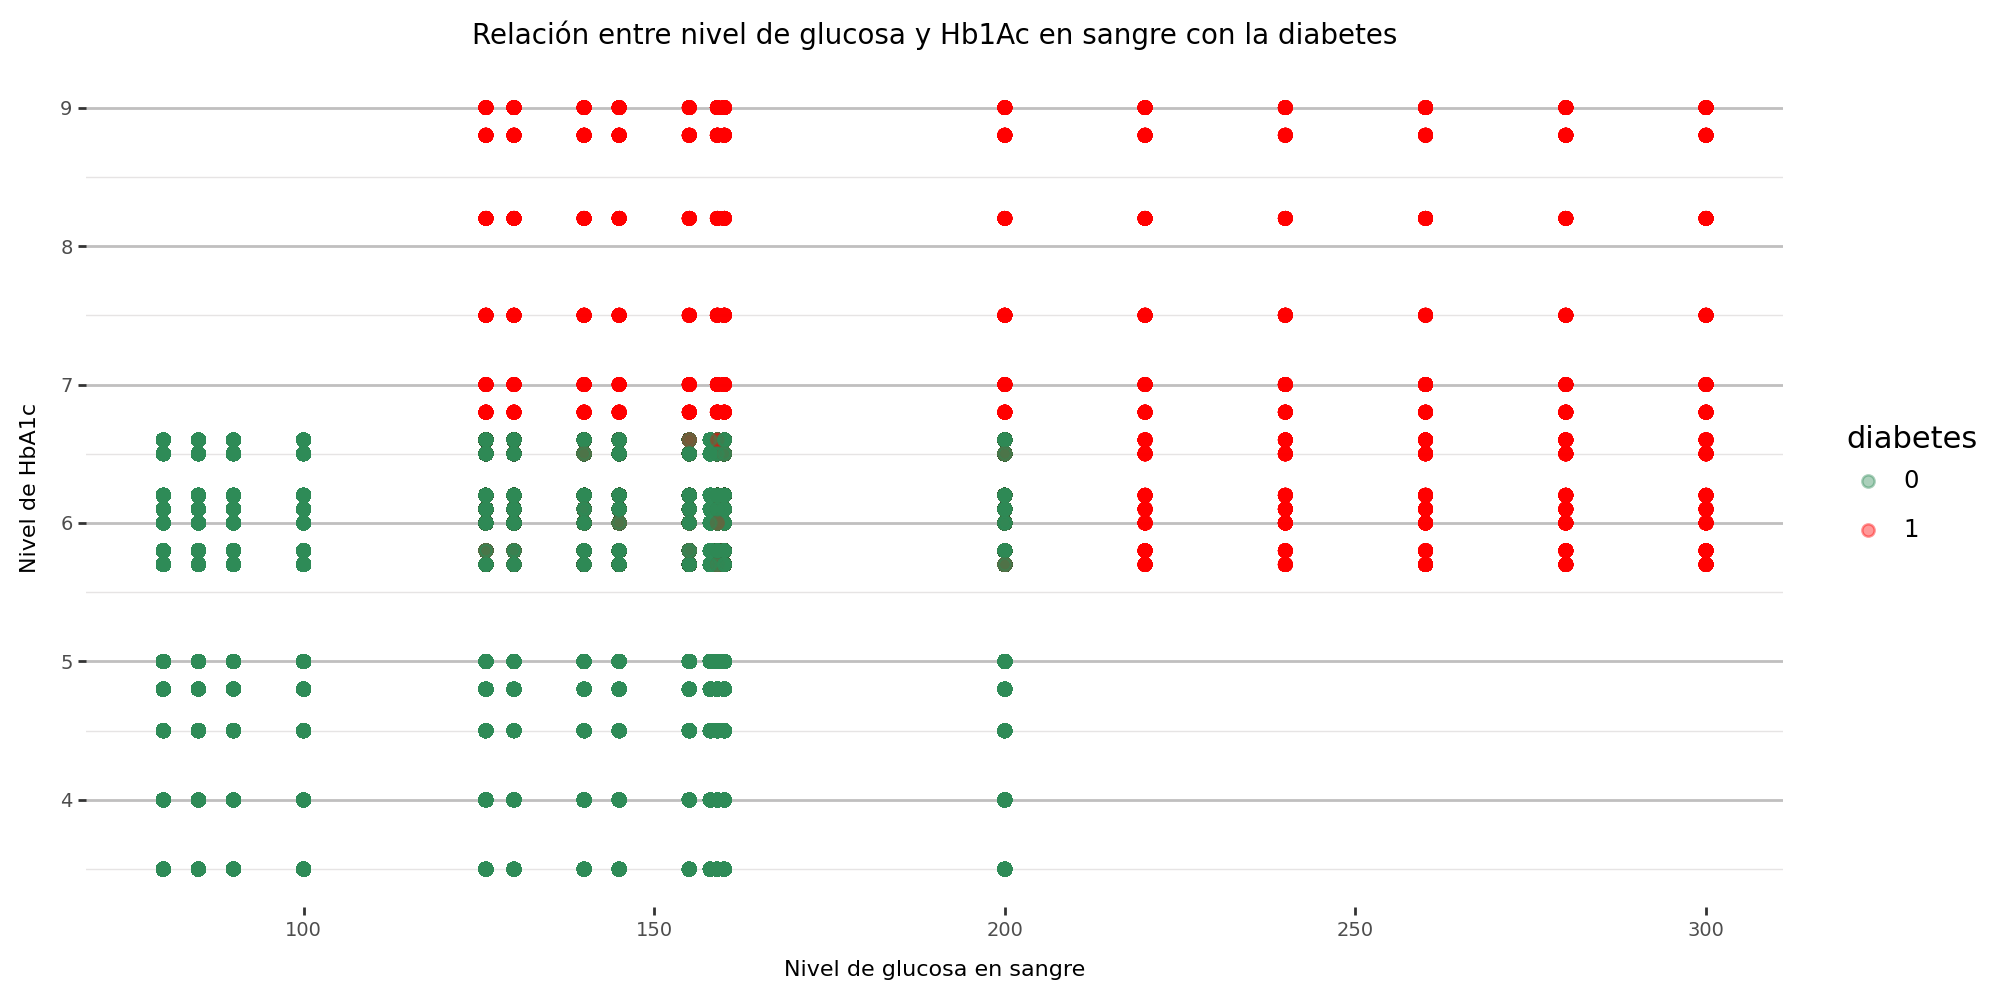

In [115]:
ut.scatter_plot(data,
                x_values='blood_glucose_level',
                y_values='HbA1c_level',
                fig_size=(10,5),
                title='Relación entre nivel de glucosa y Hb1Ac en sangre con la diabetes',
                x_label='Nivel de glucosa en sangre',
                y_label='Nivel de HbA1c',
                col_target='diabetes',
                colors_per_group={'0':'seagreen','1':'red'}
            ).show()

Es evidente en primer lugar que existe una dependencia total entre el valor del nivel de `HbA1c` y el nivel de la glucosa en sangre. Allá donde la glucosa es alta, los niveles bajos de *HbA1c* ni siquiera existen. Por el otro lado, donde la glucosa es baja, los valores mayores de *HbA1c* tampoco existen. Es decir, el nivel de hemoglobina con glucosas adheridad es mayor cuanto mayor es el nivel de glucosa en sangre (como era de esperar).

Pero es que además parece haber un claro nivel de corte en estos niveles a partir de los cuales se considera que una persona tiene diabetes, estos son:


\begin{cases}
\text{blood\_glucose\_level} > 200 \\
\text{HbA1c\_level} > 6.7
\end{cases}


Esto es consistente con las métricas asociadas a **nivel de glucosa (azúcar) en sangre promedio durante los últimos dos o tres meses (prueba A1c)** y a **prueba de tolerancia oral a la glucosa (*blood_glucose_level*)** que se pueden encontrar [aquí](https://diabetes.org/espanol/diagnostico).

#### Edad y BMI segregados por diabetes.

Vamos a ver como es la relación entre estas variables "contínuas" usando un gráfico de dispersión al uso.

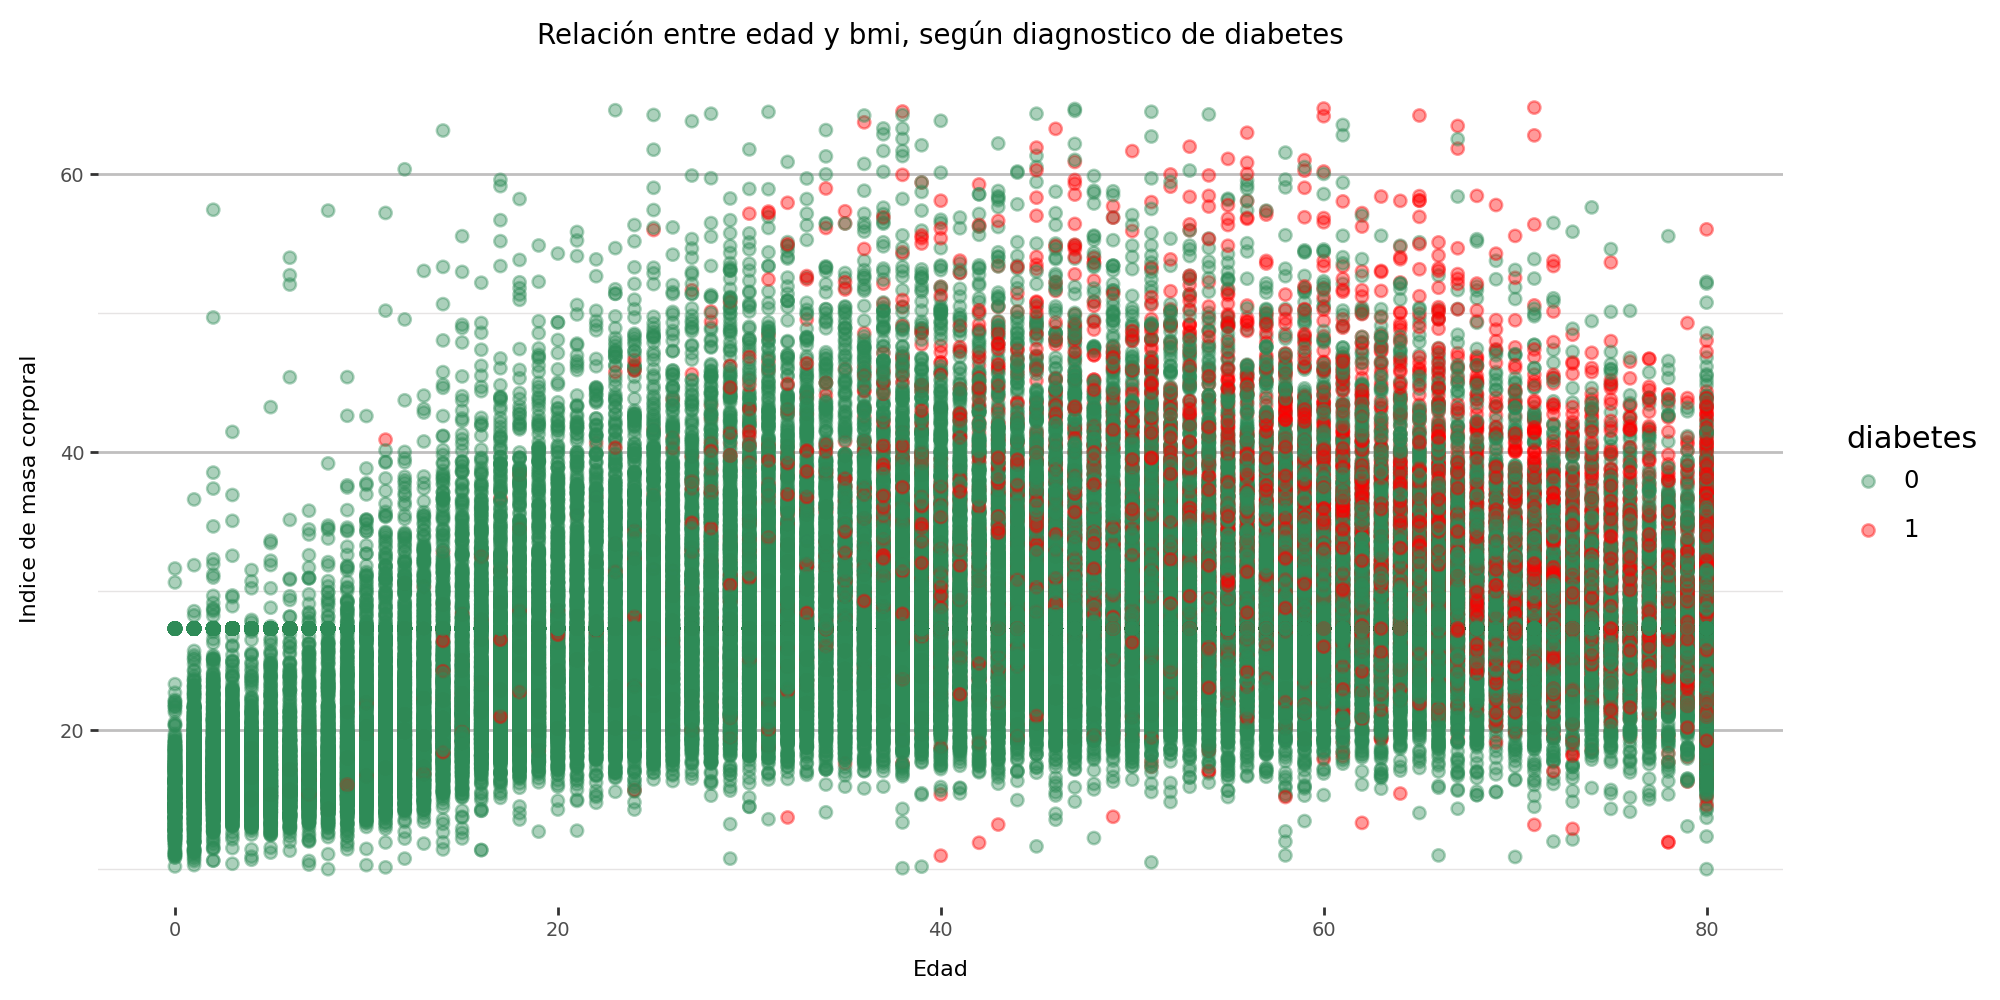

In [116]:
ut.scatter_plot(data,
                x_values='age',
                y_values='bmi',
                fig_size=(10,5),
                title='Relación entre edad y bmi, según diagnostico de diabetes',
                x_label='Edad',
                y_label='Indice de masa corporal',
                col_target='diabetes',
                colors_per_group={'0':'seagreen','1':'red'}
            ).show()

* `BMI`
Como podemos observar, existe una ligera tendencia del IMC a aumentar con la edad como se puede ver en la linea de tendencia. SI observamos el color de cada uno de los puntos, es evidente que aquellos puntos que se encuentran en zonas de edad más longevas y con un *BMI* alto tienen una mayor tendencia a sufrir diabetes. Esto es algo que, al segregar el *BMI* por la variable diabetes, podemos ver como las distribuciones se separan hasta en $2.5\%$ en mediana.

## 3. Insights y tests de hipótesis


### 3.1.Evaluación exploratoria de la heterogeneidad entre subcategorías de smoking_history

Para evaluar si las subcategorías de `smoking_history` (`ever`, `not current` y `former`) presentan comportamientos diferenciados en las variables numéricas de interés, se aplican contrastes estadísticos **globales**, uno por cada variable analizada.

El objetivo de este análisis no es comparar pares de categorías ni identificar diferencias específicas entre grupos concretos, sino **determinar si existe evidencia estadística de que al menos una subcategoría difiere del resto** en cada variable o si presentan patrones similares respecto a la variable objetivo (diabetes), lo que permitiría considerar una posible agrupación desde un punto de vista interpretativo y analítico.

 Dado el gran tamaño muestral, la significación estadística por sí sola no se utilizará como criterio de decisión de la posible unión, priorizándose el comportamiento respecto al target, el tamaño del efecto y la coherencia semántica de las categorías. Debido a esto y a la naturaleza heterogénea de las variables analizadas, no se utilizan contrastes pareados como criterio para decidir una posible agrupación de categorías.


In [117]:
ever_smoked = data[data.smoking_history == 'ever']
notcurrent_smoked = data[data.smoking_history == 'not current']
former_smoked = data[data.smoking_history == 'former']

ever_smoked.shape[0], notcurrent_smoked.shape[0], former_smoked.shape[0]

(4002, 6438, 9346)

Para las variables continuas no se ha utilizado el t-test de Student (ni su variante de Welch) porque se trata de un contraste paramétrico diseñado para comparar **dos grupos** y basado en la comparación de **medias**.

En este contexto, `smoking_history` presenta **más de dos subcategorías**, y la aplicación de t-tests implicaría realizar múltiples comparaciones por pares, lo que:

- Incrementa el riesgo de inflación del error tipo I
- Dificulta la interpretación global de los resultados
- No responde directamente a la pregunta principal del análisis

El test de Kruskal–Wallis resulta más adecuado porque permite comparar **más de dos grupos simultáneamente**, no asume normalidad y es robusto frente a asimetrías y valores extremos, ofreciendo un enfoque coherente con un análisis exploratorio y global.

Para las variables binarias se utiliza el test Chi-cuadrado de independencia, que se utiliza para evaluar asociaciones globales entre `smoking_history` y variables binarias de interés (diabetes, hipertensión y enfermedad cardíaca). Además, este último estará complementado con el tamaño del efecto (V de Cramér).

Estos contrastes se interpretan como análisis exploratorios globales y no como un criterio decisorio para la unificación de categorías

In [118]:
binary_vars = ['diabetes', 'hypertension', 'heart_disease']

groups = {
    'ever': ever_smoked,
    'not current': notcurrent_smoked,
    'former': former_smoked
}

group_order = ['ever', 'not current', 'former']

df_continuous_tests = ut.kruskal_table(groups, continuous_vars)
display(df_continuous_tests)

df_binary_tests = ut.chi2_binary_table(
    data,
    group_col='smoking_history',
    groups=group_order,
    binary_vars=binary_vars
)
display(df_binary_tests)

prop_table = ut.proportion_table(
    data,
    group_col='smoking_history',
    groups=group_order,
    binary_vars=binary_vars
)
display(prop_table)

Variable            Test        p-value
0                  age  Kruskal-Wallis  4.946788e-222
1                  bmi  Kruskal-Wallis   5.256116e-51
2          HbA1c_level  Kruskal-Wallis   3.052177e-06
3  blood_glucose_level  Kruskal-Wallis   4.167651e-05

Variable          Test       p-value  V de Cramér
0       diabetes  Chi-cuadrado  4.368156e-32     0.085434
1   hypertension  Chi-cuadrado  6.690194e-39     0.094261
2  heart_disease  Chi-cuadrado  5.244768e-32     0.085326

diabetes  hypertension  heart_disease
smoking_history                                       
ever                11.79         10.47           7.82
former              17.00         14.32           9.69
not current         10.72          7.58           4.54

**Interpretación de los contrastes globales**

Los contrastes estadísticos globales indican la existencia de diferencias entre las subcategorías `ever`, `not current` y `former` en todas las variables analizadas. En particular, para las variables continuas (edad, BMI, HbA1c y nivel de glucosa), el test de Kruskal–Wallis rechaza la hipótesis nula de igualdad de distribuciones, lo que sugiere que **al menos una de las categorías presenta un comportamiento distinto**.
 
No obstante, dado el gran tamaño muestral del conjunto de datos, estos resultados deben interpretarse con cautela. En el caso de las variables binarias (diabetes, hipertensión y enfermedad cardíaca), aunque los tests Chi-cuadrado resultan altamente significativos, los valores del tamaño del efecto medidos mediante la V de Cramér son bajos (≈0.08–0.09), lo que indica asociaciones de **magnitud pequeña**.

En conjunto, estos resultados confirman la existencia de diferencias estadísticas globales entre categorías, pero sugieren que dichas diferencias, en términos prácticos, son moderadas. Por tanto, estos contrastes no se utilizan como criterio directo para decidir la unificación de categorías, sino como evidencia exploratoria que complementa el análisis descriptivo y el comportamiento respecto a la variable objetivo (diabetes).

**Análisis descriptivo de patologías según historial de tabaquismo**  

Mediante el test Chi-cuadrado se evalúa la asociación global entre el historial de tabaquismo (`smoking_history`) y la prevalencia de distintas patologías relevantes (diabetes, hipertensión y enfermedad cardíaca). Este contraste permite analizar si la distribución de dichas patologías depende del grupo de tabaquismo, sin utilizarse como criterio directo para la unificación de categorías.
 
La tabla de proporciones complementa este análisis mostrando, de forma descriptiva, cómo varía la incidencia de cada patología entre las distintas clases. En particular, se observa que la categoría `former` presenta de manera consistente las mayores prevalencias en las tres patologías analizadas, mientras que el resto de categorías muestran valores más próximos entre sí.
  
Este resultado refuerza la consideración de `former` como un grupo con un perfil clínico diferenciado, motivando un análisis específico de sus características en comparación con el resto de individuos.

# 4. Conclusiones y trabajo futuro

## Conclusiones del análisis exploratorio

Tras completar el proceso de limpieza, transformación y preparación del dataset, se obtuvo un conjunto de variables consistente, interpretable y adecuado para el desarrollo de modelos predictivos.

Las variables numéricas finales consideradas fueron **Age, BMI, nivel de glucosa en sangre y HbA1c**, mientras que las variables categóricas incluyeron **género, historial de tabaquismo, hipertensión y enfermedad cardíaca**, además de versiones **discretizadas (binning)** de edad, glucosa, HbA1c y BMI.

Del análisis descriptivo y visual se desprenden los siguientes hallazgos:

- **Age, BMI, HbA1c y glucosa en sangre** presentan alta capacidad discriminante y relaciones monotónicas claras con la presencia de diabetes.
- **Hipertensión y enfermedad cardíaca** muestran una asociación positiva relevante con la variable objetivo.
- **Género y tabaquismo**, aunque menos influyentes de forma individual, aportan información complementaria.
- La **discretización de variables** permitió capturar relaciones no lineales, reducir la influencia de outliers y mejorar la interpretabilidad.

En conjunto, estas evidencias indican que el problema puede abordarse eficazmente como una **tarea de clasificación supervisada binaria**, contando con predictores clínicamente significativos y estadísticamente informativos.

---

## Modelos a considerar a futuro

Dado que no es recomendable basar el análisis en un único modelo, se propone evaluar múltiples enfoques con distintos supuestos y niveles de complejidad, comparando su desempeño y capacidad de generalización.

### 🔹 Modelos base (interpretables)

### Regresión Logística
- Servirá como **baseline** del proyecto.
- Alta interpretabilidad mediante coeficientes y *odds ratios*.
- Permite comprender la contribución individual de cada variable.
- Adecuada para contextos clínicos donde la explicabilidad es importante.

---

### 🔹 Modelos basados en árboles

### Árboles de Decisión
- Capturan relaciones no lineales e interacciones automáticamente.
- Generan reglas fácilmente interpretables.
- Útiles para obtener intuiciones iniciales del comportamiento del dataset.

### Random Forest (Bagging – Ensamble)
- Conjunto de múltiples árboles entrenados sobre muestras aleatorias.
- Reduce la varianza y mejora la robustez frente a overfitting.
- Maneja bien variables mixtas y ruido.
- Proporciona métricas de importancia de variables.

---

### 🔹 Modelos adicionales de comparación

### Support Vector Machines (SVM)
- Útiles para fronteras de decisión no lineales mediante kernels.
- Pueden funcionar bien tras normalización de variables.

### K-Nearest Neighbors (KNN)
- Método no paramétrico simple.
- Puede servir como referencia adicional para comparar desempeño.

---

## Estrategia experimental recomendada

Para garantizar resultados confiables y comparables, se propone:

1. División Train / Validation / Test.
2. Validación cruzada (k-fold, cross-validation).
3. Ajuste de hiperparámetros (Grid Search o Random Search).
4. Evaluación con múltiples métricas:
   - Accuracy
   - Precision
   - Recall (especialmente relevante en contexto médico)
   - F1-score
   - AUC-ROC
---

## Próximos pasos

- Implementar un modelo baseline (Regresión Logística).
- Comparar con Random Forest.
- Seleccionar el modelo final considerando **precisión + interpretabilidad + estabilidad**.
- Analizar errores (falsos negativos/positivos) para valorar impacto clínico.

En definitiva, el objetivo es identificar un modelo que no solo alcance alto rendimiento estadístico, sino que también resulte interpretable y confiable para su posible aplicación en contextos sanitarios.
